## Modèle Deberta v3 small

New train_df distribution:
 label
0    1097
1     919
Name: count, dtype: int64

New valid_df distribution:
 label
0    275
1    230
Name: count, dtype: int64

Test set distribution (old valid.csv):
 label
0    420
1    366
Name: count, dtype: int64


c:\Users\Olivier\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.266300,0.238762,0.907598
2,0.138800,0.226771,0.915114
3,0.106400,0.280186,0.939457
4,0.071500,0.471487,0.921529
5,0.024500,0.312394,0.940678
6,0.007200,0.357378,0.937238
7,0.000900,0.436695,0.926230



✅ Best threshold found on validation set: 0.52 (F1 = 0.9427)



Final Test F1 on old valid.csv using threshold 0.52 = 0.9455


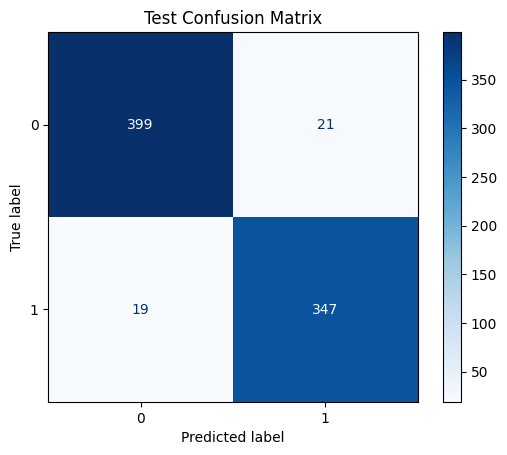

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.95      0.95      0.95       420
     Class 1       0.94      0.95      0.95       366

    accuracy                           0.95       786
   macro avg       0.95      0.95      0.95       786
weighted avg       0.95      0.95      0.95       786


Training logs saved to training_log.csv


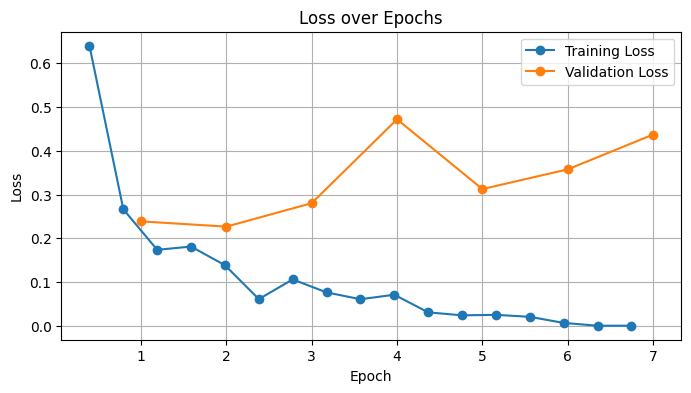

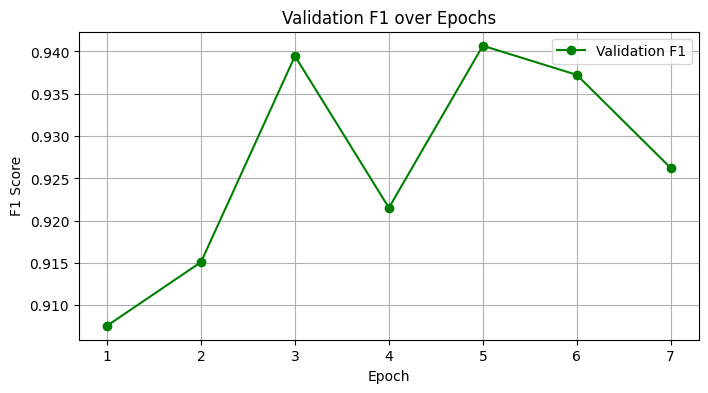

In [5]:
import pandas as pd
import numpy as np
import torch
import random
from sklearn.model_selection import train_test_split
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          Trainer, TrainingArguments, EarlyStoppingCallback)
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Configurations identiques à votre script original
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Configuration mémoire
def print_gpu_memory():
    if torch.cuda.is_available():
        print(f"GPU Memory Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
        print(f"GPU Memory Cached: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

# -------------------------------
# 1. Load the datasets
# -------------------------------
# train.csv = big dataset (2521 examples)
# valid.csv = final test set (786 examples) => We'll rename it test_df in code

train_full_df = pd.read_csv("data/train.csv")   # 2521 examples
test_df = pd.read_csv("data/valid.csv")           # 786 examples (final sealed test)

# Rename "labels" to "label" for consistency
train_full_df = train_full_df.rename(columns={"labels": "label"})
test_df = test_df.rename(columns={"labels": "label"})

# -------------------------------
# 2. Split train.csv into train + valid subsets
# -------------------------------
# We take 80% for training, 20% for validation
train_df, valid_df = train_test_split(
    train_full_df,
    test_size=0.2,  
    stratify=train_full_df["label"],  # maintain class distribution
    random_state=42
)

print("New train_df distribution:\n", train_df["label"].value_counts())
print("\nNew valid_df distribution:\n", valid_df["label"].value_counts())
print("\nTest set distribution (old valid.csv):\n", test_df["label"].value_counts())

# -------------------------------
# 3. Create a custom Dataset
# -------------------------------
class VaccineDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer, max_length=384):  # Changed max_length to 384
        self.texts = dataframe['text'].tolist()
        self.labels = dataframe['label'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        # Tokenize the text with truncation and padding to max_length
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        # Remove the batch dimension from each tensor
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# -------------------------------
# 4. Load the DeBERTa tokenizer and model
# -------------------------------
model_name = "microsoft/deberta-v3-small"  # Changed model to DeBERTa
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=2,
    # Activation des techniques d'économie mémoire
    device_map='auto'  # Répartition automatique sur le GPU
)

# Activation du gradient checkpointing
model.gradient_checkpointing_enable()

# Create datasets using the custom VaccineDataset class
train_dataset = VaccineDataset(train_df, tokenizer, max_length=384)
valid_dataset = VaccineDataset(valid_df, tokenizer, max_length=384)
test_dataset = VaccineDataset(test_df, tokenizer, max_length=384)

# -------------------------------
# 5. Define the compute_metrics function for evaluation
# -------------------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, preds, pos_label=1)
    return {"f1": f1}

# -------------------------------
# 6. Define TrainingArguments with EarlyStopping
# -------------------------------

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=10,
    per_device_train_batch_size=8,  # Réduit de 16 à 8 pour la 3070
    per_device_eval_batch_size=8,   # Idem
    gradient_accumulation_steps=2,  # Simule un batch size de 16
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_steps=50,
    seed=SEED,
    report_to=[],
    fp16=True,  # Enable mixed precision for better memory usage
    gradient_checkpointing=True  # Économie mémoire
)
# -------------------------------
# 7. Create the Trainer with an EarlyStopping callback
# -------------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,  # used for early stopping and best model selection
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # stops if no improvement after 2 epochs
)

# Train the model
trainer.train()

# -------------------------------
# 7b. Tune the best threshold on the validation dataset
# -------------------------------
# Get predictions on valid_df for threshold tuning
valid_predictions = trainer.predict(valid_dataset)
valid_logits = valid_predictions.predictions
valid_labels = valid_predictions.label_ids

# Compute probabilities for the positive class
valid_probs = torch.softmax(torch.tensor(valid_logits), dim=1)[:, 1].numpy()

# Search for the best threshold
best_f1 = 0
best_thresh = 0.5  # Default threshold
for thresh in np.arange(0, 1.01, 0.01):
    preds = (valid_probs >= thresh).astype(int)
    score = f1_score(valid_labels, preds, pos_label=1)
    if score > best_f1:
        best_f1 = score
        best_thresh = thresh

print(f"\n✅ Best threshold found on validation set: {best_thresh:.2f} (F1 = {best_f1:.4f})")

# -------------------------------
# 8. Evaluate on the final test set (old valid.csv) using the best threshold
# -------------------------------
test_predictions = trainer.predict(test_dataset)
test_logits = test_predictions.predictions
test_labels = test_predictions.label_ids

# Apply the optimal threshold
test_probs = torch.softmax(torch.tensor(test_logits), dim=1)[:, 1].numpy()
test_preds = (test_probs >= best_thresh).astype(int)

# Compute F1-score on the test set using the tuned threshold
test_f1 = f1_score(test_labels, test_preds, pos_label=1)
print(f"\nFinal Test F1 on old valid.csv using threshold {best_thresh:.2f} = {test_f1:.4f}")

# -------------------------------
# 8b. Display the Confusion Matrix on the Test Set
# -------------------------------
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Test Confusion Matrix")
plt.show()

# -------------------------------
# 8c. Print the Classification Report (precision, recall, F1 per class)
# -------------------------------
report = classification_report(test_labels, test_preds, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)

# -------------------------------
# 8d. Save training logs to CSV
# -------------------------------
logs_df = pd.DataFrame(trainer.state.log_history)
logs_df.to_csv("training_log.csv", index=False)
print("\nTraining logs saved to training_log.csv")

# -------------------------------
# 9. Plot learning curves to check for overfitting
# -------------------------------
# Extract training and evaluation logs
train_logs = [log for log in trainer.state.log_history if "loss" in log and "eval_loss" not in log]
eval_logs = [log for log in trainer.state.log_history if "eval_loss" in log]

# Build lists of epochs, train loss, eval loss, and eval f1
train_epochs = [log["epoch"] for log in train_logs]
train_loss = [log["loss"] for log in train_logs]

eval_epochs = [log["epoch"] for log in eval_logs]
eval_loss = [log["eval_loss"] for log in eval_logs]
eval_f1 = [log["eval_f1"] for log in eval_logs]

# Plot: Training vs Validation Loss
plt.figure(figsize=(8, 4))
plt.plot(train_epochs, train_loss, marker='o', label="Training Loss")
plt.plot(eval_epochs, eval_loss, marker='o', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Plot: Validation F1 Score
plt.figure(figsize=(8, 4))
plt.plot(eval_epochs, eval_f1, marker='o', color='green', label="Validation F1")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation F1 over Epochs")
plt.legend()
plt.grid(True)
plt.show()


## Deberta + moyenne de 3 loss + AutoML

## Optuna + 3 loss functions

In [ ]:
import pandas as pd
import numpy as np
import torch
import random
import optuna
from sklearn.model_selection import train_test_split
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          Trainer, TrainingArguments, EarlyStoppingCallback)
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, fbeta_score
import matplotlib.pyplot as plt
import torch.nn.functional as F

# -------------------------------
# 1. Set random seeds for reproducibility
# -------------------------------
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# -------------------------------
# 2. Function to print GPU memory (if available)
# -------------------------------
def print_gpu_memory():
    if torch.cuda.is_available():
        print(f"GPU Memory Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
        print(f"GPU Memory Cached: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

# -------------------------------
# 3. Load datasets
# -------------------------------
# train.csv: big dataset (2521 examples)
# valid.csv: final test set (786 examples)
train_full_df = pd.read_csv("data/train.csv")   # 2521 examples
test_df = pd.read_csv("data/valid.csv")           # 786 examples (final sealed test)

# Rename "labels" to "label" for consistency
train_full_df = train_full_df.rename(columns={"labels": "label"})
test_df = test_df.rename(columns={"labels": "label"})

# -------------------------------
# 4. Split train_full_df into train and validation subsets (80/20 split)
# -------------------------------
train_df, valid_df = train_test_split(
    train_full_df,
    test_size=0.2,  
    stratify=train_full_df["label"],  # maintain class distribution
    random_state=SEED
)

print("New train_df distribution:\n", train_df["label"].value_counts())
print("\nNew valid_df distribution:\n", valid_df["label"].value_counts())
print("\nTest set distribution (old valid.csv):\n", test_df["label"].value_counts())

# -------------------------------
# 5. Create a custom Dataset for tokenization
# -------------------------------
class VaccineDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer, max_length=384):
        self.texts = dataframe['text'].tolist()
        self.labels = dataframe['label'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        # Tokenize the text with truncation and padding to max_length
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        # Remove the batch dimension from each tensor
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# -------------------------------
# 6. Load the DeBERTa tokenizer and set model name
# -------------------------------
model_name = "roberta-base"  # Using DeBERTa model
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Create dataset instances
train_dataset = VaccineDataset(train_df, tokenizer, max_length=384)
valid_dataset = VaccineDataset(valid_df, tokenizer, max_length=384)
test_dataset  = VaccineDataset(test_df, tokenizer, max_length=384)

# -------------------------------
# 7. Define custom loss functions
# -------------------------------
def focal_loss(logits, targets, alpha=1, gamma=2):
    """
    Compute focal loss for multi-class classification.
    """
    ce_loss = F.cross_entropy(logits, targets, reduction='none')
    pt = torch.exp(-ce_loss)  # p_t: probability of correct classification
    focal_loss_val = alpha * ((1 - pt) ** gamma) * ce_loss
    return focal_loss_val.mean()

def dice_loss(logits, targets, smooth=1):
    """
    Compute dice loss for multi-class classification.
    """
    num_classes = logits.size(1)
    # Convert targets to one-hot encoding
    targets_one_hot = F.one_hot(targets, num_classes=num_classes).float()
    probs = torch.softmax(logits, dim=1)
    intersection = torch.sum(probs * targets_one_hot, dim=0)
    union = torch.sum(probs, dim=0) + torch.sum(targets_one_hot, dim=0)
    dice = (2 * intersection + smooth) / (union + smooth)
    return (1 - dice).mean()

# -------------------------------
# 8. Create a custom Trainer to use the combined loss
# -------------------------------
class CustomTrainer(Trainer):
    def __init__(self, alpha=0.33, beta=0.33, gamma=0.33, *args, **kwargs):
        """
        alpha, beta, gamma: weights for cross entropy, focal, and dice losses respectively.
        """
        super().__init__(*args, **kwargs)
        self.alpha_weight = alpha
        self.beta_weight = beta
        self.gamma_weight = gamma
        
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        # Cross Entropy Loss
        ce_loss = F.cross_entropy(logits, labels)
        # Focal Loss
        fl = focal_loss(logits, labels, alpha=1, gamma=2)
        # Dice Loss
        dl = dice_loss(logits, labels)
        
        # Combined Loss: weighted sum of individual losses
        combined_loss = self.alpha_weight * ce_loss + self.beta_weight * fl + self.gamma_weight * dl
        
        return (combined_loss, outputs) if return_outputs else combined_loss

# -------------------------------
# 9. Define compute_metrics function for evaluation using Fβ (beta=1.3)
# -------------------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    fbeta = fbeta_score(labels, preds, beta=1.3, pos_label=1)
    return {"f1_beta": fbeta}

# -------------------------------
# 10. Define the objective function for Optuna
# -------------------------------
def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_uniform("learning_rate", 1e-6, 5e-5)
    weight_decay = trial.suggest_uniform("weight_decay", 0.0, 0.1)
    alpha = trial.suggest_uniform("alpha", 0.1, 1.0)
    beta = trial.suggest_uniform("beta", 0.1, 1.0)
    gamma = trial.suggest_uniform("gamma", 0.1, 1.0)
    
    # Define TrainingArguments for this trial
    training_args = TrainingArguments(
        output_dir="./results",
        eval_strategy="epoch",
        save_strategy="epoch",
        num_train_epochs=10,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        gradient_accumulation_steps=2,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        load_best_model_at_end=True,
        metric_for_best_model="f1_beta",
        logging_steps=50,
        seed=SEED,
        report_to=[],
        fp16=True,
        gradient_checkpointing=True
    )
    
    # Reload the model for each trial
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, 
        num_labels=2,
        device_map='auto'
    )
    model.gradient_checkpointing_enable()
    
    # Instantiate the custom trainer with the current hyperparameters
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
        alpha=alpha,
        beta=beta,
        gamma=gamma
    )
    
    # Train the model
    trainer.train()
    
    # Evaluate on the validation set
    eval_result = trainer.evaluate(valid_dataset)
    f1_beta = eval_result.get("eval_f1_beta")
    
    # Report the metric to Optuna
    return f1_beta

# -------------------------------
# 11. Run the Optuna study to optimize hyperparameters
# -------------------------------
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)  # Increase n_trials for a more exhaustive search

print("Best trial:")
trial = study.best_trial
print("  F1_beta: {:.4f}".format(trial.value))
print("  Best hyperparameters: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# -------------------------------
# 12. Retrain final model using best hyperparameters and evaluate on the test set
# -------------------------------

# Use the best hyperparameters from Optuna
best_lr = trial.params["learning_rate"]
best_wd = trial.params["weight_decay"]
best_alpha = trial.params["alpha"]
best_beta = trial.params["beta"]
best_gamma = trial.params["gamma"]

final_training_args = TrainingArguments(
    output_dir="./final_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    learning_rate=best_lr,
    weight_decay=best_wd,
    load_best_model_at_end=True,
    metric_for_best_model="f1_beta",
    logging_steps=50,
    seed=SEED,
    report_to=[],
    fp16=True,
    gradient_checkpointing=True
)

# Load a fresh model
final_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    device_map='auto'
)
final_model.gradient_checkpointing_enable()

final_trainer = CustomTrainer(
    model=final_model,
    args=final_training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,  # You can also combine train and valid for final training if desired
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    alpha=best_alpha,
    beta=best_beta,
    gamma=best_gamma
)

# Train the final model
final_trainer.train()

# -------------------------------
# 13. Tune the best threshold on the validation dataset using Fβ (beta=1.3)
# -------------------------------
valid_predictions = final_trainer.predict(valid_dataset)
valid_logits = valid_predictions.predictions
valid_labels = valid_predictions.label_ids

# Compute probabilities for the positive class
valid_probs = torch.softmax(torch.tensor(valid_logits), dim=1)[:, 1].numpy()

best_fbeta = 0
best_thresh = 0.5  # Default threshold
for thresh in np.arange(0, 1.01, 0.01):
    preds = (valid_probs >= thresh).astype(int)
    score = fbeta_score(valid_labels, preds, beta=1.3, pos_label=1)
    if score > best_fbeta:
        best_fbeta = score
        best_thresh = thresh

print(f"\n✅ Best threshold found on validation set: {best_thresh:.2f} (Fβ = {best_fbeta:.4f})")

# -------------------------------
# 14. Evaluate on the final test set using the best threshold
# -------------------------------
test_predictions = final_trainer.predict(test_dataset)
test_logits = test_predictions.predictions
test_labels = test_predictions.label_ids

test_probs = torch.softmax(torch.tensor(test_logits), dim=1)[:, 1].numpy()
test_preds = (test_probs >= best_thresh).astype(int)

test_f1 = f1_score(test_labels, test_preds, pos_label=1)
print(f"\nFinal Test F1 on old valid.csv using threshold {best_thresh:.2f} = {test_f1:.4f}")

# -------------------------------
# 15. Display the Confusion Matrix on the Test Set
# -------------------------------
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Test Confusion Matrix")
plt.show()

# -------------------------------
# 16. Print the Classification Report
# -------------------------------
report = classification_report(test_labels, test_preds, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)

# -------------------------------
# 17. (Optional) Plot learning curves if desired
# -------------------------------
train_logs = [log for log in final_trainer.state.log_history if "loss" in log and "eval_loss" not in log]
eval_logs = [log for log in final_trainer.state.log_history if "eval_loss" in log]

train_epochs = [log["epoch"] for log in train_logs]
train_loss = [log["loss"] for log in train_logs]

eval_epochs = [log["epoch"] for log in eval_logs]
eval_loss = [log["eval_loss"] for log in eval_logs]
eval_f1 = [log["eval_f1_beta"] for log in eval_logs]

plt.figure(figsize=(8, 4))
plt.plot(train_epochs, train_loss, marker='o', label="Training Loss")
plt.plot(eval_epochs, eval_loss, marker='o', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(eval_epochs, eval_f1, marker='o', color='green', label="Validation F1 (β=1.3)")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation F1 over Epochs")
plt.legend()
plt.grid(True)
plt.show()


New train_df distribution:
 label
0    1097
1     919
Name: count, dtype: int64

New valid_df distribution:
 label
0    275
1    230
Name: count, dtype: int64

Test set distribution (old valid.csv):
 label
0    420
1    366
Name: count, dtype: int64


[I 2025-03-25 22:17:44,044] A new study created in memory with name: no-name-4d0cedc3-a480-4271-ac6b-8349c1034702
C:\Users\Olivier\AppData\Local\Temp\ipykernel_21744\1546441541.py:162: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform("learning_rate", 1e-6, 5e-5)
C:\Users\Olivier\AppData\Local\Temp\ipykernel_21744\1546441541.py:163: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  weight_decay = trial.suggest_uniform("weight_decay", 0.0, 0.1)
C:\Users\Olivier\AppData\Local\Temp\ipykernel_21744\1546441541.py:164: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use s

Epoch,Training Loss,Validation Loss


[W 2025-03-25 22:17:54,052] Trial 0 failed with parameters: {'learning_rate': 3.9999152944622774e-05, 'weight_decay': 0.09362751842441479, 'alpha': 0.5670094958572052, 'beta': 0.22800113580429945, 'gamma': 0.11020441217734267} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\Olivier\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Olivier\AppData\Local\Temp\ipykernel_21744\1546441541.py", line 210, in objective
    trainer.train()
  File "c:\Users\Olivier\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py", line 2245, in train
    return inner_training_loop(
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Olivier\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py", line 2561, in _inner_training_loop
    and (torch.isnan(tr_lo

KeyboardInterrupt: 

In [ ]:
from transformers import pipeline

text = "Took Shingrix shot 2 wks ago. About 4 days ago I woke up with 'bites' all over my back that itch..."
classes = ["This is a personal vaccine adverse event", "This is not a personal vaccine adverse event"]
hypothesis_template = "The post is about {}"

classifier = pipeline("zero-shot-classification", model="MoritzLaurer/deberta-v3-large-zeroshot-v2.0")
result = classifier(text, classes, hypothesis_template=hypothesis_template, multi_label=False)
print(result)


# Optuna biomed_roberta_base

New train_df distribution:
 label
0    1097
1     919
Name: count, dtype: int64

New valid_df distribution:
 label
0    275
1    230
Name: count, dtype: int64

Test set distribution (old valid.csv):
 label
0    420
1    366
Name: count, dtype: int64


[I 2025-03-26 10:31:29,135] A new study created in memory with name: no-name-9b447904-c015-48ae-965b-020a0353808c
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.212300,0.224218,0.906383
2,0.161700,0.555325,0.865547
3,0.148700,0.432978,0.902314


[I 2025-03-26 10:33:45,459] Trial 0 finished with value: 0.9063826629063383 and parameters: {'learning_rate': 2.0698779836659384e-05, 'weight_decay': 0.009948318492467757, 'dropout': 0.23431053489532608, 'batch_size': 16, 'optimizer': 'adafactor', 'alpha': 0.597361966731591, 'beta': 0.7752529118444957, 'gamma': 0.31009532090001946}. Best is trial 0 with value: 0.9063826629063383.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.437500,0.425249,0.856544
2,0.270400,0.272718,0.866638
3,0.186000,0.221397,0.891800
4,0.133300,0.269385,0.897060
5,0.104000,0.274431,0.902339
6,0.109300,0.279569,0.911662
7,0.106100,0.246802,0.921316
8,0.085300,0.252323,0.925487
9,0.078900,0.260392,0.928145
10,0.093900,0.253440,0.928288


[I 2025-03-26 10:40:43,408] Trial 1 finished with value: 0.9282881792038747 and parameters: {'learning_rate': 3.009700608642199e-06, 'weight_decay': 0.054195791231730295, 'dropout': 0.17828510897651312, 'batch_size': 16, 'optimizer': 'adafactor', 'alpha': 0.853347501921317, 'beta': 0.8596416717331209, 'gamma': 0.5576260587234492}. Best is trial 1 with value: 0.9282881792038747.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.411600,0.341810,0.805558
2,0.176000,0.473614,0.813000
3,0.160700,0.487202,0.847681
4,0.146100,0.508948,0.866765
5,0.098000,0.365936,0.908972
6,0.108200,0.522104,0.881652
7,0.112100,0.530354,0.885454


[I 2025-03-26 10:46:14,564] Trial 2 finished with value: 0.908971521322119 and parameters: {'learning_rate': 7.177808120969473e-06, 'weight_decay': 0.06121948539059389, 'dropout': 0.22713930389115525, 'batch_size': 4, 'optimizer': 'adafactor', 'alpha': 0.5971304618752904, 'beta': 0.5862500017035467, 'gamma': 0.22585692639078056}. Best is trial 1 with value: 0.9282881792038747.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.380600,0.579235,0.719670
2,0.179300,0.640517,0.761290
3,0.180700,0.705167,0.790469
4,0.152800,0.753858,0.793510
5,0.118400,0.505713,0.852373
6,0.112900,0.541724,0.853554
7,0.116500,0.639955,0.835041
8,0.084500,0.513702,0.867986
9,0.097000,0.577067,0.863122
10,0.107400,0.657604,0.850021


[I 2025-03-26 10:52:50,057] Trial 3 finished with value: 0.8679864731576723 and parameters: {'learning_rate': 1.0838405213062654e-05, 'weight_decay': 0.07384593136119565, 'dropout': 0.2851351702731366, 'batch_size': 16, 'optimizer': 'adam', 'alpha': 0.5099988932169416, 'beta': 0.46602112475360447, 'gamma': 0.20378431228525462}. Best is trial 1 with value: 0.9282881792038747.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.377200,0.374619,0.604754
2,0.374200,0.371658,0.653223
3,0.355400,0.366242,0.735934
4,0.279600,0.363183,0.717999
5,0.208000,0.365502,0.717999


[I 2025-03-26 10:56:45,493] Trial 4 finished with value: 0.7359343404305936 and parameters: {'learning_rate': 6.616112390720269e-06, 'weight_decay': 0.07534765944627048, 'dropout': 0.39374629231962144, 'batch_size': 4, 'optimizer': 'adamw', 'alpha': 0.19814800252159454, 'beta': 0.49175242940733077, 'gamma': 0.8803400317423989}. Best is trial 1 with value: 0.9282881792038747.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.208500,0.535514,0.841663
2,0.147300,0.436799,0.870439
3,0.145500,0.459389,0.850213
4,0.101500,0.449949,0.890600
5,0.069500,0.190799,0.937851
6,0.059500,0.252658,0.935191
7,0.039100,0.279161,0.932198


[I 2025-03-26 11:01:59,529] Trial 5 finished with value: 0.9378505381233895 and parameters: {'learning_rate': 4.549529213104616e-05, 'weight_decay': 0.0829683208215856, 'dropout': 0.2866630083160525, 'batch_size': 8, 'optimizer': 'adamw', 'alpha': 0.6249001681577615, 'beta': 0.20669767553013318, 'gamma': 0.9599323762619149}. Best is trial 5 with value: 0.9378505381233895.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.221000,0.446527,0.856951
2,0.155400,0.542662,0.859353
3,0.144900,0.485954,0.889288
4,0.170900,0.703225,0.865547
5,0.084700,0.294528,0.939469
6,0.055900,0.468369,0.928004
7,0.042400,0.396787,0.933773


[I 2025-03-26 11:07:56,564] Trial 6 finished with value: 0.9394692694829954 and parameters: {'learning_rate': 3.787092008680818e-05, 'weight_decay': 0.056466871711220536, 'dropout': 0.28479637092923865, 'batch_size': 4, 'optimizer': 'adamw', 'alpha': 0.5538943118733821, 'beta': 0.7937839045911508, 'gamma': 0.3665039754563816}. Best is trial 6 with value: 0.9394692694829954.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.423300,0.417652,0.196664
2,0.420100,0.416377,0.420575
3,0.414100,0.415316,0.790574
4,0.409100,0.413890,0.816614
5,0.407500,0.412429,0.768380
6,0.397900,0.411377,0.722190


[I 2025-03-26 11:12:05,983] Trial 7 finished with value: 0.8166137712156755 and parameters: {'learning_rate': 2.5165359315832724e-06, 'weight_decay': 0.06532160985002121, 'dropout': 0.3915486704357253, 'batch_size': 16, 'optimizer': 'adam', 'alpha': 0.4233933082617324, 'beta': 0.6523318905333129, 'gamma': 0.7930005915951991}. Best is trial 6 with value: 0.9394692694829954.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.426500,0.411441,0.000000
2,0.383900,0.393133,0.784027
3,0.285400,0.411966,0.732449
4,0.209000,0.457871,0.752036


[I 2025-03-26 11:15:24,288] Trial 8 finished with value: 0.7840269823087693 and parameters: {'learning_rate': 4.927810163803123e-06, 'weight_decay': 0.056645539359289176, 'dropout': 0.33858582249138414, 'batch_size': 4, 'optimizer': 'adafactor', 'alpha': 0.6001185099055985, 'beta': 0.6739455890680637, 'gamma': 0.7020488686359849}. Best is trial 6 with value: 0.9394692694829954.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.180700,0.196697,0.867742
2,0.105500,0.222315,0.928578
3,0.073900,0.228987,0.943787
4,0.039400,0.233446,0.946920
5,0.017500,0.168469,0.944541
6,0.014300,0.218621,0.948868
7,0.011000,0.219459,0.946615
8,0.003400,0.282285,0.942767


[I 2025-03-26 11:21:39,423] Trial 9 finished with value: 0.9488684251599813 and parameters: {'learning_rate': 2.1250381199355784e-05, 'weight_decay': 0.010087099668118006, 'dropout': 0.12028486429781438, 'batch_size': 8, 'optimizer': 'adafactor', 'alpha': 0.4239858172070935, 'beta': 0.2271897222399163, 'gamma': 0.6573296214127052}. Best is trial 9 with value: 0.9488684251599813.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.450900,0.450064,0.723737
2,0.445100,0.444797,0.606256
3,0.438600,0.431362,0.688295


[I 2025-03-26 11:23:57,244] Trial 10 finished with value: 0.7237373119726062 and parameters: {'learning_rate': 1.1762844565160826e-06, 'weight_decay': 0.01475025638258725, 'dropout': 0.13328135858040763, 'batch_size': 8, 'optimizer': 'adafactor', 'alpha': 0.11203049291057476, 'beta': 0.1049550018704997, 'gamma': 0.55634000490708}. Best is trial 9 with value: 0.9488684251599813.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.136100,0.092232,0.948356
2,0.109100,0.218658,0.929846
3,0.043500,0.292307,0.933773


[I 2025-03-26 11:26:07,934] Trial 11 finished with value: 0.9483563601715103 and parameters: {'learning_rate': 4.6331068197531675e-05, 'weight_decay': 0.03357337870686029, 'dropout': 0.11009530479336369, 'batch_size': 8, 'optimizer': 'adamw', 'alpha': 0.3627958768033778, 'beta': 0.9940182068088056, 'gamma': 0.3987011705663011}. Best is trial 9 with value: 0.9488684251599813.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.128600,0.095718,0.939337
2,0.094300,0.162910,0.942554
3,0.067600,0.187265,0.952804
4,0.027000,0.238567,0.948384
5,0.007500,0.270837,0.950101


[I 2025-03-26 11:29:49,979] Trial 12 finished with value: 0.9528041012894205 and parameters: {'learning_rate': 1.8632438861735703e-05, 'weight_decay': 0.029892194284602183, 'dropout': 0.11890257882690083, 'batch_size': 8, 'optimizer': 'adamw', 'alpha': 0.33052306843408913, 'beta': 0.9902018543508228, 'gamma': 0.41896837326066355}. Best is trial 12 with value: 0.9528041012894205.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.141000,0.110851,0.937418
2,0.091200,0.138558,0.944670
3,0.076600,0.146802,0.945687
4,0.042400,0.211593,0.942554
5,0.030700,0.163115,0.949362
6,0.011500,0.214410,0.945687
7,0.009100,0.202383,0.950101
8,0.005400,0.268232,0.941313
9,0.000500,0.229026,0.950101


[I 2025-03-26 11:36:45,526] Trial 13 finished with value: 0.9501011358332038 and parameters: {'learning_rate': 1.781616324283868e-05, 'weight_decay': 0.031345229972571935, 'dropout': 0.15601565415454557, 'batch_size': 8, 'optimizer': 'adamw', 'alpha': 0.27968875472341753, 'beta': 0.3345910703896096, 'gamma': 0.6605740300781494}. Best is trial 12 with value: 0.9528041012894205.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.197300,0.129851,0.939608
2,0.099000,0.160325,0.936612
3,0.094400,0.256323,0.930951


[I 2025-03-26 11:39:08,822] Trial 14 finished with value: 0.9396080290817134 and parameters: {'learning_rate': 1.5683379472828366e-05, 'weight_decay': 0.03351112149336103, 'dropout': 0.16961362226316987, 'batch_size': 8, 'optimizer': 'adamw', 'alpha': 0.268138130967001, 'beta': 0.3157436793564528, 'gamma': 0.4646121629443363}. Best is trial 12 with value: 0.9528041012894205.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.201600,0.118411,0.936647
2,0.099300,0.159630,0.933942
3,0.094000,0.197088,0.945236
4,0.070300,0.300757,0.917091
5,0.036600,0.173076,0.952804
6,0.025700,0.187171,0.949853
7,0.009100,0.223870,0.944005


[I 2025-03-26 11:44:32,736] Trial 15 finished with value: 0.9528041012894205 and parameters: {'learning_rate': 1.2765491189446075e-05, 'weight_decay': 0.03553663567173072, 'dropout': 0.16686516013976885, 'batch_size': 8, 'optimizer': 'adamw', 'alpha': 0.25042544209192463, 'beta': 0.39919692409657115, 'gamma': 0.6688678494315048}. Best is trial 12 with value: 0.9528041012894205.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.320800,0.226219,0.917183
2,0.132300,0.270778,0.907681
3,0.124400,0.235142,0.941313
4,0.090700,0.451770,0.904965
5,0.055300,0.273942,0.946688
6,0.041100,0.325715,0.935191
7,0.034900,0.359432,0.938039


[I 2025-03-26 11:49:47,391] Trial 16 finished with value: 0.9466881819578916 and parameters: {'learning_rate': 1.153646260117093e-05, 'weight_decay': 0.041760925797268214, 'dropout': 0.19625153414787866, 'batch_size': 8, 'optimizer': 'adamw', 'alpha': 0.7849712813262821, 'beta': 0.4119536171596875, 'gamma': 0.4553704815820422}. Best is trial 12 with value: 0.9528041012894205.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.169300,0.178525,0.917462
2,0.097400,0.181052,0.941108
3,0.092600,0.252491,0.918458
4,0.042500,0.333167,0.915728


[I 2025-03-26 11:52:46,601] Trial 17 finished with value: 0.9411078717201167 and parameters: {'learning_rate': 3.009553163647432e-05, 'weight_decay': 0.024003652712486147, 'dropout': 0.20125597682425103, 'batch_size': 8, 'optimizer': 'adamw', 'alpha': 0.11706350983025393, 'beta': 0.6020613733803473, 'gamma': 0.7921686656164764}. Best is trial 12 with value: 0.9528041012894205.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.222200,0.140711,0.925121
2,0.097600,0.182824,0.932522
3,0.094700,0.214532,0.935367
4,0.057900,0.338223,0.923969
5,0.030600,0.190894,0.944896
6,0.029600,0.270022,0.942344
7,0.017900,0.300865,0.942344


[I 2025-03-26 11:58:14,467] Trial 18 finished with value: 0.9448957189901208 and parameters: {'learning_rate': 1.0520094119839607e-05, 'weight_decay': 0.04439264819904251, 'dropout': 0.1541230319322938, 'batch_size': 8, 'optimizer': 'adam', 'alpha': 0.30685698428583535, 'beta': 0.9931359977090448, 'gamma': 0.27930180157676987}. Best is trial 12 with value: 0.9528041012894205.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.112100,0.075176,0.941738
2,0.093900,0.170852,0.935191
3,0.023100,0.188590,0.952804
4,0.008100,0.185075,0.956332
5,0.006800,0.235149,0.945821
6,0.000300,0.323597,0.954019


[I 2025-03-26 12:02:53,570] Trial 19 finished with value: 0.9563316029573699 and parameters: {'learning_rate': 2.9865068164223167e-05, 'weight_decay': 0.0016072887084906187, 'dropout': 0.10022887131620678, 'batch_size': 8, 'optimizer': 'adamw', 'alpha': 0.22242829692840554, 'beta': 0.866811919878682, 'gamma': 0.10232562737172662}. Best is trial 19 with value: 0.9563316029573699.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.138000,0.110170,0.933274
2,0.111700,0.171224,0.939666
3,0.056000,0.349836,0.926885
4,0.013000,0.450078,0.935016


[I 2025-03-26 12:05:57,984] Trial 20 finished with value: 0.9396660027577755 and parameters: {'learning_rate': 2.657866735276271e-05, 'weight_decay': 0.018986840601693363, 'dropout': 0.10200724271704315, 'batch_size': 8, 'optimizer': 'adamw', 'alpha': 0.4517102102966484, 'beta': 0.8991729743976107, 'gamma': 0.10703678633192987}. Best is trial 19 with value: 0.9563316029573699.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.145700,0.132810,0.930622
2,0.088700,0.157483,0.939666
3,0.068700,0.264823,0.924092
4,0.060700,0.334716,0.932360


[I 2025-03-26 12:08:51,987] Trial 21 finished with value: 0.9396660027577755 and parameters: {'learning_rate': 1.4010655245373171e-05, 'weight_decay': 0.02494447820574957, 'dropout': 0.13739014971615277, 'batch_size': 8, 'optimizer': 'adamw', 'alpha': 0.20252917826647054, 'beta': 0.8938740318844055, 'gamma': 0.10772433377123239}. Best is trial 19 with value: 0.9563316029573699.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.147900,0.121366,0.932750
2,0.099000,0.206946,0.918361
3,0.065200,0.225556,0.935016
4,0.037200,0.184410,0.955774
5,0.011200,0.183880,0.952363
6,0.006900,0.222397,0.951118


[I 2025-03-26 12:13:19,789] Trial 22 finished with value: 0.9557737260402057 and parameters: {'learning_rate': 3.026183661160268e-05, 'weight_decay': 0.04282950374876584, 'dropout': 0.1361971652356247, 'batch_size': 8, 'optimizer': 'adamw', 'alpha': 0.20743867752667197, 'beta': 0.7598821850964521, 'gamma': 0.5129749722981987}. Best is trial 19 with value: 0.9563316029573699.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.163300,0.127218,0.942588
2,0.143800,0.229446,0.944446
3,0.079400,0.374635,0.929398
4,0.042000,0.278537,0.940904


[I 2025-03-26 12:16:10,661] Trial 23 finished with value: 0.9444461705763555 and parameters: {'learning_rate': 2.920670768500058e-05, 'weight_decay': 0.09997403179571199, 'dropout': 0.13195191863769834, 'batch_size': 8, 'optimizer': 'adamw', 'alpha': 0.9865987223854042, 'beta': 0.7573673166914507, 'gamma': 0.4787159370650708}. Best is trial 19 with value: 0.9563316029573699.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.117600,0.109645,0.939130
2,0.106600,0.148465,0.938039
3,0.051000,0.364672,0.928145


[I 2025-03-26 12:18:29,313] Trial 24 finished with value: 0.9391304347826087 and parameters: {'learning_rate': 3.329397631322775e-05, 'weight_decay': 0.00041091001006351145, 'dropout': 0.10057767514193772, 'batch_size': 8, 'optimizer': 'adamw', 'alpha': 0.1790399699079894, 'beta': 0.931470639242957, 'gamma': 0.18959300616956248}. Best is trial 19 with value: 0.9563316029573699.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.146800,0.150303,0.939205
2,0.118700,0.235970,0.929546
3,0.106000,0.415241,0.903638


[I 2025-03-26 12:20:46,218] Trial 25 finished with value: 0.9392046344136529 and parameters: {'learning_rate': 2.184046693547225e-05, 'weight_decay': 0.001339548206721504, 'dropout': 0.19920564381981326, 'batch_size': 8, 'optimizer': 'adam', 'alpha': 0.3453922099967031, 'beta': 0.822601294188412, 'gamma': 0.3497558182945801}. Best is trial 19 with value: 0.9563316029573699.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.146600,0.126789,0.913450
2,0.116900,0.320449,0.903607
3,0.063000,0.226206,0.935545
4,0.007700,0.265673,0.947868
5,0.027300,0.252353,0.943416
6,0.001000,0.250273,0.948111
7,0.004800,0.248948,0.948604
8,0.000100,0.298834,0.944896
9,0.000100,0.316457,0.946147


[I 2025-03-26 12:27:41,789] Trial 26 finished with value: 0.9486037976703368 and parameters: {'learning_rate': 4.778494613294112e-05, 'weight_decay': 0.04773522780002037, 'dropout': 0.13440960426840526, 'batch_size': 8, 'optimizer': 'adamw', 'alpha': 0.3710883401180417, 'beta': 0.7356009313599869, 'gamma': 0.5964918702188089}. Best is trial 19 with value: 0.9563316029573699.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.213300,0.099931,0.931434
2,0.094800,0.127756,0.942767
3,0.099700,0.166410,0.945236
4,0.052500,0.303551,0.923969
5,0.034200,0.179278,0.942155


[I 2025-03-26 12:31:41,556] Trial 27 finished with value: 0.9452355378241523 and parameters: {'learning_rate': 8.26110488158762e-06, 'weight_decay': 0.024875184796696256, 'dropout': 0.14294996417914715, 'batch_size': 8, 'optimizer': 'adamw', 'alpha': 0.16175488062363214, 'beta': 0.9478920986543298, 'gamma': 0.4339746373396832}. Best is trial 19 with value: 0.9563316029573699.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.176900,0.505366,0.843980
2,0.129500,0.343540,0.890574
3,0.134800,0.377296,0.904965
4,0.100700,0.557475,0.884183
5,0.062800,0.245352,0.942344
6,0.055300,0.270966,0.946688
7,0.044000,0.429702,0.910255
8,0.032600,0.301660,0.936612


[I 2025-03-26 12:38:15,886] Trial 28 finished with value: 0.9466881819578916 and parameters: {'learning_rate': 2.468835999150977e-05, 'weight_decay': 0.040324638733319526, 'dropout': 0.25618484482066106, 'batch_size': 4, 'optimizer': 'adamw', 'alpha': 0.22959517335040475, 'beta': 0.708080143897567, 'gamma': 0.513326325279915}. Best is trial 19 with value: 0.9563316029573699.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.218800,0.254349,0.891800
2,0.120000,0.313339,0.910315
3,0.120100,0.495285,0.880392
4,0.083200,0.492011,0.898367


[I 2025-03-26 12:41:22,081] Trial 29 finished with value: 0.9103147628195656 and parameters: {'learning_rate': 2.0571573823986107e-05, 'weight_decay': 0.007540846882699229, 'dropout': 0.22382014912432316, 'batch_size': 16, 'optimizer': 'adam', 'alpha': 0.32869156533916966, 'beta': 0.8359874213241761, 'gamma': 0.28956113587672644}. Best is trial 19 with value: 0.9563316029573699.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.370600,0.185400,0.904202
2,0.128500,0.161545,0.928725
3,0.125800,0.171434,0.938614
4,0.069700,0.317900,0.920039
5,0.055000,0.246838,0.940065
6,0.047400,0.210757,0.942155
7,0.036800,0.265257,0.940065
8,0.021300,0.253396,0.941521


[I 2025-03-26 12:46:29,413] Trial 30 finished with value: 0.9421548610020419 and parameters: {'learning_rate': 4.989817328823723e-06, 'weight_decay': 0.01757252724760748, 'dropout': 0.11487150587590814, 'batch_size': 16, 'optimizer': 'adamw', 'alpha': 0.49907341531356064, 'beta': 0.8064264346243633, 'gamma': 0.33932523363787903}. Best is trial 19 with value: 0.9563316029573699.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.194300,0.175204,0.913385
2,0.108000,0.125402,0.940471
3,0.092000,0.212763,0.935191
4,0.053800,0.357664,0.903638


[I 2025-03-26 12:49:23,695] Trial 31 finished with value: 0.9404713594506009 and parameters: {'learning_rate': 1.565493824273104e-05, 'weight_decay': 0.037852085815846495, 'dropout': 0.17311335907151332, 'batch_size': 8, 'optimizer': 'adamw', 'alpha': 0.2308200082377912, 'beta': 0.5308901419322052, 'gamma': 0.7839070263328468}. Best is trial 19 with value: 0.9563316029573699.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.139600,0.146688,0.931746
2,0.113600,0.183843,0.933020
3,0.065700,0.265658,0.935191
4,0.035100,0.307221,0.939469
5,0.041700,0.157845,0.957480
6,0.012400,0.253077,0.946380
7,0.002300,0.351060,0.939865


[I 2025-03-26 12:54:21,607] Trial 32 finished with value: 0.9574795574795575 and parameters: {'learning_rate': 3.815511213035392e-05, 'weight_decay': 0.051388116353085767, 'dropout': 0.16100793342183561, 'batch_size': 8, 'optimizer': 'adamw', 'alpha': 0.26339849847132984, 'beta': 0.8757046797807218, 'gamma': 0.6124588825878332}. Best is trial 32 with value: 0.9574795574795575.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.126100,0.197914,0.921316
2,0.108200,0.178863,0.946920
3,0.073300,0.293454,0.922469
4,0.032900,0.251436,0.943787


[I 2025-03-26 12:57:25,589] Trial 33 finished with value: 0.9469198703103289 and parameters: {'learning_rate': 3.653907909266445e-05, 'weight_decay': 0.0471883077559965, 'dropout': 0.12131374035801772, 'batch_size': 8, 'optimizer': 'adamw', 'alpha': 0.1457422013504015, 'beta': 0.8645683421768113, 'gamma': 0.5594948402751784}. Best is trial 32 with value: 0.9574795574795575.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.186900,0.143704,0.934636
2,0.101900,0.160342,0.932853
3,0.074400,0.201511,0.938229
4,0.039500,0.211375,0.952804
5,0.012500,0.191668,0.952100
6,0.017000,0.282876,0.937355


[I 2025-03-26 13:02:04,017] Trial 34 finished with value: 0.9528041012894205 and parameters: {'learning_rate': 3.8468688854592974e-05, 'weight_decay': 0.06589577193799397, 'dropout': 0.18321531041582736, 'batch_size': 8, 'optimizer': 'adamw', 'alpha': 0.2829505124864895, 'beta': 0.9357118644542282, 'gamma': 0.6129809130091525}. Best is trial 32 with value: 0.9574795574795575.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.171000,0.180762,0.910642
2,0.146300,0.261274,0.931423
3,0.109100,0.359907,0.929398
4,0.036000,0.313245,0.946688
5,0.018600,0.283310,0.943198
6,0.014600,0.339344,0.945916


[I 2025-03-26 13:06:11,544] Trial 35 finished with value: 0.9466881819578916 and parameters: {'learning_rate': 2.5992790710686547e-05, 'weight_decay': 0.05153887501279593, 'dropout': 0.14460750521438442, 'batch_size': 16, 'optimizer': 'adafactor', 'alpha': 0.6742086232839084, 'beta': 0.8674700432414573, 'gamma': 0.5112413759435646}. Best is trial 32 with value: 0.9574795574795575.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.163500,0.138532,0.923677
2,0.106400,0.166572,0.942767
3,0.070700,0.269268,0.926614
4,0.036600,0.346841,0.935191


[I 2025-03-26 13:09:21,069] Trial 36 finished with value: 0.9427667129844065 and parameters: {'learning_rate': 1.7906677303500426e-05, 'weight_decay': 0.028076804323208623, 'dropout': 0.15563037909146424, 'batch_size': 4, 'optimizer': 'adamw', 'alpha': 0.40320578817229613, 'beta': 0.9971013551766589, 'gamma': 0.7291657059321871}. Best is trial 32 with value: 0.9574795574795575.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.128600,0.128674,0.928171
2,0.101700,0.242223,0.919726
3,0.055200,0.242161,0.941521
4,0.014000,0.283856,0.937736
5,0.008600,0.452069,0.927302


[I 2025-03-26 13:12:52,682] Trial 37 finished with value: 0.9415208301068608 and parameters: {'learning_rate': 3.8828107417309194e-05, 'weight_decay': 0.0607969682223629, 'dropout': 0.11965814602444172, 'batch_size': 8, 'optimizer': 'adamw', 'alpha': 0.196761688957711, 'beta': 0.7628177371444488, 'gamma': 0.23519103546260803}. Best is trial 32 with value: 0.9574795574795575.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.167200,0.468055,0.891842
2,0.146100,0.659626,0.875387
3,0.140200,0.249199,0.943787
4,0.104700,0.545151,0.907632
5,0.056800,0.291394,0.945687
6,0.048700,0.373822,0.942767
7,0.036700,0.333122,0.942767


[I 2025-03-26 13:18:02,649] Trial 38 finished with value: 0.9456868514790151 and parameters: {'learning_rate': 3.0297498555496516e-05, 'weight_decay': 0.052097413596805454, 'dropout': 0.24418293469129282, 'batch_size': 8, 'optimizer': 'adam', 'alpha': 0.4801883924190455, 'beta': 0.6287448447674558, 'gamma': 0.154812552239484}. Best is trial 32 with value: 0.9574795574795575.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.326200,0.334073,0.816997
2,0.134300,0.225485,0.893126
3,0.118600,0.267051,0.900995
4,0.088100,0.423037,0.867986
5,0.065600,0.263219,0.921205
6,0.072700,0.263767,0.922585
7,0.071700,0.306933,0.915728
8,0.034600,0.289594,0.921205


[I 2025-03-26 13:24:49,337] Trial 39 finished with value: 0.9225849932604464 and parameters: {'learning_rate': 8.491101169443446e-06, 'weight_decay': 0.07367411084573137, 'dropout': 0.21632071208901982, 'batch_size': 4, 'optimizer': 'adamw', 'alpha': 0.31103511793118066, 'beta': 0.6985861876795048, 'gamma': 0.9663776694794113}. Best is trial 32 with value: 0.9574795574795575.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.317900,0.305751,0.702575
2,0.307700,0.304441,0.706520
3,0.301000,0.302010,0.711395
4,0.284300,0.300130,0.702509
5,0.243700,0.300500,0.703308


[I 2025-03-26 13:28:34,709] Trial 40 finished with value: 0.7113947338162585 and parameters: {'learning_rate': 2.49393737070424e-06, 'weight_decay': 0.08741594920684123, 'dropout': 0.3350477185524179, 'batch_size': 16, 'optimizer': 'adafactor', 'alpha': 0.14836326239001435, 'beta': 0.944913423762054, 'gamma': 0.40677297807076657}. Best is trial 32 with value: 0.9574795574795575.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.189800,0.130744,0.933359
2,0.094600,0.151409,0.946688
3,0.091500,0.209979,0.933942
4,0.070800,0.302523,0.911662


[I 2025-03-26 13:31:27,267] Trial 41 finished with value: 0.9466881819578916 and parameters: {'learning_rate': 1.1802152293679859e-05, 'weight_decay': 0.03535587129705662, 'dropout': 0.1655284733626048, 'batch_size': 8, 'optimizer': 'adamw', 'alpha': 0.24117747835350184, 'beta': 0.4182616606863881, 'gamma': 0.8932476189429255}. Best is trial 32 with value: 0.9574795574795575.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.177000,0.157115,0.931909
2,0.105200,0.184916,0.932687
3,0.094300,0.332718,0.907632
4,0.059500,0.249442,0.932360


[I 2025-03-26 13:34:21,548] Trial 42 finished with value: 0.9326867267450741 and parameters: {'learning_rate': 2.194574726473363e-05, 'weight_decay': 0.04373517342951523, 'dropout': 0.18534253183976135, 'batch_size': 8, 'optimizer': 'adamw', 'alpha': 0.2450169674246421, 'beta': 0.53719589157763, 'gamma': 0.6233963295871923}. Best is trial 32 with value: 0.9574795574795575.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.143000,0.121583,0.930781
2,0.089400,0.146168,0.933020
3,0.065700,0.225001,0.928288
4,0.038000,0.258577,0.933773
5,0.017100,0.155744,0.948356
6,0.010100,0.172640,0.948356
7,0.005700,0.213946,0.943198


[I 2025-03-26 13:39:21,722] Trial 43 finished with value: 0.9483563601715103 and parameters: {'learning_rate': 1.7706389051314666e-05, 'weight_decay': 0.00832724998570375, 'dropout': 0.12760467134935768, 'batch_size': 8, 'optimizer': 'adamw', 'alpha': 0.11169476944977343, 'beta': 0.8995096189053036, 'gamma': 0.7091172415842356}. Best is trial 32 with value: 0.9574795574795575.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.179400,0.117082,0.934057
2,0.103500,0.171967,0.939666
3,0.100400,0.182041,0.940904
4,0.059400,0.305252,0.930951
5,0.035500,0.251364,0.945460
6,0.024200,0.251757,0.941108
7,0.013100,0.322854,0.932360


[I 2025-03-26 13:44:06,418] Trial 44 finished with value: 0.9454601510713735 and parameters: {'learning_rate': 1.2816986919071366e-05, 'weight_decay': 0.05569841014764524, 'dropout': 0.1499901591179875, 'batch_size': 8, 'optimizer': 'adamw', 'alpha': 0.380603538136813, 'beta': 0.8042052019997257, 'gamma': 0.6567225221285216}. Best is trial 32 with value: 0.9574795574795575.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.161800,0.106366,0.934783
2,0.101000,0.184519,0.939865
3,0.057800,0.177747,0.950101
4,0.034500,0.262115,0.944005
5,0.001600,0.285185,0.946380


[I 2025-03-26 13:47:29,060] Trial 45 finished with value: 0.9501011358332038 and parameters: {'learning_rate': 4.27437804883403e-05, 'weight_decay': 0.029333574223836142, 'dropout': 0.10108210709495126, 'batch_size': 8, 'optimizer': 'adamw', 'alpha': 0.556758774128773, 'beta': 0.29134951847400536, 'gamma': 0.5265889243677025}. Best is trial 32 with value: 0.9574795574795575.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.157300,0.154035,0.931909
2,0.098000,0.184302,0.936273
3,0.073700,0.250706,0.936612
4,0.016200,0.216747,0.953067
5,0.005500,0.233318,0.957551
6,0.014600,0.204848,0.951118
7,0.004300,0.249622,0.947628


[I 2025-03-26 13:52:19,297] Trial 46 finished with value: 0.9575505723694528 and parameters: {'learning_rate': 4.934131267755679e-05, 'weight_decay': 0.061263994446749105, 'dropout': 0.16388573237298298, 'batch_size': 8, 'optimizer': 'adafactor', 'alpha': 0.28743023556405844, 'beta': 0.4450143152674694, 'gamma': 0.8679861936714183}. Best is trial 46 with value: 0.9575505723694528.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.153300,0.135553,0.920482
2,0.099100,0.159754,0.940677
3,0.048200,0.204292,0.945916
4,0.009300,0.194135,0.950605
5,0.001800,0.207398,0.949362
6,0.010900,0.181417,0.957838
7,0.003700,0.206876,0.954830
8,0.000100,0.182867,0.960866
9,0.001000,0.215842,0.957551
10,0.000000,0.199334,0.960563


[I 2025-03-26 13:59:24,536] Trial 47 finished with value: 0.960866129287182 and parameters: {'learning_rate': 4.864660682114375e-05, 'weight_decay': 0.0655662598204451, 'dropout': 0.11422530525650049, 'batch_size': 8, 'optimizer': 'adafactor', 'alpha': 0.2968862216256336, 'beta': 0.4658241878139173, 'gamma': 0.9127074033921648}. Best is trial 47 with value: 0.960866129287182.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.202000,0.164080,0.919372
2,0.137100,0.389822,0.885405
3,0.100200,0.551199,0.863262


[I 2025-03-26 14:01:52,252] Trial 48 finished with value: 0.9193723784371602 and parameters: {'learning_rate': 4.742685183934284e-05, 'weight_decay': 0.06977885499334353, 'dropout': 0.2643994633130027, 'batch_size': 4, 'optimizer': 'adafactor', 'alpha': 0.28847372469449883, 'beta': 0.44969324271124234, 'gamma': 0.9031198286473973}. Best is trial 47 with value: 0.960866129287182.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.238500,0.257199,0.901014
2,0.159700,0.436239,0.870439
3,0.195900,0.377880,0.893156


[I 2025-03-26 14:04:06,793] Trial 49 finished with value: 0.9010136624063464 and parameters: {'learning_rate': 3.537198177825379e-05, 'weight_decay': 0.06077410533640796, 'dropout': 0.3130320332242272, 'batch_size': 8, 'optimizer': 'adafactor', 'alpha': 0.7016187242237519, 'beta': 0.5004658047352122, 'gamma': 0.9974565072391748}. Best is trial 47 with value: 0.960866129287182.


Best trial:
  F1_beta: 0.9609
  Best hyperparameters: 
    learning_rate: 4.864660682114375e-05
    weight_decay: 0.0655662598204451
    dropout: 0.11422530525650049
    batch_size: 8
    optimizer: adafactor
    alpha: 0.2968862216256336
    beta: 0.4658241878139173
    gamma: 0.9127074033921648


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Beta
1,0.207000,0.168528,0.948356
2,0.178300,0.265587,0.947154
3,0.110800,0.409590,0.929695


✅ Best model and tokenizer saved to models/final_model



✅ Best threshold found on validation set: 0.51 (Fβ = 0.9514)



Final Test F1 on old valid.csv using threshold 0.51 = 0.9524


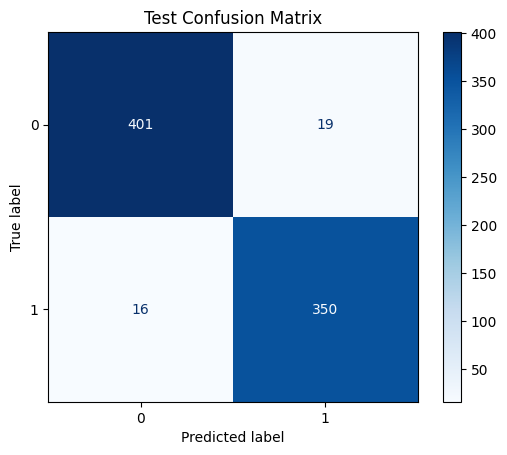

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.96      0.95      0.96       420
     Class 1       0.95      0.96      0.95       366

    accuracy                           0.96       786
   macro avg       0.96      0.96      0.96       786
weighted avg       0.96      0.96      0.96       786



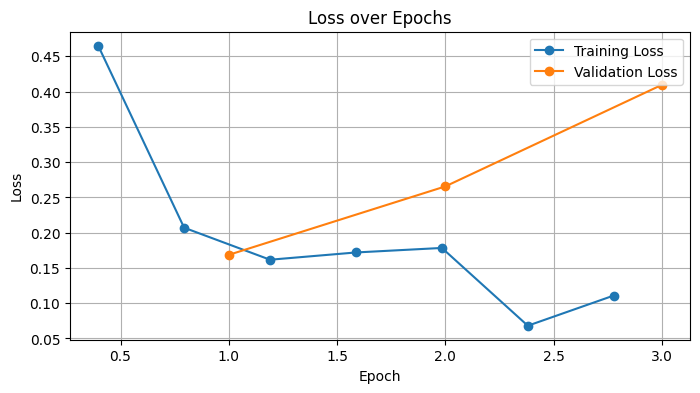

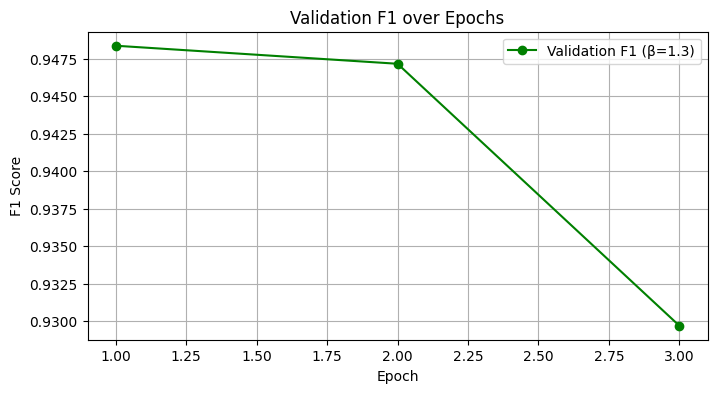

In [ ]:
import csv
import os
from datetime import datetime
import pandas as pd
import numpy as np
import torch
import random
import optuna
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    AutoConfig
)
from transformers.optimization import Adafactor
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, fbeta_score
import matplotlib.pyplot as plt
import torch.nn.functional as F
import optuna.visualization as vis

# -------------------------------
# 1. Set random seeds for reproducibility
# -------------------------------
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# -------------------------------
# 2. Function to print GPU memory (if available)
# -------------------------------
def print_gpu_memory():
    if torch.cuda.is_available():
        print(f"GPU Memory Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
        print(f"GPU Memory Cached: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

# -------------------------------
# 3. Load datasets
# -------------------------------
# train.csv: big dataset (2521 examples)
# valid.csv: final test set (786 examples)
train_full_df = pd.read_csv("data/train.csv")   # 2521 examples
test_df = pd.read_csv("data/valid.csv")           # 786 examples (final sealed test)

# Rename "labels" to "label" for consistency
train_full_df = train_full_df.rename(columns={"labels": "label"})
test_df = test_df.rename(columns={"labels": "label"})

# -------------------------------
# 4. Split train_full_df into train and validation subsets (80/20 split)
# -------------------------------
train_df, valid_df = train_test_split(
    train_full_df,
    test_size=0.2,  
    stratify=train_full_df["label"],  # maintain class distribution
    random_state=SEED
)

print("New train_df distribution:\n", train_df["label"].value_counts())
print("\nNew valid_df distribution:\n", valid_df["label"].value_counts())
print("\nTest set distribution (old valid.csv):\n", test_df["label"].value_counts())

# -------------------------------
# 5. Create a custom Dataset for tokenization
# -------------------------------
class VaccineDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer, max_length=384):
        self.texts = dataframe['text'].tolist()
        self.labels = dataframe['label'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        # Remove the batch dimension from each tensor
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# -------------------------------
# 6. Load the PubMedBERT tokenizer and set model name
# -------------------------------
model_name = "allenai/biomed_roberta_base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Create dataset instances
train_dataset = VaccineDataset(train_df, tokenizer, max_length=384)
valid_dataset = VaccineDataset(valid_df, tokenizer, max_length=384)
test_dataset  = VaccineDataset(test_df, tokenizer, max_length=384)

# -------------------------------
# 7. Define custom loss functions
# -------------------------------
def focal_loss(logits, targets, alpha=1, gamma=2):
    """
    Compute focal loss for multi-class classification.
    """
    ce_loss = F.cross_entropy(logits, targets, reduction='none')
    pt = torch.exp(-ce_loss)  # probability of correct classification
    focal_loss_val = alpha * ((1 - pt) ** gamma) * ce_loss
    return focal_loss_val.mean()

def dice_loss(logits, targets, smooth=1):
    """
    Compute dice loss for multi-class classification.
    """
    num_classes = logits.size(1)
    targets_one_hot = F.one_hot(targets, num_classes=num_classes).float()
    probs = torch.softmax(logits, dim=1)
    intersection = torch.sum(probs * targets_one_hot, dim=0)
    union = torch.sum(probs, dim=0) + torch.sum(targets_one_hot, dim=0)
    dice = (2 * intersection + smooth) / (union + smooth)
    return (1 - dice).mean()

# -------------------------------
# 8. Create a custom Trainer to use the combined loss
# -------------------------------
class CustomTrainer(Trainer):
    def __init__(self, alpha=0.33, beta=0.33, gamma=0.33, *args, **kwargs):
        """
        alpha, beta, gamma: weights for cross entropy, focal, and dice losses respectively.
        """
        super().__init__(*args, **kwargs)
        self.alpha_weight = alpha
        self.beta_weight = beta
        self.gamma_weight = gamma
        
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        ce_loss = F.cross_entropy(logits, labels)
        fl = focal_loss(logits, labels, alpha=1, gamma=2)
        dl = dice_loss(logits, labels)
        
        combined_loss = self.alpha_weight * ce_loss + self.beta_weight * fl + self.gamma_weight * dl
        
        return (combined_loss, outputs) if return_outputs else combined_loss

# -------------------------------
# 9. Define compute_metrics function for evaluation using Fβ (beta=1.3)
# -------------------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    fbeta = fbeta_score(labels, preds, beta=1.3, pos_label=1)
    return {"f1_beta": fbeta}

# -------------------------------
# 10. Define the objective function for Optuna
# -------------------------------
def objective(trial):
    # --- Optimisation des hyperparamètres ---
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 5e-5, log=True)
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.1)
    dropout = trial.suggest_float("dropout", 0.1, 0.4)
    batch_size = trial.suggest_categorical("batch_size", [4, 8, 16])
    optimizer_name = trial.suggest_categorical("optimizer", ["adamw", "adam", "adafactor"])

    # --- Pondération des loss custom ---
    alpha = trial.suggest_float("alpha", 0.1, 1.0)
    beta = trial.suggest_float("beta", 0.1, 1.0)
    gamma = trial.suggest_float("gamma", 0.1, 1.0)

    # Normalize so they sum to 1
    total = alpha + beta + gamma
    alpha /= total
    beta  /= total
    gamma /= total

    # --- Initialisation du modèle avec dropout modifié ---
    config = AutoConfig.from_pretrained(model_name)
    config.hidden_dropout_prob = dropout
    config.attention_probs_dropout_prob = dropout
    config.num_labels = 2

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        config=config,
        device_map='auto'
    )
    model.gradient_checkpointing_enable()

    # --- Choix de l'optimizer ---
    # Importer AdamW et Adam depuis torch.optim, Adafactor depuis transformers.optimization
    from torch.optim import AdamW, Adam # type: ignore

    # Mapper l'option de l'optimizer sur une valeur valide :
    if optimizer_name in ["adamw", "adam"]:
        optim_used = "adamw_torch"
    elif optimizer_name == "adafactor":
        optim_used = "adafactor"
    else:
        optim_used = "adamw_torch"  # valeur par défaut

    # --- TrainingArguments dynamiques ---
    training_args = TrainingArguments(
        output_dir="./results",
        eval_strategy="epoch",
        save_strategy="epoch",
        num_train_epochs=10,
        optim=optim_used,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        gradient_accumulation_steps=max(1, 16 // batch_size),  # simulate batch size 16
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        load_best_model_at_end=True,
        metric_for_best_model="f1_beta",
        logging_steps=50,
        seed=SEED,
        report_to=[],
        fp16=True,
        gradient_checkpointing=True
    )

    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
        alpha=alpha,
        beta=beta,
        gamma=gamma
    )

    trainer.train()
    eval_result = trainer.evaluate(valid_dataset)
    return eval_result.get("eval_f1_beta")

# -------------------------------
# 11. Run the Optuna study to optimize hyperparameters
# -------------------------------
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)  # Augmente n_trials pour une recherche plus exhaustive

print("Best trial:")
trial = study.best_trial
print("  F1_beta: {:.4f}".format(trial.value))
print("  Best hyperparameters: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# -------------------------------
# 12. Retrain final model using best hyperparameters and evaluate on the test set
# -------------------------------
best_lr = trial.params["learning_rate"]
best_wd = trial.params["weight_decay"]
best_alpha = trial.params["alpha"]
best_beta = trial.params["beta"]
best_gamma = trial.params["gamma"]

final_training_args = TrainingArguments(
    output_dir="./final_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    learning_rate=best_lr,
    weight_decay=best_wd,
    load_best_model_at_end=True,
    metric_for_best_model="f1_beta",
    logging_steps=50,
    seed=SEED,
    report_to=[],
    fp16=True,
    gradient_checkpointing=True
)

final_config = AutoConfig.from_pretrained(model_name, num_labels=2)
final_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    config=final_config,
    #device_map='auto'
)
final_model.gradient_checkpointing_enable()

final_trainer = CustomTrainer(
    model=final_model,
    args=final_training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,  # Tu peux combiner train et valid si besoin
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    alpha=best_alpha,
    beta=best_beta,
    gamma=best_gamma
)

final_trainer.train()

# Sauvegarder le meilleur modèle tout de suite après entraînement
final_model.save_pretrained("models/final_model")
tokenizer.save_pretrained("models/final_model")
print("✅ Best model and tokenizer saved to models/final_model")

# -------------------------------
# 13. Tune the best threshold on the validation dataset using Fβ (beta=1.3)
# -------------------------------
valid_predictions = final_trainer.predict(valid_dataset)
valid_logits = valid_predictions.predictions
valid_labels = valid_predictions.label_ids

valid_probs = torch.softmax(torch.tensor(valid_logits), dim=1)[:, 1].numpy()

best_fbeta = 0
best_thresh = 0.5
for thresh in np.arange(0, 1.01, 0.01):
    preds = (valid_probs >= thresh).astype(int)
    score = fbeta_score(valid_labels, preds, beta=1.3, pos_label=1)
    if score > best_fbeta:
        best_fbeta = score
        best_thresh = thresh

print(f"\n✅ Best threshold found on validation set: {best_thresh:.2f} (Fβ = {best_fbeta:.4f})")

# -------------------------------
# 14. Evaluate on the final test set using the best threshold
# -------------------------------
test_predictions = final_trainer.predict(test_dataset)
test_logits = test_predictions.predictions
test_labels = test_predictions.label_ids

test_probs = torch.softmax(torch.tensor(test_logits), dim=1)[:, 1].numpy()
test_preds = (test_probs >= best_thresh).astype(int)

test_f1 = f1_score(test_labels, test_preds, pos_label=1)
print(f"\nFinal Test F1 on old valid.csv using threshold {best_thresh:.2f} = {test_f1:.4f}")

# -------------------------------
# 15. Display the Confusion Matrix on the Test Set
# -------------------------------
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Test Confusion Matrix")
plt.show()

# -------------------------------
# 16. Print the Classification Report
# -------------------------------
report = classification_report(test_labels, test_preds, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)

# -------------------------------
# 16.5 Log experiment metadata and confusion matrix image
# -------------------------------
os.makedirs("evaluation", exist_ok=True)

# Fichier log
csv_file = "evaluation/experiment_logs.csv"

# Matrice de confusion
tn, fp, fn, tp = confusion_matrix(test_labels, test_preds).ravel()

# Coefficients bruts d'Optuna
alpha_raw = trial.params["alpha"]
beta_raw = trial.params["beta"]
gamma_raw = trial.params["gamma"]

# Normalisation
total = alpha_raw + beta_raw + gamma_raw
alpha_norm = alpha_raw / total
beta_norm = beta_raw / total
gamma_norm = gamma_raw / total

# Dictionnaire à logger
log_dict = {
    "datetime": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "model_name": model_name,
    "learning_rate": best_lr,
    "weight_decay": best_wd,
    "dropout": final_config.hidden_dropout_prob,
    "optimizer": trial.params["optimizer"],
    "batch_size": 8,
    "alpha_raw": alpha_raw,
    "beta_raw": beta_raw,
    "gamma_raw": gamma_raw,
    "alpha_norm": alpha_norm,
    "beta_norm": beta_norm,
    "gamma_norm": gamma_norm,
    "eval_f1_beta": best_fbeta,
    "best_threshold": best_thresh,
    "test_f1": test_f1,
    "test_precision": precision_score(test_labels, test_preds),
    "test_recall": recall_score(test_labels, test_preds),
    "test_f1_beta": fbeta_score(test_labels, test_preds, beta=1.3, pos_label=1),
    "confusion_TN": tn,
    "confusion_FP": fp,
    "confusion_FN": fn,
    "confusion_TP": tp,
}

# Enregistrement dans le CSV
file_exists = os.path.exists(csv_file)
with open(csv_file, mode='a', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=log_dict.keys())
    if not file_exists:
        writer.writeheader()
    writer.writerow(log_dict)

print(f"\n📄 Résultats enregistrés dans {csv_file}")

# Sauvegarder la matrice de confusion en image
plt.savefig(f"evaluation/confusion_matrix_trial_{trial.number}.png")
plt.close()
print("📊 Confusion matrix saved as image.")

# -------------------------------
# 17. (Optional) Plot learning curves if desired
# -------------------------------
train_logs = [log for log in final_trainer.state.log_history if "loss" in log and "eval_loss" not in log]
eval_logs = [log for log in final_trainer.state.log_history if "eval_loss" in log]

train_epochs = [log["epoch"] for log in train_logs]
train_loss = [log["loss"] for log in train_logs]

eval_epochs = [log["epoch"] for log in eval_logs]
eval_loss = [log["eval_loss"] for log in eval_logs]
eval_f1 = [log["eval_f1_beta"] for log in eval_logs]

plt.figure(figsize=(8, 4))
plt.plot(train_epochs, train_loss, marker='o', label="Training Loss")
plt.plot(eval_epochs, eval_loss, marker='o', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(eval_epochs, eval_f1, marker='o', color='green', label="Validation F1 (β=1.3)")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation F1 over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# 18. Visualize Optuna study results
# -------------------------------

vis.plot_optimization_history(study).show()
vis.plot_param_importances(study).show()


## Gemini 2.5 Optuna + 3 loss functions

In [ ]:
import csv
import os
import re
from datetime import datetime
import pandas as pd
import numpy as np
import torch
import random
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import StratifiedKFold, train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    AutoConfig
)
# Note: AdamW is typically imported from torch.optim, Adafactor from transformers
from torch.optim import AdamW
from transformers.optimization import Adafactor
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, fbeta_score
import matplotlib.pyplot as plt
import torch.nn.functional as F
import optuna.visualization as vis # For Optuna plots
import gc # Garbage collector for explicit memory clearing

# -------------------------------
# 1. Set random seeds for reproducibility
# -------------------------------
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
# Ensure deterministic operations if possible (may impact performance)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
BETA = 1.3 # Fβ score with β=1.3

# -------------------------------
# 2. Function to print GPU memory (if available)
# -------------------------------
def print_gpu_memory(stage=""):
    if torch.cuda.is_available():
        print(f"GPU Memory ({stage}):")
        print(f"  Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
        print(f"  Reserved:  {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

# -------------------------------
# 3. Load datasets
# -------------------------------
print("Loading data...")
# train_full_df: Used for CV during Optuna and final model training (2521 examples)
# test_df: The final hold-out set for evaluation (786 examples, originally valid.csv)
train_full_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/valid.csv") # This is our final test set

# Rename "labels" to "label" for consistency
train_full_df = train_full_df.rename(columns={"labels": "label"})
test_df = test_df.rename(columns={"labels": "label"})

print(f"Train data shape: {train_full_df.shape}")
print(f"Test data shape: {test_df.shape}")
print("Train label distribution:\n", train_full_df['label'].value_counts(normalize=True))
print("Test label distribution:\n", test_df['label'].value_counts(normalize=True))

# -------------------------------
# 4. Preprocess Text: Handle "Title: Comment" structure
# -------------------------------
def preprocess_text(text):
    """Extracts the comment part if a 'title: comment' structure is detected."""
    if not isinstance(text, str):
        return "" # Handle potential non-string data
    # Look for pattern: "Short Title : Comment text"
    # Adjust the title length limit (e.g., 150) if needed based on data inspection
    match = re.match(r"^(.*?):\s*(.*)$", text, re.DOTALL) # re.DOTALL allows '.' to match newline
    if match and len(match.group(1)) < 150 and len(match.group(2)) > 10: # Basic heuristics
        return match.group(2).strip()
    else:
        # Assume the whole text is the relevant post/comment
        return text.strip()

print("Preprocessing text...")
train_full_df['text_processed'] = train_full_df['text'].apply(preprocess_text)
test_df['text_processed'] = test_df['text'].apply(preprocess_text)

# Display some examples
print("\nSample preprocessed texts (Train):")
print(train_full_df[['text', 'text_processed']].head())

# -------------------------------
# 5. Create a custom Dataset for tokenization
# -------------------------------
class VaccineDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer, max_length=384, text_column='text_processed'):
        # Ensure labels are integers
        self.labels = dataframe['label'].astype(int).tolist()
        # Ensure texts are strings
        self.texts = dataframe[text_column].astype(str).tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        # Remove the batch dimension from each tensor
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        # Ensure label is a tensor of type long
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# -------------------------------
# 6. Load the Tokenizer and define Model Name
# -------------------------------
# Starting with BioMed RoBERTa Base, but could be made an Optuna parameter
#MODEL_NAME = "allenai/biomed_roberta_base"
#MODEL_NAME = "microsoft/deberta-v3-small" # Smaller model for faster training
MODEL_NAME = "microsoft/deberta-v3-base"
# Alternative: MODEL_NAME = "roberta-large" # Benchmark model type
# Alternative: MODEL_NAME = "microsoft/deberta-v3-base"
# Alternative: MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest" # Social media specific

print(f"Loading tokenizer for {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Determine max length dynamically (optional, but good practice)
# all_texts = pd.concat([train_full_df['text_processed'], test_df['text_processed']]).tolist()
# token_lengths = [len(tokenizer.encode(text)) for text in all_texts]
# MAX_LENGTH = int(np.percentile(token_lengths, 98)) # Cover 98% of posts
# print(f"Calculated Max Length (98th percentile): {MAX_LENGTH}")
# Hardcoding for now based on initial code:
MAX_LENGTH = 384
print(f"Using Max Length: {MAX_LENGTH}")


# -------------------------------
# 7. Define custom loss functions (if using combined loss)
# -------------------------------
def focal_loss(logits, targets, alpha=1, gamma=2, reduction='mean'):
    """
    Compute focal loss for multi-class classification.
    alpha: Weighting factor for balancing classes (can be float or tensor).
    gamma: Focusing parameter.
    """
    ce_loss = F.cross_entropy(logits, targets, reduction='none')
    pt = torch.exp(-ce_loss)  # probability of correct class
    focal_loss_val = alpha * ((1 - pt) ** gamma) * ce_loss

    if reduction == 'mean':
        return focal_loss_val.mean()
    elif reduction == 'sum':
        return focal_loss_val.sum()
    else:
        return focal_loss_val

def dice_loss(logits, targets, smooth=1.0, reduction='mean'):
    """
    Compute dice loss for multi-class classification.
    """
    num_classes = logits.size(1)
    targets_one_hot = F.one_hot(targets, num_classes=num_classes).float()
    probs = torch.softmax(logits, dim=1)

    # Sum over all dimensions except the class dimension
    dims = tuple(range(len(probs.shape)))[1:] # Exclude batch dim if present, but logits are usually (batch, classes)
    if len(probs.shape) > 2: # If spatial dims exist (not typical for text cls)
      dims = tuple(range(len(probs.shape)))[2:]

    intersection = torch.sum(probs * targets_one_hot, dim=dims)
    cardinality = torch.sum(probs, dim=dims) + torch.sum(targets_one_hot, dim=dims)

    dice_score = (2. * intersection + smooth) / (cardinality + smooth)

    dice_loss_val = 1. - dice_score

    if reduction == 'mean':
        # Average loss across classes and then batch
        return dice_loss_val.mean()
    elif reduction == 'sum':
        return dice_loss_val.sum()
    else: # none
        return dice_loss_val


# -------------------------------
# 8. Create a custom Trainer to use the combined loss
# -------------------------------
class CustomTrainer(Trainer):
    def __init__(self, alpha=0.33, beta=0.33, gamma_weight=0.33, focal_gamma=2.0, focal_alpha=1.0, *args, **kwargs):
        """
        alpha: weight for cross entropy loss.
        beta: weight for focal loss.
        gamma_weight: weight for dice loss.
        focal_gamma: gamma parameter for focal loss itself.
        focal_alpha: alpha parameter for focal loss itself (class weighting).
        """
        super().__init__(*args, **kwargs)
        self.alpha_weight = alpha
        self.beta_weight = beta
        self.gamma_weight_dice = gamma_weight # Renamed to avoid confusion with focal_gamma
        self.focal_gamma = focal_gamma
        self.focal_alpha = focal_alpha # Can be adjusted for class imbalance

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_ce = F.cross_entropy(logits, labels)
        loss_fl = focal_loss(logits, labels, alpha=self.focal_alpha, gamma=self.focal_gamma)
        loss_dl = dice_loss(logits, labels)

        # Ensure weights sum to 1 (or are used as relative factors)
        # This normalization happens *before* calling the trainer in Optuna obj
        combined_loss = (self.alpha_weight * loss_ce +
                         self.beta_weight * loss_fl +
                         self.gamma_weight_dice * loss_dl)

        return (combined_loss, outputs) if return_outputs else combined_loss

# -------------------------------
# 9. Define compute_metrics function for evaluation (using F1 score)
# -------------------------------
def compute_metrics(eval_pred):
    """
    Computes F1-beta score (β=1.3) for the positive class (label = 1).
    This is the official metric used for SMM4H 2025 Task 6.
    """
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    f1_beta = fbeta_score(labels, preds, beta=BETA, pos_label=1, average='binary')
    precision = precision_score(labels, preds, pos_label=1, average='binary')
    recall = recall_score(labels, preds, pos_label=1, average='binary')

    return {
        "f1": f1_beta,  # <- F1-beta used by Trainer to select best model
        "f1_beta_1.3": f1_beta, # <- Additional metric for clarity in log_history
        "precision": precision,
        "recall": recall,
    }

# -------------------------------
# 9b. Tune threshold helper function (for best F1)
# -------------------------------

def tune_threshold(trainer, dataset):
    """
    Finds the best threshold maximizing F1 score (class 1) on the provided dataset.
    Returns (best_threshold, best_f1).
    """
    predictions = trainer.predict(dataset)
    logits = predictions.predictions
    labels = predictions.label_ids
    probs = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()

    best_thresh = 0.5
    best_f1 = 0.0

    for thresh in np.arange(0.01, 1.0, 0.01):
        preds = (probs >= thresh).astype(int)
        f1 = fbeta_score(labels, preds, beta=BETA, pos_label=1, average='binary')
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh

    return best_thresh, best_f1

# -------------------------------
# 10. Define the objective function for Optuna (with Cross-Validation)
# -------------------------------
N_SPLITS = 5 # Number of folds for Stratified K-Fold Cross-Validation
N_TRIALS = 70 # Number of Optuna trials to run
N_EPOCHS_OPTUNA = 8 # Number of epochs per fold during Optuna (can be reduced from final)
PATIENCE_OPTUNA = 2 # Early stopping patience during Optuna

# Ensure train_full_df has clean indices for KFold splitting
train_full_df = train_full_df.reset_index(drop=True)

def objective(trial):
    print_gpu_memory(f"Start Trial {trial.number}")

    # --- Hyperparameter Search Space ---
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 7e-5, log=True)
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.1)
    dropout = trial.suggest_float("dropout", 0.05, 0.35)
    # Larger batch sizes possible with gradient accumulation
    per_device_batch_size = trial.suggest_categorical("batch_size", [4, 8, 12]) # Smaller options
    # Effective batch size target (adjust based on GPU memory)
    target_eff_batch_size = 16 # e.g. Accumulate 4 steps if batch_size=4
    gradient_accumulation_steps = max(1, target_eff_batch_size // per_device_batch_size)

    # Optimizer choice
    optimizer_name = trial.suggest_categorical("optimizer", ["adamw", "adafactor"])

    # Loss combination weights
    # Let Optuna find the best mix, ensuring they sum to 1
    loss_weight_ce = trial.suggest_float("loss_weight_ce", 0.1, 1.0)
    loss_weight_focal = trial.suggest_float("loss_weight_focal", 0.1, 1.0)
    loss_weight_dice = trial.suggest_float("loss_weight_dice", 0.0, 1.0) # Allow zero weight

    # Normalize loss weights
    total_weight = loss_weight_ce + loss_weight_focal + loss_weight_dice
    norm_alpha = loss_weight_ce / total_weight
    norm_beta = loss_weight_focal / total_weight
    norm_gamma_dice = loss_weight_dice / total_weight

    # Focal Loss specific parameters (if using focal loss, i.e., norm_beta > 0)
    focal_gamma_param = trial.suggest_float("focal_gamma", 1.0, 3.0)
    # focal_alpha_param = trial.suggest_float("focal_alpha", 0.25, 1.0) # Can tune class weight

    # Label smoothing
    label_smoothing_factor = trial.suggest_float("label_smoothing_factor", 0.0, 0.15)

    # --- Cross-Validation Setup ---
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    fold_f1_scores = []

    print(f"\n--- Trial {trial.number} ---")
    print(f"  LR: {learning_rate:.2e}, WD: {weight_decay:.3f}, Dropout: {dropout:.3f}, BS: {per_device_batch_size}, Accum: {gradient_accumulation_steps}")
    print(f"  Optim: {optimizer_name}, LabelSmooth: {label_smoothing_factor:.3f}")
    print(f"  Loss Weights (Norm): CE={norm_alpha:.3f}, Focal={norm_beta:.3f}, Dice={norm_gamma_dice:.3f}")
    if norm_beta > 0.01: print(f"  Focal Gamma: {focal_gamma_param:.3f}")


    for fold, (train_idx, val_idx) in enumerate(skf.split(train_full_df['text_processed'], train_full_df['label'])):
        print(f"--- Starting Fold {fold+1}/{N_SPLITS} for Trial {trial.number} ---")

        # Create fold-specific datasets
        train_fold_df = train_full_df.iloc[train_idx]
        valid_fold_df = train_full_df.iloc[val_idx]

        train_fold_dataset = VaccineDataset(train_fold_df, tokenizer, max_length=MAX_LENGTH)
        valid_fold_dataset = VaccineDataset(valid_fold_df, tokenizer, max_length=MAX_LENGTH)

        # --- Model Config (inside loop to reset weights) ---
        config = AutoConfig.from_pretrained(MODEL_NAME)
        config.hidden_dropout_prob = dropout
        config.attention_probs_dropout_prob = dropout
        config.num_labels = 2

        model = AutoModelForSequenceClassification.from_pretrained(
            MODEL_NAME,
            config=config,
            # ignore_mismatched_sizes=True # Add if switching between base/large models causes issues
        )
        # Enable gradient checkpointing for memory saving, esp. with larger models/batch sizes
        if per_device_batch_size < 16: # Heuristic: more likely needed for smaller batches if accumulating
             model.gradient_checkpointing_enable()

        # --- Optimizer Selection ---
        optim_to_use = "adamw_torch" # Default
        if optimizer_name == "adafactor":
            optim_to_use = "adafactor"

        # --- Training Arguments ---
        training_args = TrainingArguments(
            output_dir=f"./results_optuna/trial_{trial.number}_fold_{fold}", # Unique output dir per fold
            num_train_epochs=N_EPOCHS_OPTUNA,
            per_device_train_batch_size=per_device_batch_size,
            per_device_eval_batch_size=per_device_batch_size * 2, # Usually possible
            gradient_accumulation_steps=gradient_accumulation_steps,
            learning_rate=learning_rate,
            weight_decay=weight_decay,
            optim=optim_to_use,
            evaluation_strategy="epoch", # Evaluate each epoch
            logging_strategy="epoch",   # Log each epoch
            save_strategy="epoch",      # Save potentially each epoch
            load_best_model_at_end=True,# Load the best model based on metric
            metric_for_best_model="f1", # Optimize for F1 score
            greater_is_better=True,
            save_total_limit=1,         # Only keep the best checkpoint
            label_smoothing_factor=label_smoothing_factor,
            fp16=torch.cuda.is_available(), # Enable mixed precision if GPU available
            gradient_checkpointing= (per_device_batch_size < 16), # Match model setting
            report_to=[], # Disable default reporting (wandb, tensorboard etc.)
            seed=SEED + fold, # Vary seed slightly per fold
        )

        # --- Trainer ---
        trainer = CustomTrainer(
            model=model,
            args=training_args,
            train_dataset=train_fold_dataset,
            eval_dataset=valid_fold_dataset,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=PATIENCE_OPTUNA)],
            # Pass normalized loss weights and focal gamma
            alpha=norm_alpha,
            beta=norm_beta,
            gamma_weight=norm_gamma_dice,
            focal_gamma=focal_gamma_param,
            # focal_alpha=focal_alpha_param # Pass if tuning focal alpha
        )

        # --- Train & Evaluate Fold ---
        try:
            print_gpu_memory(f"Trial {trial.number} Fold {fold+1} Pre-Train")
            trainer.train()
            eval_result = trainer.evaluate(valid_fold_dataset)
            fold_f1 = eval_result.get("eval_f1", 0.0) # Get F1 score
            fold_f1_scores.append(fold_f1)
            print(f"Fold {fold+1} Eval F1: {fold_f1:.4f}")
            print_gpu_memory(f"Trial {trial.number} Fold {fold+1} Post-Eval")

            # 🚫 HARD PRUNING: if a fold performs way below acceptable level, stop early
            MIN_ACCEPTABLE_F1 = 0.84
            if fold_f1 < MIN_ACCEPTABLE_F1:
                print(f"⛔️ Trial {trial.number} Fold {fold+1} too weak (F1={fold_f1:.4f}) → Hard pruning.")
                trial.report(fold_f1, fold)
                trial.set_user_attr("prune_reason", "F1_below_threshold = 0.84")
                raise optuna.exceptions.TrialPruned()

            # --- Optuna Pruning ---
            trial.report(fold_f1, fold)
            if trial.should_prune():
                # Clean up before pruning
                del model, trainer, train_fold_dataset, valid_fold_dataset
                gc.collect()
                torch.cuda.empty_cache()
                print(f"Trial {trial.number} Fold {fold+1} Pruned.")
                raise optuna.exceptions.TrialPruned()

        except Exception as e:
            print(f"!!! Error during Trial {trial.number} Fold {fold+1}: {e}")
            # Clean up memory even if error occurs
            for var_name in ['model', 'trainer', 'train_fold_dataset', 'valid_fold_dataset']:
                if var_name in locals():
                    del locals()[var_name]
            gc.collect()
            torch.cuda.empty_cache()
            fold_f1_scores.append(0.0)  # Penalize this fold

        else:
            # --- Clean up GPU memory after each successful fold ---
            for var_name in ['model', 'trainer', 'train_fold_dataset', 'valid_fold_dataset']:
                if var_name in locals():
                    del locals()[var_name]
            gc.collect()
            torch.cuda.empty_cache()
            print_gpu_memory(f"Trial {trial.number} Fold {fold+1} Cleaned")


    # --- Average F1 across folds ---
    if not fold_f1_scores: # Handle case where all folds might have failed or pruned early
        average_f1 = 0.0
    else:
        average_f1 = np.mean(fold_f1_scores)

    print(f"--- Trial {trial.number} Finished --- Average CV F1: {average_f1:.4f}")
    # Store CV scores in trial user attributes for later inspection if needed
    trial.set_user_attr("cv_scores", fold_f1_scores)

    return average_f1 # Optuna maximizes this average F1

# -------------------------------
# 11. Run the Optuna study to optimize hyperparameters
# -------------------------------
print("\n--- Starting Optuna Hyperparameter Optimization ---")
# Define study - consider SQLite for persistence: storage="sqlite:///optuna_study.db"
study = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(n_startup_trials=10, multivariate=True, group=True, seed=SEED), # TPE with Multivariate and Grouping
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=N_SPLITS // 2) # Prune after half the folds if poor
)
study.optimize(objective, n_trials=N_TRIALS, timeout=None) # Adjust n_trials or add timeout (seconds)

print("\n--- Optuna Study Complete ---")
print("Number of finished trials: ", len(study.trials))

best_trial = study.best_trial
print("Best trial:")
print(f"  Value (Average CV F1): {best_trial.value:.4f}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# -------------------------------
# 12. Retrain final model using best hyperparameters on ALL training data
# -------------------------------
print("\n--- Training Final Model with Best Hyperparameters ---")

best_params = best_trial.params

# Extract best hyperparams
final_lr = best_params["learning_rate"]
final_wd = best_params["weight_decay"]
final_dropout = best_params["dropout"]
final_batch_size = best_params["batch_size"]
final_optimizer = best_params["optimizer"]
final_label_smoothing = best_params["label_smoothing_factor"]

# Extract and normalize loss weights
final_loss_ce = best_params["loss_weight_ce"]
final_loss_focal = best_params["loss_weight_focal"]
final_loss_dice = best_params["loss_weight_dice"]
final_total_weight = final_loss_ce + final_loss_focal + final_loss_dice
final_norm_alpha = final_loss_ce / final_total_weight
final_norm_beta = final_loss_focal / final_total_weight
final_norm_gamma_dice = final_loss_dice / final_total_weight
final_focal_gamma = best_params.get("focal_gamma", 2.0) # Use default if not tuned

# Effective batch size target for final training
final_target_eff_batch_size = 16 # Keep consistent or adjust
final_gradient_accumulation = max(1, final_target_eff_batch_size // final_batch_size)

# For final training, we use all train_full_df.
# We still need a small validation set for early stopping and saving the best model.
# Split off 10% of train_full_df *just* for this purpose.
final_train_df, final_valid_df = train_test_split(
    train_full_df,
    test_size=0.1, # Small validation set for final training phase
    stratify=train_full_df["label"],
    random_state=SEED
)

final_train_dataset = VaccineDataset(final_train_df, tokenizer, max_length=MAX_LENGTH)
final_valid_dataset = VaccineDataset(final_valid_df, tokenizer, max_length=MAX_LENGTH) # Used for ES

# Final Model Config
final_config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=2)
final_config.hidden_dropout_prob = final_dropout
final_config.attention_probs_dropout_prob = final_dropout

final_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    config=final_config,
    # ignore_mismatched_sizes=True
)
# Enable gradient checkpointing if necessary based on final batch size
if final_batch_size < 16:
    final_model.gradient_checkpointing_enable()

# Final Training Arguments
N_EPOCHS_FINAL = 12 # Allow slightly more epochs for final training
PATIENCE_FINAL = 3  # Slightly more patience for final training

final_optim_to_use = "adamw_torch" if final_optimizer == "adamw" else "adafactor"

final_training_args = TrainingArguments(
    output_dir="./final_model_training_output",
    num_train_epochs=N_EPOCHS_FINAL,
    per_device_train_batch_size=final_batch_size,
    per_device_eval_batch_size=final_batch_size * 2,
    gradient_accumulation_steps=final_gradient_accumulation,
    learning_rate=final_lr,
    weight_decay=final_wd,
    optim=final_optim_to_use,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1", # Actually F1-beta(1.3), see compute_metrics
    greater_is_better=True,
    save_total_limit=1,
    label_smoothing_factor=final_label_smoothing,
    fp16=torch.cuda.is_available(),
    gradient_checkpointing= (final_batch_size < 16),
    report_to=[],
    seed=SEED,
)

# Final Trainer
final_trainer = CustomTrainer(
    model=final_model,
    args=final_training_args,
    train_dataset=final_train_dataset, # Train on 90%
    eval_dataset=final_valid_dataset, # Validate on 10% for ES/saving best
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=PATIENCE_FINAL)],
    # Pass best normalized loss weights and focal gamma
    alpha=final_norm_alpha,
    beta=final_norm_beta,
    gamma_weight=final_norm_gamma_dice,
    focal_gamma=final_focal_gamma,
)

print_gpu_memory("Before Final Train")
final_trainer.train()
print_gpu_memory("After Final Train")

# Best model is now loaded in final_trainer.model

# Save the final best model and tokenizer
FINAL_MODEL_SAVE_PATH = "models/final_best_model"
print(f"Saving final best model to {FINAL_MODEL_SAVE_PATH}...")
final_trainer.save_model(FINAL_MODEL_SAVE_PATH)
tokenizer.save_pretrained(FINAL_MODEL_SAVE_PATH)
print(f"✅ Final best model and tokenizer saved to {FINAL_MODEL_SAVE_PATH}")

# -------------------------------
# 13. Tune the best threshold on the validation set used during final training
# -------------------------------
print("\n--- Tuning Prediction Threshold ---")

# Appelle la fonction helper qu’on a ajoutée plus tôt
best_thresh, best_f1_thresh = tune_threshold(final_trainer, final_valid_dataset)

print(f"✅ Best threshold found on validation split: {best_thresh:.2f} (yields F1 = {best_f1_thresh:.4f})")

# Sauvegarde dans le dossier du modèle
with open(os.path.join(FINAL_MODEL_SAVE_PATH, "threshold.txt"), "w") as f:
    f.write(f"{best_thresh:.4f}")

with open(os.path.join(FINAL_MODEL_SAVE_PATH, "validation_fbeta_1.3.txt"), "w") as f:
    f.write(f"{best_f1_thresh:.4f}")


# -------------------------------
# 14. Evaluate on the final hold-out test set using the best threshold
# -------------------------------
print("\n--- Evaluating on Final Hold-Out Test Set ---")
# Ensure test_df is preprocessed and create dataset
test_dataset = VaccineDataset(test_df, tokenizer, max_length=MAX_LENGTH, text_column='text_processed')

# Get predictions from the final model
test_predictions = final_trainer.predict(test_dataset)
test_logits = test_predictions.predictions
test_labels = test_predictions.label_ids # True labels from the test set

# Calculate probabilities and apply the best threshold found earlier
test_probs = torch.softmax(torch.tensor(test_logits), dim=1)[:, 1].numpy()
test_preds_final = (test_probs >= best_thresh).astype(int)

# Calculate final metrics on the test set
final_test_f1 = f1_score(test_labels, test_preds_final, pos_label=1, average='binary')
final_test_precision = precision_score(test_labels, test_preds_final, pos_label=1, average='binary')
final_test_recall = recall_score(test_labels, test_preds_final, pos_label=1, average='binary')
# Calculate F-beta with beta=1.3 as well for comparison/interest
final_test_fbeta = fbeta_score(test_labels, test_preds_final, beta=1.3, pos_label=1, average='binary')

print("\n--- Final Test Set Performance ---")
print(f"  Threshold used: {best_thresh:.2f}")
print(f"  F1 Score (pos class): {final_test_f1:.4f}")
print(f"  Precision (pos class): {final_test_precision:.4f}")
print(f"  Recall (pos class):    {final_test_recall:.4f}")
print(f"  F-beta (beta=1.3):   {final_test_fbeta:.4f}")

with open(os.path.join(FINAL_MODEL_SAVE_PATH, "test_fbeta_1.3.txt"), "w") as f:
    f.write(f"{final_test_fbeta:.4f}")

# -------------------------------
# 15. Display the Confusion Matrix on the Test Set
# -------------------------------
print("\nGenerating Confusion Matrix...")
cm = confusion_matrix(test_labels, test_preds_final, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap="Blues")
plt.title("Final Test Set Confusion Matrix")
# Ensure evaluation directory exists
os.makedirs("evaluation", exist_ok=True)
plt.savefig(f"evaluation/confusion_matrix_final_run.png")
plt.show() # Display the plot
print("Confusion matrix saved to evaluation/confusion_matrix_final_run.png")

# -------------------------------
# 16. Print the Classification Report
# -------------------------------
print("\nClassification Report (Test Set):\n")
report = classification_report(test_labels, test_preds_final, target_names=["Class 0", "Class 1"], digits=4)
print(report)

# -------------------------------
# 16.5 Log experiment metadata and results
# -------------------------------
print("Logging results...")
csv_file = "evaluation/experiment_logs.csv"
log_dict = {
    "datetime": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "model_name": MODEL_NAME,
    "final_learning_rate": final_lr,
    "final_weight_decay": final_wd,
    "final_dropout": final_dropout,
    "final_optimizer": final_optimizer,
    "final_batch_size": final_batch_size,
    "final_grad_accum": final_gradient_accumulation,
    "label_smoothing": final_label_smoothing,
    # Raw loss weights from Optuna
    "optuna_raw_loss_ce": final_loss_ce,
    "optuna_raw_loss_focal": final_loss_focal,
    "optuna_raw_loss_dice": final_loss_dice,
    # Normalized loss weights used in training
    "norm_loss_weight_ce": final_norm_alpha,
    "norm_loss_weight_focal": final_norm_beta,
    "norm_loss_weight_dice": final_norm_gamma_dice,
    "focal_gamma": final_focal_gamma if final_norm_beta > 0.01 else "N/A",
    "optuna_cv_f1_avg": best_trial.value,
    "best_threshold_on_valid_split": best_thresh,
    "fbeta_1.3_on_valid_split": best_f1_thresh,
    "test_f1": final_test_f1,
    "test_precision": final_test_precision,
    "test_recall": final_test_recall,
    "test_fbeta_1.3": final_test_fbeta,
    "confusion_TN": tn,
    "confusion_FP": fp,
    "confusion_FN": fn,
    "confusion_TP": tp,
    "optuna_n_trials": N_TRIALS,
    "optuna_n_splits_cv": N_SPLITS,
    "max_seq_length": MAX_LENGTH,
    "seed": SEED,
}

# Append to CSV
file_exists = os.path.exists(csv_file)
with open(csv_file, mode='a', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=log_dict.keys())
    if not file_exists or os.path.getsize(csv_file) == 0:
        writer.writeheader() # Write header only if file is new or empty
    writer.writerow(log_dict)

print(f"📄 Final results logged to {csv_file}")

# -------------------------------
# 17. Plot learning curves from the FINAL training phase
# -------------------------------
print("Generating learning curves from final training...")
train_logs = [log for log in final_trainer.state.log_history if 'loss' in log]
eval_logs = [log for log in final_trainer.state.log_history if 'eval_loss' in log]

if train_logs and eval_logs:
    # Extract epochs and metrics, handling potential variations in logging steps
    train_epochs = [log['epoch'] for log in train_logs if 'epoch' in log]
    train_loss = [log['loss'] for log in train_logs if 'loss' in log]

    eval_epochs = [log['epoch'] for log in eval_logs if 'epoch' in log]
    eval_loss = [log['eval_loss'] for log in eval_logs if 'eval_loss' in log]
    eval_f1 = [log['eval_f1'] for log in eval_logs if 'eval_f1' in log]

    # Ensure lengths match for plotting (might differ slightly due to logging timing)
    min_len = min(len(train_epochs), len(eval_epochs))

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_epochs[:min_len], train_loss[:min_len], marker='o', linestyle='-', label="Training Loss")
    plt.plot(eval_epochs[:min_len], eval_loss[:min_len], marker='o', linestyle='-', label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Final Training: Loss Curves")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(eval_epochs, eval_f1, marker='o', linestyle='-', color='green', label="Validation F1")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score (Positive Class)")
    plt.title("Final Training: Validation F1")
    # Highlight the epoch where the best score occurred (if easily available)
    best_epoch_log = final_trainer.state.best_metric # state.best_model_checkpoint might hold path
    if final_trainer.state.best_metric is not None:
        best_f1_val = final_trainer.state.best_metric
        # Find epoch corresponding to best metric (approximate)
        best_epoch_idx = np.argmax(eval_f1)
        best_epoch = eval_epochs[best_epoch_idx]
        plt.scatter([best_epoch], [best_f1_val], color='red', s=100, label=f'Best F1 ({best_f1_val:.4f})', zorder=5)

    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("evaluation/learning_curves_final_run.png")
    plt.show()
    print("Learning curves saved to evaluation/learning_curves_final_run.png")
else:
    print("Could not generate learning curves: Log history incomplete.")


# -------------------------------
# 18. Visualize Optuna study results
# -------------------------------
print("Generating Optuna visualization plots...")
try:
    fig1 = vis.plot_optimization_history(study)
    fig1.show()
    fig1.write_image("evaluation/optuna_optimization_history.png")

    fig2 = vis.plot_param_importances(study)
    fig2.show()
    fig2.write_image("evaluation/optuna_param_importances.png")

    # Requires plotly installed
    # fig3 = vis.plot_slice(study, params=["learning_rate", "dropout", "weight_decay"])
    # fig3.show()
    # fig3.write_image("evaluation/optuna_slice_plot.png")

    print("Optuna plots saved to evaluation/ directory.")

except Exception as e:
    print(f"Could not generate Optuna plots: {e}. (Ensure plotly and kaleido are installed)")


print("\n--- Script Finished ---")


Loading data...
Train data shape: (2521, 3)
Test data shape: (786, 3)
Train label distribution:
 label
0    0.544228
1    0.455772
Name: proportion, dtype: float64
Test label distribution:
 label
0    0.534351
1    0.465649
Name: proportion, dtype: float64
Preprocessing text...

Sample preprocessed texts (Train):
                                                text  \
0  Shingles Vaccine: Warning, this post contains ...   
1  Going to get my 2nd shingles shot in 15 minute...   
2  Just got my flu shot and now experiencing some...   
3  Has anyone experienced a strong reaction to th...   
4  Getting two vaccines at once: I have a very re...   

                                      text_processed  
0  Warning, this post contains an optimistic anti...  
1  second one didn't make me sick but I had a GIG...  
2  Just got my flu shot and now experiencing some...  
3  Has anyone experienced a strong reaction to th...  
4  I have a very reactive immune system. 1 vaccin...  
Loading tokenizer

c:\Users\Olivier\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
c:\Users\Olivier\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\Olivier\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2

Using Max Length: 384

--- Starting Optuna Hyperparameter Optimization ---
GPU Memory (Start Trial 0):
  Allocated: 0.00 MB
  Reserved:  0.00 MB

--- Trial 0 ---
  LR: 4.91e-06, WD: 0.095, Dropout: 0.270, BS: 4, Accum: 4
  Optim: adafactor, LabelSmooth: 0.125
  Loss Weights (Norm): CE=0.458, Focal=0.527, Dice=0.015
  Focal Gamma: 2.940
--- Starting Fold 1/5 for Trial 0 ---


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Olivier\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


GPU Memory (Trial 0 Fold 1 Pre-Train):
  Allocated: 704.73 MB
  Reserved:  758.00 MB


Epoch,Training Loss,Validation Loss,F1,F1 Beta 1.3,Precision,Recall
1,0.370800,0.361978,0.735375,0.735375,0.937500,0.652174
2,0.282000,0.418731,0.715508,0.715508,0.483193,1.000000
3,0.181700,0.583089,0.742113,0.742113,0.516854,1.000000


[W 2025-03-27 03:33:22,501] Trial 0 failed with parameters: {'learning_rate': 4.909793642305902e-06, 'weight_decay': 0.09507143064099162, 'dropout': 0.26959818254342155, 'batch_size': 4, 'optimizer': 'adafactor', 'loss_weight_ce': 0.6410035105688879, 'loss_weight_focal': 0.737265320016441, 'loss_weight_dice': 0.020584494295802447, 'focal_gamma': 2.9398197043239884, 'label_smoothing_factor': 0.12486639612006326} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\Olivier\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Olivier\AppData\Local\Temp\ipykernel_33020\2425270979.py", line 408, in objective
    trainer.train()
  File "c:\Users\Olivier\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py", line 2245, in train
    return inner_training_loop(
           ^^^

KeyboardInterrupt: 

## REFACTOR COMPLET GEMINI 2.5

In [ ]:
import csv
import os
import re
import traceback # Added for potentially more detailed error printing
from datetime import datetime
import pandas as pd
import numpy as np
import torch
import random
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import StratifiedKFold, train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    AutoConfig,
    TrainerCallback,         # <-- Import base callback
    TrainerState,            # <-- Import TrainerState
    TrainerControl           # <-- Import TrainerControl
)
# Note: AdamW is typically imported from torch.optim, Adafactor from transformers
from torch.optim import AdamW
from transformers.optimization import Adafactor
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, fbeta_score
import matplotlib.pyplot as plt
import torch.nn.functional as F
import optuna.visualization as vis # For Optuna plots
import gc # Garbage collector for explicit memory clearing

# -------------------------------
# 1. Set random seeds for reproducibility
# -------------------------------
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
# Define the Beta value for F-beta score (as specified by the competition)
BETA = 1.3

# -------------------------------
# 2. Function to print GPU memory (if available)
# -------------------------------
def print_gpu_memory(stage=""):
    if torch.cuda.is_available():
        print(f"GPU Memory ({stage}):")
        print(f"  Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
        print(f"  Reserved:  {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

# -------------------------------
# 3. Load datasets
# -------------------------------
print("Loading data...")
try:
    train_full_df = pd.read_csv("data/train.csv")
    test_df = pd.read_csv("data/valid.csv") # This is our final test set
except FileNotFoundError as e:
    print(f"Error loading data: {e}. Make sure 'data/train.csv' and 'data/valid.csv' exist.")
    exit()

train_full_df = train_full_df.rename(columns={"labels": "label"})
test_df = test_df.rename(columns={"labels": "label"})
print(f"Train data shape: {train_full_df.shape}")
print(f"Test data shape: {test_df.shape}")
print("Train label distribution:\n", train_full_df['label'].value_counts(normalize=True))
print("Test label distribution:\n", test_df['label'].value_counts(normalize=True))

# -------------------------------
# 4. Preprocess Text
# -------------------------------
#def preprocess_text(text):
    #if not isinstance(text, str): return ""
    #match = re.match(r"^(.*?):\s*(.*)$", text, re.DOTALL)
    #if match and len(match.group(1)) < 150 and len(match.group(2)) > 10:
        #return match.group(2).strip()
    #else:
       #return text.strip()

#print("Preprocessing text...")
#train_full_df['text_processed'] = train_full_df['text'].apply(preprocess_text)
#test_df['text_processed'] = test_df['text'].apply(preprocess_text)
#print("\nSample preprocessed texts (Train):")
#print(train_full_df[['text', 'text_processed']].head())

# -------------------------------
# 5. Create Dataset Class
# -------------------------------
class VaccineDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer, max_length=384, text_column='text_processed'):
        self.labels = dataframe['label'].astype(int).tolist()
        self.texts = dataframe[text_column].astype(str).tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        encoding = self.tokenizer(self.texts[idx], truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# -------------------------------
# 6. Load Tokenizer and Model Config
# -------------------------------
MODEL_NAME = "microsoft/deberta-v3-small"
print(f"Loading tokenizer for {MODEL_NAME}...")
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
except Exception as e: print(f"Error loading tokenizer '{MODEL_NAME}': {e}"); exit()
MAX_LENGTH = 384
print(f"Using Max Length: {MAX_LENGTH}")

# -------------------------------
# 7. Define Loss Functions
# -------------------------------
def focal_loss(logits, targets, alpha=1.0, gamma=2.0, reduction='mean'):
    ce_loss = F.cross_entropy(logits, targets, reduction='none')
    pt = torch.exp(-ce_loss)
    if isinstance(alpha, float): alpha_t = alpha
    else: alpha = alpha.to(targets.device); alpha_t = alpha.gather(0, targets.data.view(-1)).view(-1, 1)
    focal_loss_val = alpha_t * ((1 - pt) ** gamma) * ce_loss
    if reduction == 'mean': return focal_loss_val.mean()
    elif reduction == 'sum': return focal_loss_val.sum()
    else: return focal_loss_val

def dice_loss(logits, targets, smooth=1.0, reduction='mean'):
    num_classes = logits.size(1)
    targets_one_hot = F.one_hot(targets, num_classes=num_classes).to(logits.device).float()
    probs = torch.softmax(logits, dim=1)
    dims_to_sum = (0,) if probs.dim() == 2 else tuple(range(probs.dim()))[1:]
    intersection = torch.sum(probs * targets_one_hot, dim=dims_to_sum)
    cardinality = torch.sum(probs, dim=dims_to_sum) + torch.sum(targets_one_hot, dim=dims_to_sum)
    dice_score = (2. * intersection + smooth) / (cardinality + smooth)
    dice_loss_val = 1. - dice_score
    if reduction == 'mean': return dice_loss_val.mean()
    elif reduction == 'sum': return dice_loss_val.sum()
    else: return dice_loss_val

# -------------------------------
# 8. Custom Trainer
# -------------------------------
class CustomTrainer(Trainer):
    def __init__(self, loss_weight_ce=0.33, loss_weight_focal=0.33, loss_weight_dice=0.33, focal_gamma=2.0, focal_alpha=1.0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_weight_ce = loss_weight_ce
        self.loss_weight_focal = loss_weight_focal
        self.loss_weight_dice = loss_weight_dice
        self.focal_gamma = focal_gamma
        self.focal_alpha = focal_alpha
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs): # Accept **kwargs
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        labels = labels.to(logits.device) # Ensure device match
        loss = 0.0
        if self.loss_weight_ce > 1e-6: loss += self.loss_weight_ce * F.cross_entropy(logits, labels)
        if self.loss_weight_focal > 1e-6: loss += self.loss_weight_focal * focal_loss(logits, labels, alpha=self.focal_alpha, gamma=self.focal_gamma)
        if self.loss_weight_dice > 1e-6: loss += self.loss_weight_dice * dice_loss(logits, labels)
        if loss == 0.0: print("Warning: All loss weights zero?"); loss = F.cross_entropy(logits, labels) # Fallback
        return (loss, outputs) if return_outputs else loss

# -------------------------------
# 9. Metrics & Threshold Tuning
# -------------------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    if logits is None or labels is None or len(logits) == 0: return {"f1": 0.0, "f1_beta": 0.0, "precision": 0.0, "recall": 0.0}
    preds = np.argmax(logits, axis=-1)
    f1_beta_val = fbeta_score(labels, preds, beta=BETA, pos_label=1, average='binary', zero_division=0)
    precision_val = precision_score(labels, preds, pos_label=1, average='binary', zero_division=0)
    recall_val = recall_score(labels, preds, pos_label=1, average='binary', zero_division=0)
    return {"f1": f1_beta_val, "f1_beta": f1_beta_val, "precision": precision_val, "recall": recall_val}

def tune_threshold(trainer, dataset):
    print("Tuning threshold...")
    try: predictions = trainer.predict(dataset)
    except Exception as e: print(f"Error during prediction for threshold tuning: {e}"); return 0.5, 0.0
    logits, labels = predictions.predictions, predictions.label_ids
    if logits is None or labels is None or len(logits) == 0: print("Warning: Empty predictions for threshold tuning."); return 0.5, 0.0
    probs = torch.softmax(torch.tensor(logits, dtype=torch.float32), dim=1)[:, 1].numpy()
    best_thresh, best_fbeta = 0.5, 0.0
    for thresh in np.arange(0.01, 1.0, 0.01):
        preds = (probs >= thresh).astype(int)
        fbeta_val = fbeta_score(labels, preds, beta=BETA, pos_label=1, average='binary', zero_division=0)
        if fbeta_val > best_fbeta: best_fbeta, best_thresh = fbeta_val, thresh
    print(f"Threshold tuning complete. Best threshold: {best_thresh:.2f} (F-beta={best_fbeta:.4f})")
    return best_thresh, best_fbeta

# **** NEW: Define the Per-Epoch Pruning Callback ****
class OptunaPruningCallback(TrainerCallback):
    def __init__(self, trial: optuna.trial.Trial, monitor: str = "eval_f1", epoch_threshold: float = 0.88):
        """
        Args:
            trial: The Optuna trial object.
            monitor: The metric name in the evaluation results to monitor (must match compute_metrics output).
            epoch_threshold: The minimum acceptable score for the monitored metric after each epoch.
        """
        self.trial = trial
        self.monitor = monitor
        self.epoch_threshold = epoch_threshold

    def on_evaluate(self, args: TrainingArguments, state: TrainerState, control: TrainerControl, metrics: dict[str, float], **kwargs):
        """Called after each evaluation phase."""
        if metrics is None or self.monitor not in metrics:
            print(f"Warning (Callback): Metric '{self.monitor}' not found in evaluation results.")
            return # Metric not available, cannot check

        current_score = metrics[self.monitor]
        current_epoch = state.epoch or 0 # Epoch might be float or None initially

        print(f"--- Callback Check: Epoch {current_epoch:.2f}, {self.monitor} = {current_score:.4f} ---")

        # 1. Report score to Optuna's internal pruner (e.g., MedianPruner)
        #    Reporting by epoch number within a fold isn't directly comparable across folds for MedianPruner.
        #    It's better to report the final fold score outside the callback for MedianPruner.
        #    However, reporting intermediate scores doesn't hurt and might be used by other pruners.
        # self.trial.report(current_score, step=int(current_epoch)) # Optional: Report intermediate

        # 2. Check against the hard epoch threshold
        if current_score < self.epoch_threshold:
            message = f"Pruning trial: {self.monitor} {current_score:.4f} < {self.epoch_threshold} at epoch {current_epoch:.2f}"
            print(f"⛔️ {message}")
            self.trial.set_user_attr("prune_reason", f"Callback: {message}")
            # Setting this flag should ideally stop training, but raising is more direct for Optuna
            # control.should_training_stop = True
            raise optuna.exceptions.TrialPruned(message) # Directly raise to stop Trainer and signal Optuna
        else:
            print(f"✔️ Callback Check Passed: {self.monitor} {current_score:.4f} >= {self.epoch_threshold}")

        # 3. Optionally, ask Optuna's main pruner (MedianPruner) if it wants to prune based on epoch reports
        #    (As noted, less reliable for MedianPruner with epochs across folds)
        # if self.trial.should_prune():
        #     message = f"Pruning trial (Optuna Pruner decision during epoch {current_epoch:.2f})"
        #     print(f"⛔️ {message}")
        #     self.trial.set_user_attr("prune_reason", "Callback: Optuna Pruner")
        #     raise optuna.exceptions.TrialPruned(message)


# -------------------------------
# 10. Define the objective function for Optuna (with Cross-Validation)
# -------------------------------
N_SPLITS = 5
N_TRIALS = 70
N_EPOCHS_OPTUNA = 8
PATIENCE_OPTUNA = 2
# **** More Aggressive Epoch Threshold ****
MIN_ACCEPTABLE_F1_PER_EPOCH = 0.88 # Prune if ANY epoch's F-beta is below this

train_full_df = train_full_df.reset_index(drop=True)

def objective(trial):
    print_gpu_memory(f"Start Trial {trial.number}")

    # --- Hyperparameter Search Space ---
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 7e-5, log=True)
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.1)
    dropout = trial.suggest_float("dropout", 0.05, 0.35)
    per_device_batch_size = trial.suggest_categorical("batch_size", [4, 8])
    target_eff_batch_size = 16
    gradient_accumulation_steps = max(1, target_eff_batch_size // per_device_batch_size)
    optimizer_name = trial.suggest_categorical("optimizer", ["adamw", "adafactor"])
    label_smoothing_factor = trial.suggest_float("label_smoothing_factor", 0.0, 0.15)
    raw_loss_weight_ce = trial.suggest_float("loss_weight_ce", 0.1, 1.0)
    raw_loss_weight_focal = trial.suggest_float("loss_weight_focal", 0.1, 1.0)
    raw_loss_weight_dice = trial.suggest_float("loss_weight_dice", 0.0, 1.0)
    focal_gamma_param = trial.suggest_float("focal_gamma", 1.0, 3.0)

    # Normalize loss weights
    total_weight = raw_loss_weight_ce + raw_loss_weight_focal + raw_loss_weight_dice
    if total_weight < 1e-6: total_weight = 1.0; print("Warning: Loss weights sum zero.")
    norm_weight_ce = raw_loss_weight_ce / total_weight
    norm_weight_focal = raw_loss_weight_focal / total_weight
    norm_weight_dice = raw_loss_weight_dice / total_weight

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    fold_fbeta_scores = []

    print(f"\n--- Trial {trial.number} ---")
    # (Shortened print statement for brevity)
    print(f"  Params: LR={learning_rate:.2e}, WD={weight_decay:.3f}, Dropout={dropout:.3f}, BS={per_device_batch_size}, Accum={gradient_accumulation_steps}...")
    print(f"  Loss(N): CE={norm_weight_ce:.3f}, Focal={norm_weight_focal:.3f}, Dice={norm_weight_dice:.3f}")
    if norm_weight_focal > 0.01: print(f"  Focal Gamma: {focal_gamma_param:.3f}")

    # Fold Loop
    for fold, (train_idx, val_idx) in enumerate(skf.split(train_full_df['text_processed'], train_full_df['label'])):
        print(f"--- Starting Fold {fold+1}/{N_SPLITS} for Trial {trial.number} ---")
        model, trainer, config, training_args = None, None, None, None # Ensure cleanup works if init fails
        train_fold_dataset, valid_fold_dataset = None, None
        eval_result = None
        train_output = None

        try:
            # Create datasets
            train_fold_df = train_full_df.iloc[train_idx]
            valid_fold_df = train_full_df.iloc[val_idx]
            train_fold_dataset = VaccineDataset(train_fold_df, tokenizer, max_length=MAX_LENGTH)
            valid_fold_dataset = VaccineDataset(valid_fold_df, tokenizer, max_length=MAX_LENGTH)

            # Model Config
            config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=2)
            config.hidden_dropout_prob = dropout
            config.attention_probs_dropout_prob = dropout
            model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)

            gc_enabled = (gradient_accumulation_steps > 1 or per_device_batch_size <= 4)
            if gc_enabled:
                try: model.gradient_checkpointing_enable(); print("GC Enabled.")
                except Exception as e_gc: print(f"GC enable failed: {e_gc}"); gc_enabled = False

            optim_to_use = "adamw_torch" if optimizer_name == "adamw" else "adafactor"

            # **** Instantiate the Pruning Callback ****
            pruning_callback = OptunaPruningCallback(trial, epoch_threshold=MIN_ACCEPTABLE_F1_PER_EPOCH)

            # Training Arguments (using corrected eval_strategy)
            training_args = TrainingArguments(
                output_dir=f"./results_optuna/trial_{trial.number}_fold_{fold}",
                num_train_epochs=N_EPOCHS_OPTUNA,
                per_device_train_batch_size=per_device_batch_size,
                per_device_eval_batch_size=per_device_batch_size * 2,
                gradient_accumulation_steps=gradient_accumulation_steps,
                learning_rate=learning_rate,
                weight_decay=weight_decay,
                optim=optim_to_use,
                eval_strategy="epoch",        # CORRECTED
                logging_strategy="epoch",
                save_strategy="epoch",
                load_best_model_at_end=True,
                metric_for_best_model="f1",
                greater_is_better=True,
                save_total_limit=1,
                label_smoothing_factor=label_smoothing_factor,
                fp16=torch.cuda.is_available(),
                gradient_checkpointing=gc_enabled,
                report_to=[],
                seed=SEED + fold,
            )

            # Trainer
            trainer = CustomTrainer(
                model=model, args=training_args,
                train_dataset=train_fold_dataset, eval_dataset=valid_fold_dataset,
                compute_metrics=compute_metrics,
                # **** Add Pruning Callback and EarlyStopping ****
                callbacks=[EarlyStoppingCallback(early_stopping_patience=PATIENCE_OPTUNA), pruning_callback],
                loss_weight_ce=norm_weight_ce, loss_weight_focal=norm_weight_focal,
                loss_weight_dice=norm_weight_dice, focal_gamma=focal_gamma_param,
            )

            # Train (Callback will raise TrialPruned if threshold is met)
            print_gpu_memory(f"Trial {trial.number} Fold {fold+1} Pre-Train")
            train_output = trainer.train()

            # If training finished without pruning by callback, evaluate final model
            print("Evaluating fold (final)...")
            eval_result = trainer.evaluate(valid_fold_dataset)
            fold_fbeta = eval_result.get("eval_f1", 0.0)
            fold_fbeta_scores.append(fold_fbeta)
            print(f"Fold {fold+1} FINAL Eval F-beta: {fold_fbeta:.4f}")
            print_gpu_memory(f"Trial {trial.number} Fold {fold+1} Post-Eval")

            # --- Post-Fold Pruning Checks (MedianPruner) ---
            # Hard threshold check after fold is less critical now callback handles epochs
            # print(f"--- Post-Fold Pruning Check: Step {fold}, F-beta = {fold_fbeta:.4f} ---")
            trial.report(fold_fbeta, fold) # Report FINAL fold score for MedianPruner step 'fold'
            if trial.should_prune():
                print(f"⛔️ Pruning trial (MedianPruner decision after Fold {fold+1})")
                trial.set_user_attr("prune_reason", f"MedianPruner after Fold {fold+1}")
                raise optuna.exceptions.TrialPruned()
            else:
                 print(f"✔️ MedianPruner Check Passed after Fold {fold+1}")

        # Handle pruning exception raised by callback or post-fold check
        except optuna.exceptions.TrialPruned as e:
             print(f"Trial {trial.number} pruned at Fold {fold+1}. Reason: {trial.user_attrs.get('prune_reason', 'Unknown/MedianPruner')}")
             # Propagate the exception to stop the entire trial
             raise e

        # Handle other errors during the fold
        except Exception as e:
            print(f"!!! Error during Trial {trial.number} Fold {fold+1}: {e}")
            traceback.print_exc()
            fold_fbeta_scores.append(0.0) # Penalize fold score

        # Cleanup for the fold
        finally:
             print(f"Cleaning up Trial {trial.number} Fold {fold+1}...")
             del model, trainer, config, training_args, train_fold_dataset, valid_fold_dataset
             if 'train_output' in locals(): del train_output
             if 'eval_result' in locals(): del eval_result
             gc.collect()
             if torch.cuda.is_available(): torch.cuda.empty_cache()
             print_gpu_memory(f"Trial {trial.number} Fold {fold+1} Cleaned Up")


    # --- Average F-beta across COMPLETED folds for the trial ---
    # If a trial was pruned, fold_fbeta_scores might be incomplete
    valid_scores = [score for score in fold_fbeta_scores if isinstance(score, (float, np.floating)) and np.isfinite(score)]
    if not valid_scores: average_fbeta = 0.0
    else: average_fbeta = np.mean(valid_scores)

    print(f"--- Trial {trial.number} Finished --- Average CV F-beta (over completed folds): {average_fbeta:.4f}")
    trial.set_user_attr("cv_scores", fold_fbeta_scores)

    return average_fbeta

# -------------------------------
# 11. Run Optuna Study
# -------------------------------
print("\n--- Starting Optuna Hyperparameter Optimization ---")
storage_name = "sqlite:///optuna_study.db"
study = optuna.create_study(
    study_name="smm4h-shingles-v3", # Increment version
    storage=storage_name, load_if_exists=True, direction="maximize",
    sampler=TPESampler(n_startup_trials=15, multivariate=True, group=True, seed=SEED),
    # MedianPruner now acts on the *final* reported score for each fold step
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=5, n_warmup_steps=1, interval_steps=1
    )
)

def garbage_collect_callback(study, trial): gc.collect(); torch.cuda.empty_cache()

print(f"Optuna study '{study.study_name}' using storage '{storage_name}'")
try:
    study.optimize(objective, n_trials=N_TRIALS, timeout=None, callbacks=[garbage_collect_callback])
except KeyboardInterrupt: print("Optuna optimization stopped manually.")
except Exception as e: print(f"An critical error occurred during Optuna optimization: {e}"); traceback.print_exc()

print("\n--- Optuna Study Complete ---")
# (Analysis of completed/pruned/failed trials remains the same)
print("Number of finished trials (total): ", len(study.trials))
completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
print("Number of completed trials: ", len(completed_trials))
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
print("Number of pruned trials: ", len(pruned_trials))
failed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.FAIL]
print("Number of failed trials: ", len(failed_trials))

if not completed_trials: print("!!! No trials completed successfully. Cannot proceed."); exit()

try:
    best_trial = study.best_trial
    print("\nBest trial overall:")
    print(f"  Number: {best_trial.number}, Value: {best_trial.value:.4f}, State: {best_trial.state}")
    print("  Params: ", best_trial.params)
    if best_trial.state != optuna.trial.TrialState.COMPLETE:
         print(f"  Warning: Best trial state is {best_trial.state}.")
         completed_trials_sorted = sorted(completed_trials, key=lambda t: t.value, reverse=True)
         if completed_trials_sorted:
             best_trial = completed_trials_sorted[0]
             print("\nUsing best *completed* trial instead:")
             print(f"  Number: {best_trial.number}, Value: {best_trial.value:.4f}")
             print("  Params: ", best_trial.params)
         else: print("Error: Could not find any best completed trial."); exit()
except ValueError: print("Optuna study has no completed trials."); exit()
except Exception as e: print(f"Error retrieving best trial: {e}"); exit()


# -------------------------------
# 12. Retrain final model
# -------------------------------
print("\n--- Training Final Model with Best Hyperparameters ---")
best_params = best_trial.params
# (Extract params - code remains the same)
final_lr = best_params["learning_rate"]; final_wd = best_params["weight_decay"]; final_dropout = best_params["dropout"]
final_batch_size = best_params["batch_size"]; final_optimizer = best_params["optimizer"]; final_label_smoothing = best_params["label_smoothing_factor"]
final_raw_ce = best_params["loss_weight_ce"]; final_raw_focal = best_params["loss_weight_focal"]; final_raw_dice = best_params["loss_weight_dice"]
final_total_weight = final_raw_ce + final_raw_focal + final_raw_dice
if final_total_weight < 1e-6: final_total_weight = 1.0
final_norm_ce = final_raw_ce / final_total_weight; final_norm_focal = final_raw_focal / final_total_weight; final_norm_dice = final_raw_dice / final_total_weight
final_focal_gamma = best_params.get("focal_gamma", 2.0)
final_target_eff_batch_size = 16
final_gradient_accumulation = max(1, final_target_eff_batch_size // final_batch_size)

# (Prepare final datasets - code remains the same)
final_train_df, final_valid_df = train_test_split(train_full_df, test_size=0.1, stratify=train_full_df["label"], random_state=SEED)
final_train_dataset = VaccineDataset(final_train_df, tokenizer, max_length=MAX_LENGTH)
final_valid_dataset = VaccineDataset(final_valid_df, tokenizer, max_length=MAX_LENGTH)

# (Load final model config - code remains the same)
final_model = None
try:
    final_config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=2)
    final_config.hidden_dropout_prob = final_dropout; final_config.attention_probs_dropout_prob = final_dropout
    final_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=final_config)
except Exception as e: print(f"!!! Error loading final model: {e}. Exiting."); exit()

final_gc_enabled = (final_gradient_accumulation > 1 or final_batch_size <= 4)
if final_gc_enabled:
    try: final_model.gradient_checkpointing_enable(); print("Final Model: GC Enabled.")
    except Exception as e_gc_final: print(f"Final GC enable failed: {e_gc_final}"); final_gc_enabled = False

# (Final Training Arguments - use corrected eval_strategy)
N_EPOCHS_FINAL = 12; PATIENCE_FINAL = 3
final_optim_to_use = "adamw_torch" if final_optimizer == "adamw" else "adafactor"
final_training_args = TrainingArguments(
    output_dir="./final_model_training_output", num_train_epochs=N_EPOCHS_FINAL,
    per_device_train_batch_size=final_batch_size, per_device_eval_batch_size=final_batch_size * 2,
    gradient_accumulation_steps=final_gradient_accumulation, learning_rate=final_lr, weight_decay=final_wd, optim=final_optim_to_use,
    eval_strategy="epoch",        # CORRECTED
    logging_strategy="epoch", save_strategy="epoch", load_best_model_at_end=True, metric_for_best_model="f1",
    greater_is_better=True, save_total_limit=1, label_smoothing_factor=final_label_smoothing,
    fp16=torch.cuda.is_available(), gradient_checkpointing=final_gc_enabled, report_to=[], seed=SEED,
)

# (Final Trainer - no pruning callback needed here)
final_trainer = CustomTrainer(
    model=final_model, args=final_training_args, train_dataset=final_train_dataset, eval_dataset=final_valid_dataset,
    compute_metrics=compute_metrics, callbacks=[EarlyStoppingCallback(early_stopping_patience=PATIENCE_FINAL)],
    loss_weight_ce=final_norm_ce, loss_weight_focal=final_norm_focal, loss_weight_dice=final_norm_dice, focal_gamma=final_focal_gamma,
)

# (Train final model - code remains the same)
print_gpu_memory("Before Final Train")
try: final_trainer.train()
except Exception as e: print(f"!!! Error during final training: {e}"); traceback.print_exc(); exit()
print_gpu_memory("After Final Train")

# (Save final model - code remains the same)
FINAL_MODEL_SAVE_PATH = "models/final_best_model"
print(f"Saving final best model to {FINAL_MODEL_SAVE_PATH}...")
try:
    os.makedirs(FINAL_MODEL_SAVE_PATH, exist_ok=True)
    final_trainer.save_model(FINAL_MODEL_SAVE_PATH)
    tokenizer.save_pretrained(FINAL_MODEL_SAVE_PATH)
    print(f"✅ Final best model and tokenizer saved.")
except Exception as e: print(f"Error saving final model: {e}")

# -------------------------------
# 13. Tune Threshold
# -------------------------------
# (Code remains the same)
print("\n--- Tuning Prediction Threshold ---")
best_thresh, fbeta_on_valid_at_thresh = tune_threshold(final_trainer, final_valid_dataset)
print(f"✅ Best threshold: {best_thresh:.2f} (yields F-beta={fbeta_on_valid_at_thresh:.4f} on validation split)")
try:
    with open(os.path.join(FINAL_MODEL_SAVE_PATH, "threshold.txt"), "w") as f: f.write(f"{best_thresh:.4f}")
    with open(os.path.join(FINAL_MODEL_SAVE_PATH, "validation_fbeta_score.txt"), "w") as f: f.write(f"{fbeta_on_valid_at_thresh:.4f}")
except Exception as e: print(f"Error saving threshold/validation score: {e}")

# -------------------------------
# 14. Evaluate on Test Set
# -------------------------------
# (Code remains the same, including float32 cast for softmax)
print("\n--- Evaluating on Final Hold-Out Test Set ---")
test_dataset = VaccineDataset(test_df, tokenizer, max_length=MAX_LENGTH, text_column='text_processed')
test_predictions, test_logits, test_labels = None, None, None
try:
    test_predictions = final_trainer.predict(test_dataset)
    test_logits, test_labels = test_predictions.predictions, test_predictions.label_ids
except Exception as e: print(f"Error during final test prediction: {e}"); exit()
if test_logits is None or test_labels is None: print("Error: Test prediction failed."); exit()

test_probs = torch.softmax(torch.tensor(test_logits, dtype=torch.float32), dim=1)[:, 1].numpy()
test_preds_final = (test_probs >= best_thresh).astype(int)
final_test_fbeta = fbeta_score(test_labels, test_preds_final, beta=BETA, pos_label=1, average='binary', zero_division=0)
final_test_precision = precision_score(test_labels, test_preds_final, pos_label=1, average='binary', zero_division=0)
final_test_recall = recall_score(test_labels, test_preds_final, pos_label=1, average='binary', zero_division=0)
final_test_f1_std = f1_score(test_labels, test_preds_final, pos_label=1, average='binary', zero_division=0)

print("\n--- Final Test Set Performance ---")
print(f"  Threshold used: {best_thresh:.2f}")
print(f"  F-beta (beta={BETA}): {final_test_fbeta:.4f}  <-- Target Metric")
print(f"  Precision: {final_test_precision:.4f}, Recall: {final_test_recall:.4f}")
print(f"  F1 Score (beta=1.0): {final_test_f1_std:.4f} (for reference)")

try:
    with open(os.path.join(FINAL_MODEL_SAVE_PATH, "test_fbeta_score.txt"), "w") as f: f.write(f"{final_test_fbeta:.4f}")
except Exception as e: print(f"Error saving test score: {e}")


# -------------------------------
# 15. Confusion Matrix
# -------------------------------
# (Code remains the same)
print("\nGenerating Confusion Matrix...")
tn, fp, fn, tp = 'N/A', 'N/A', 'N/A', 'N/A'
try:
    cm = confusion_matrix(test_labels, test_preds_final, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap="Blues"); plt.title("Final Test Set Confusion Matrix")
    os.makedirs("evaluation", exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    plt.savefig(f"evaluation/confusion_matrix_final_run_{timestamp}.png")
    plt.show()
    print("Confusion matrix saved.")
except Exception as e: print(f"Error generating CM: {e}")

# -------------------------------
# 16. Classification Report
# -------------------------------
# (Code remains the same)
print("\nClassification Report (Test Set):\n")
try:
    report = classification_report(test_labels, test_preds_final, target_names=["Class 0", "Class 1"], digits=4, zero_division=0)
    print(report)
except Exception as e: print(f"Error generating report: {e}")

# -------------------------------
# 16.5 Log Results
# -------------------------------
# (Code remains the same)
print("Logging results...")
csv_file = "evaluation/experiment_logs.csv"
log_dict = {
    "datetime": datetime.now().strftime("%Y-%m-%d %H:%M:%S"), "model_name": MODEL_NAME,
    "final_learning_rate": final_lr, "final_weight_decay": final_wd, "final_dropout": final_dropout,
    "final_optimizer": final_optimizer, "final_batch_size": final_batch_size, "final_grad_accum": final_gradient_accumulation,
    "label_smoothing": final_label_smoothing, "optuna_raw_loss_ce": final_raw_ce, "optuna_raw_loss_focal": final_raw_focal,
    "optuna_raw_loss_dice": final_raw_dice, "norm_loss_weight_ce": final_norm_ce, "norm_loss_weight_focal": final_norm_focal,
    "norm_loss_weight_dice": final_norm_dice, "focal_gamma": final_focal_gamma if final_norm_focal > 0.01 else "N/A",
    "optuna_cv_fbeta_avg": best_trial.value, "optuna_best_trial_num": best_trial.number,
    "best_threshold_on_valid_split": best_thresh, "fbeta_on_valid_split_at_thresh": fbeta_on_valid_at_thresh,
    "test_fbeta": final_test_fbeta, "test_precision": final_test_precision, "test_recall": final_test_recall,
    "test_f1_std": final_test_f1_std, "confusion_TN": tn, "confusion_FP": fp, "confusion_FN": fn, "confusion_TP": tp,
    "optuna_n_trials_run": len(study.trials), "optuna_n_trials_completed": len(completed_trials),
    "optuna_n_trials_pruned": len(pruned_trials), "optuna_n_splits_cv": N_SPLITS, "max_seq_length": MAX_LENGTH,
    "seed": SEED, "beta_value": BETA,
}
try:
    file_exists = os.path.exists(csv_file)
    with open(csv_file, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=log_dict.keys())
        if not file_exists or os.path.getsize(csv_file) == 0: writer.writeheader()
        writer.writerow(log_dict)
    print(f"📄 Results logged.")
except Exception as e: print(f"Error logging results: {e}")

# -------------------------------
# 17. Plot Learning Curves
# -------------------------------
# (Code remains the same)
print("Generating learning curves...")
try:
    log_history = final_trainer.state.log_history
    train_logs = [log for log in log_history if 'loss' in log and 'eval_loss' not in log]
    eval_logs = [log for log in log_history if 'eval_loss' in log]
    if train_logs and eval_logs:
        train_epochs = [log.get('epoch') for log in train_logs]; train_loss = [log.get('loss') for log in train_logs]
        eval_epochs = [log.get('epoch') for log in eval_logs]; eval_loss = [log.get('eval_loss') for log in eval_logs]; eval_fbeta = [log.get('eval_f1') for log in eval_logs]
        train_epochs, train_loss = zip(*[(e, l) for e, l in zip(train_epochs, train_loss) if isinstance(e, (int, float)) and isinstance(l, (int, float))])
        eval_epochs, eval_loss, eval_fbeta = zip(*[(e, l, f) for e, l, f in zip(eval_epochs, eval_loss, eval_fbeta) if isinstance(e, (int, float)) and isinstance(l, (int, float)) and isinstance(f, (int, float))])
        if train_epochs and eval_epochs:
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1); plt.plot(train_epochs, train_loss, marker='.', linestyle='-', label="Train Loss"); plt.plot(eval_epochs, eval_loss, marker='.', linestyle='-', label="Valid Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Final Training: Loss"); plt.legend(); plt.grid(True); plt.ylim(bottom=0)
            plt.subplot(1, 2, 2); plt.plot(eval_epochs, eval_fbeta, marker='.', linestyle='-', color='green', label=f"Valid F-beta (β={BETA})"); plt.xlabel("Epoch"); plt.ylabel(f"F-beta (β={BETA})"); plt.title("Final Training: Valid F-beta"); plt.grid(True); plt.ylim(0, 1.05)
            if final_trainer.state.best_metric is not None:
                best_fbeta_val = final_trainer.state.best_metric
                try: best_epoch_idx = eval_fbeta.index(max(eval_fbeta)); best_epoch = eval_epochs[best_epoch_idx]; plt.scatter([best_epoch], [best_fbeta_val], color='red', s=100, label=f'Best ({best_fbeta_val:.4f})', zorder=5)
                except (ValueError, IndexError): print("Could not find best epoch index.")
            plt.legend()
            plt.tight_layout(); timestamp = datetime.now().strftime("%Y%m%d_%H%M%S"); plt.savefig(f"evaluation/learning_curves_final_run_{timestamp}.png"); plt.show()
            print("Learning curves saved.")
        else: print("No valid log points after filtering.")
    else: print("Log history incomplete.")
except Exception as e: print(f"Error generating curves: {e}"); traceback.print_exc()

# -------------------------------
# 18. Visualize Optuna Study
# -------------------------------
# (Code remains the same)
print("Generating Optuna plots...")
if 'study' in locals() and study and study.trials:
    try:
        fig1 = vis.plot_optimization_history(study); fig1.write_image("evaluation/optuna_optimization_history.png")
        fig2 = vis.plot_param_importances(study); fig2.write_image("evaluation/optuna_param_importances.png")
        # fig1.show(); fig2.show() # Uncomment to display plots interactively
        print("Optuna plots saved.")
    except ImportError: print("Install plotly/kaleido for plots.")
    except Exception as e: print(f"Error generating Optuna plots: {e}")
else: print("Skipping Optuna plots.")

print("\n--- Script Finished ---")

## Biomed Roberta base simple

In [ ]:
# Keep lightweight imports
import pandas as pd
import numpy as np
import torch
import os
import shutil
from sklearn.model_selection import StratifiedKFold
from rich.console import Console
from rich.table import Table
import gc
# Defer heavy imports
# from transformers import ...
# from sklearn.metrics import ...

console = Console()

# -------------------------------
# Configuration
# -------------------------------
SEED = 42
MODEL_NAME = "allenai/biomed_roberta_base"
N_SPLITS = 5
MAX_LENGTH = 256
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
EPOCHS = 4 # Max epochs per fold, EarlyStopping will likely stop sooner
WEIGHT_DECAY = 0.01
# Output directory for CV models and results
BASE_OUTPUT_DIR = "./results_biomed_cv_train_only"

# For reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    console.print(f"[cyan]CUDA available. Device: {torch.cuda.get_device_name(0)}[/]")
else:
    console.print("[yellow]⚠️ CUDA not available. Training on CPU (will be very slow).[/]")

# --- Defer heavy library imports ---
console.print("[dim]Importing libraries...[/]")
try:
    from transformers import (
        AutoTokenizer,
        AutoModelForSequenceClassification,
        Trainer,
        TrainingArguments,
        EarlyStoppingCallback
    )
    from sklearn.metrics import f1_score, precision_recall_curve, classification_report, confusion_matrix
    from rich.panel import Panel
    from rich import box
    from rich.progress import track
    from torch.utils.data import Dataset, DataLoader # Import DataLoader here
except ImportError as e:
    console.print(f"[bold red]Error: Missing required library -> {e}[/]")
    console.print("[yellow]Please install all necessary libraries (pandas, torch, transformers, scikit-learn, rich, tqdm, accelerate).[/]")
    sys.exit(1)
console.print("[green]✓ Libraries imported.[/]")


# -------------------------------
# 1. Load Data (Separately!)
# -------------------------------
try:
    train_df = pd.read_csv("data/train.csv")
    holdout_valid_df = pd.read_csv("data/valid.csv") # Load original valid set separately

    # Rename columns consistently
    train_df = train_df.rename(columns={"labels": "label"})
    holdout_valid_df = holdout_valid_df.rename(columns={"labels": "label"})

    # --- Clean Training Data ---
    console.print("Cleaning Training Data...")
    initial_train_count = len(train_df)
    if train_df['text'].isnull().any() or train_df['label'].isnull().any():
        console.print("[yellow]⚠️ NaNs found in training data. Dropping rows...[/]")
        train_df.dropna(subset=['text', 'label'], inplace=True)
    # Ensure label is int
    train_df['label'] = pd.to_numeric(train_df['label'], errors='coerce')
    train_df.dropna(subset=['label'], inplace=True)
    train_df['label'] = train_df['label'].astype(int)
    cleaned_train_count = len(train_df)
    if cleaned_train_count < initial_train_count:
        console.print(f"[dim]Dropped {initial_train_count - cleaned_train_count} training rows due to NaNs.[/]")

    # --- Clean Holdout Validation Data ---
    console.print("Cleaning Holdout Validation Data...")
    initial_valid_count = len(holdout_valid_df)
    if holdout_valid_df['text'].isnull().any() or holdout_valid_df['label'].isnull().any():
        console.print("[yellow]⚠️ NaNs found in holdout validation data. Dropping rows...[/]")
        holdout_valid_df.dropna(subset=['text', 'label'], inplace=True)
     # Ensure label is int
    holdout_valid_df['label'] = pd.to_numeric(holdout_valid_df['label'], errors='coerce')
    holdout_valid_df.dropna(subset=['label'], inplace=True)
    holdout_valid_df['label'] = holdout_valid_df['label'].astype(int)
    cleaned_valid_count = len(holdout_valid_df)
    if cleaned_valid_count < initial_valid_count:
         console.print(f"[dim]Dropped {initial_valid_count - cleaned_valid_count} holdout validation rows due to NaNs.[/]")


    console.print(f"[green]✓ Training data loaded and cleaned. Total: {len(train_df)} examples.[/]")
    console.print(f"[green]✓ Holdout validation data loaded and cleaned. Total: {len(holdout_valid_df)} examples.[/]")

    # Check label distribution in training data
    train_label_counts = train_df['label'].value_counts()
    console.print(f"Training data label distribution:\n{train_label_counts}")
    if not (0 in train_label_counts.index and 1 in train_label_counts.index):
        console.print("[bold red]Error: Training data must contain both labels 0 and 1 for stratified splitting.[/]")
        exit()

except FileNotFoundError as e:
    console.print(f"[bold red]Error: CSV file not found - {e}.[/]")
    exit()
except KeyError as e:
    console.print(f"[bold red]Error: Missing column in CSV - {e}.[/]")
    exit()
except Exception as e:
    console.print(f"[bold red]Unexpected error loading data: {e}[/]")
    exit()

# -------------------------------
# 2. Define Dataset Class (Modified for Inference OR Training)
# -------------------------------
class VaccineDataset(Dataset):
    # Flag to indicate if labels should be included (for training/eval)
    # or excluded (for prediction/inference on unlabeled data)
    def __init__(self, texts, labels=None, ids=None, tokenizer=None, max_length=256, is_inference=False):
        if tokenizer is None:
            raise ValueError("Tokenizer must be provided.")
        self.texts = texts
        self.labels = labels
        self.ids = ids # Store IDs if provided (useful for inference)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.is_inference = (labels is None) # Determine mode based on labels

        if not self.is_inference and len(texts) != len(labels):
            raise ValueError("Texts and Labels must have the same length for training/evaluation.")
        if self.ids is not None and len(texts) != len(self.ids):
             raise ValueError("Texts and IDs must have the same length if IDs are provided.")


    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx]) if idx < len(self.texts) and self.texts[idx] is not None else ""
        item_id = self.ids[idx] if self.ids is not None and idx < len(self.ids) else idx # Use index as fallback ID

        try:
            encoding = self.tokenizer(
                text,
                truncation=True,
                padding='max_length',
                max_length=self.max_length,
                return_tensors='pt'
            )
            # Use squeeze(0) to remove the batch dimension
            item = {key: val.squeeze(0) for key, val in encoding.items()}

            # Add labels only if they exist (not in inference mode)
            if not self.is_inference:
                if idx < len(self.labels):
                    label = self.labels[idx]
                    item['labels'] = torch.tensor(label, dtype=torch.long)
                else:
                     # This case should ideally not happen if lengths match check passed
                     item['labels'] = torch.tensor(-1, dtype=torch.long) # Invalid label

            # Add ID if available
            if self.ids is not None:
                item['id'] = item_id

            return item

        except Exception as e:
            console.print(f"[bold red]Error in __getitem__ at index {idx} (ID: {item_id}): {e}[/]")
            # Return dummy tensors with invalid label, but keep ID
            dummy_item = {
                'input_ids': torch.zeros(self.max_length, dtype=torch.long),
                'attention_mask': torch.zeros(self.max_length, dtype=torch.long),
            }
            if not self.is_inference:
                dummy_item['labels'] = torch.tensor(-1, dtype=torch.long)
            if self.ids is not None:
                dummy_item['id'] = item_id
            return dummy_item


# -------------------------------
# 3. Load Tokenizer (once)
# -------------------------------
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    console.print(f"[green]✓ Tokenizer loaded from '{MODEL_NAME}'.[/]")
except Exception as e:
    console.print(f"[bold red]Error loading tokenizer '{MODEL_NAME}': {e}[/]")
    exit()

# -------------------------------
# 4. Metric Function (for Trainer, based on argmax)
# -------------------------------
def compute_metrics_for_trainer(eval_pred):
    """Calculates F1 based on argmax for checkpoint selection during training."""
    logits, labels = eval_pred
    valid_indices = labels != -1
    labels = labels[valid_indices]
    logits = logits[valid_indices]

    if len(labels) == 0: return {"f1": 0.0}

    preds = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, preds, average='binary', pos_label=1, zero_division=0)
    return {"f1": f1}

# -----------------------------------
# 5. Threshold Optimization Function
# -----------------------------------
def find_optimal_threshold(labels, probs):
    """Finds the threshold that maximizes the binary F1 score."""
    valid_indices = labels != -1
    labels = labels[valid_indices]
    probs = probs[valid_indices]

    if len(labels) == 0 or len(np.unique(labels)) < 2:
         console.print("[yellow]⚠️ Not enough valid data or classes for threshold optimization. Returning default 0.5.[/]")
         return 0.5, 0.0

    precision, recall, thresholds = precision_recall_curve(labels, probs, pos_label=1)
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-9) # Epsilon for safety
    f1_scores = np.nan_to_num(f1_scores) # Handle potential NaNs

    if len(f1_scores) == 0: return 0.5, 0.0 # Fallback if precision_recall_curve had issues

    best_f1_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_f1_idx]
    # Ensure index is valid for thresholds array
    best_thresh = thresholds[best_f1_idx] if best_f1_idx < len(thresholds) else thresholds[-1] if thresholds.size > 0 else 0.5

    # Sanity check against 0.5 threshold
    preds_at_05 = (probs >= 0.5).astype(int)
    f1_at_05 = f1_score(labels, preds_at_05, pos_label=1, zero_division=0)
    if f1_at_05 > best_f1:
         # console.print(f"[dim]Threshold 0.5 yields better F1 ({f1_at_05:.4f}). Using 0.5.[/]")
         return 0.5, f1_at_05

    return best_thresh, best_f1

# -------------------------------
# 6. Cross-Validation Loop (on train_df ONLY)
# -------------------------------
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
fold_results = []
best_model_paths = [] # Store paths to best model checkpoint of each fold

os.makedirs(BASE_OUTPUT_DIR, exist_ok=True)

console.rule("[bold yellow]Starting Cross-Validation on Training Data[/]")

# Use train_df for splitting
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df['text'], train_df['label'])):
    current_fold = fold + 1
    console.rule(f"[bold blue]CV Fold {current_fold}/{N_SPLITS}[/]")

    # --- Get fold data from train_df ---
    train_fold_df = train_df.iloc[train_idx].copy()
    fold_valid_df = train_df.iloc[val_idx].copy() # This is the validation set FOR THIS FOLD

    console.print(f"Fold Train Size: {len(train_fold_df)}, Fold Validation Size: {len(fold_valid_df)}")
    console.print(f"Fold Train Labels:\n{train_fold_df['label'].value_counts(dropna=False)}")
    console.print(f"Fold Validation Labels:\n{fold_valid_df['label'].value_counts(dropna=False)}")

    # --- Create fold datasets ---
    try:
        train_dataset = VaccineDataset(
            texts=train_fold_df['text'].tolist(),
            labels=train_fold_df['label'].tolist(),
            tokenizer=tokenizer,
            max_length=MAX_LENGTH
        )
        # This validation dataset is used for evaluating epochs within this fold
        fold_eval_dataset = VaccineDataset(
            texts=fold_valid_df['text'].tolist(),
            labels=fold_valid_df['label'].tolist(),
            tokenizer=tokenizer,
            max_length=MAX_LENGTH
        )
        if len(train_dataset) == 0 or len(fold_eval_dataset) == 0:
             console.print(f"[bold red]Error: Empty dataset for fold {current_fold}. Skipping fold.[/]")
             continue
    except Exception as e:
        console.print(f"[bold red]Error creating datasets for fold {current_fold}: {e}[/]")
        continue

    # --- Load fresh model ---
    try:
        model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
    except Exception as e:
        console.print(f"[bold red]Error loading model for fold {current_fold}: {e}[/]")
        continue

    # --- Training Arguments ---
    fold_output_dir = os.path.join(BASE_OUTPUT_DIR, f"fold_{current_fold}")
    training_args = TrainingArguments(
        output_dir=fold_output_dir,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE * 2,
        learning_rate=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY,
        load_best_model_at_end=True,
        metric_for_best_model="f1", # Use F1 calculated by compute_metrics_for_trainer
        greater_is_better=True,
        logging_strategy="steps",
        logging_steps=max(10, len(train_dataset) // (BATCH_SIZE * (torch.cuda.device_count() if torch.cuda.is_available() else 1) * 4)),
        log_level="info",
        save_total_limit=2, # Keep best and last
        seed=SEED + fold,
        fp16=torch.cuda.is_available(),
        report_to=[],
        dataloader_num_workers=0, # Keep 0 for stability unless proven safe
        dataloader_pin_memory=torch.cuda.is_available(),
        optim="adamw_torch",
    )

    # --- Trainer Setup ---
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=fold_eval_dataset, # Use the fold's validation set for evaluation during training
        compute_metrics=compute_metrics_for_trainer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.001)]
    )

    # --- Train ---
    console.print(f"🚀 Training Fold {current_fold}...")
    try:
        trainer.train()
        console.print(f"[green]✓ Training Fold {current_fold} completed.[/]")
    except Exception as e:
        console.print(f"[bold red]Error during training for fold {current_fold}: {e}[/]")
        del model, trainer, train_dataset, fold_eval_dataset; gc.collect(); torch.cuda.empty_cache()
        continue

    # --- Evaluate on Fold's Validation Set & Optimize Threshold ---
    console.print(f"🔍 Evaluating and optimizing threshold for Fold {current_fold} (using its validation split)...")
    try:
        # Predict on the fold's validation set
        predictions_output = trainer.predict(fold_eval_dataset)
        logits = predictions_output.predictions
        labels = predictions_output.label_ids # True labels for this fold's validation split

        if logits is not None and labels is not None:
            # Calculate probabilities for the positive class (1)
            if logits.shape[1] >= 2:
                probs = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()
            elif logits.shape[1] == 1:
                 probs = torch.sigmoid(torch.tensor(logits)).squeeze(-1).numpy()
            else: # Should not happen
                 probs = np.array([])

            if probs.size > 0:
                # Find optimal threshold based on this fold's validation split
                optimal_thresh, best_f1_val = find_optimal_threshold(labels, probs)

                console.print(f"[cyan]Fold {current_fold} - Best F1 on Fold Validation: {best_f1_val:.4f} @ Threshold = {optimal_thresh:.2f}[/]")
                fold_results.append({
                    "fold": current_fold,
                    "best_f1_fold_val": best_f1_val, # F1 on this fold's val set
                    "optimal_threshold": optimal_thresh
                })

                # --- Save Threshold & Clean Checkpoints ---
                best_checkpoint_path = trainer.state.best_model_checkpoint
                if best_checkpoint_path and os.path.isdir(best_checkpoint_path):
                    best_model_paths.append(best_checkpoint_path) # Store path for later ensemble/evaluation
                    threshold_file_path = os.path.join(best_checkpoint_path, "threshold.txt")
                    try:
                        with open(threshold_file_path, "w") as f: f.write(str(optimal_thresh))
                        console.print(f"[green]✓ Optimal threshold saved to {threshold_file_path}[/]")
                        # Clean other checkpoints in this fold's output dir
                        # ... (logic for cleaning checkpoints, same as before) ...
                        for item in os.listdir(fold_output_dir):
                             item_path = os.path.join(fold_output_dir, item)
                             if os.path.isdir(item_path) and item.startswith("checkpoint-") and item_path != best_checkpoint_path:
                                 if "tmp" not in item:
                                     try: shutil.rmtree(item_path)
                                     except OSError as rm_error: console.print(f"[yellow]⚠️ Error deleting {item_path}: {rm_error}[/]")

                    except Exception as e:
                        console.print(f"[bold red]Error saving threshold for fold {current_fold}: {e}[/]")
                else:
                    console.print(f"[yellow]⚠️ No best checkpoint path found for fold {current_fold}. Cannot save threshold or use for ensemble.[/]")
                    # Optionally save the final state if needed
                    final_model_path = os.path.join(fold_output_dir, "final_model_no_best")
                    if not os.path.exists(final_model_path): # Avoid overwriting if it exists from previous attempts
                         trainer.save_model(final_model_path)
                         console.print(f"[dim]Saved final model state to {final_model_path}[/]")


            else:
                 console.print(f"[yellow]⚠️ No probabilities calculated for fold {current_fold}. Cannot optimize threshold.[/]")

        else:
            console.print(f"[yellow]⚠️ Prediction output missing logits or labels for fold {current_fold}.[/]")

    except Exception as e:
        console.print(f"[bold red]Error during evaluation/optimization for fold {current_fold}: {e}[/]")
        # Ensure memory is freed even if evaluation fails
        del model, trainer, train_dataset, fold_eval_dataset; gc.collect(); torch.cuda.empty_cache()
        continue

    # --- Free memory after fold completion ---
    console.print(f"[dim]Cleaning up memory for fold {current_fold}...[/dim]")
    del model, trainer, train_dataset, fold_eval_dataset, predictions_output, logits, labels, probs
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# --- End of CV Loop ---

# -------------------------------
# 7. Display CV Summary
# -------------------------------
console.rule("[bold green]Cross-Validation Summary (on Train Splits)[/]")
if fold_results:
    results_table = Table(title="Fold Performance on Internal Validation Splits")
    results_table.add_column("Fold", style="cyan")
    results_table.add_column("Best F1 (Fold Val)", style="magenta", justify="right")
    results_table.add_column("Optimal Threshold", style="yellow", justify="right")

    all_f1s = [res["best_f1_fold_val"] for res in fold_results]
    all_thresholds = [res["optimal_threshold"] for res in fold_results]

    for res in fold_results:
        results_table.add_row(
            str(res["fold"]),
            f"{res['best_f1_fold_val']:.4f}",
            f"{res['optimal_threshold']:.2f}"
        )
    console.print(results_table)

    avg_f1 = np.mean(all_f1s)
    std_f1 = np.std(all_f1s)
    avg_thresh = np.mean(all_thresholds)
    std_thresh = np.std(all_thresholds)

    console.print(f"\nAvg F1 (Internal Validation): [bold cyan]{avg_f1:.4f} +/- {std_f1:.4f}[/]")
    console.print(f"Avg Optimal Threshold: [bold cyan]{avg_thresh:.2f} +/- {std_thresh:.2f}[/]")

    if len(best_model_paths) != N_SPLITS:
         console.print(f"[yellow]⚠️ Found {len(best_model_paths)} best models, expected {N_SPLITS}. Ensemble evaluation might be affected.[/]")

else:
    console.print("[yellow]No fold results recorded. Check for errors during training/evaluation.[/]")

# -----------------------------------------------------
# 8. FINAL EVALUATION ON HOLDOUT VALIDATION SET (valid.csv)
# Using Ensemble of Best Fold Models
# -----------------------------------------------------
console.rule("[bold magenta]Final Evaluation on Holdout Set (valid.csv)[/]")

if not best_model_paths:
    console.print("[bold red]❌ No best models saved from CV folds. Cannot perform final evaluation.[/]")
    exit()
if len(holdout_valid_df) == 0:
    console.print("[bold red]❌ Holdout validation data is empty. Cannot perform final evaluation.[/]")
    exit()


# --- Create Dataset & Loader for Holdout Set ---
console.print(f"Preparing holdout validation dataset ({len(holdout_valid_df)} samples)...")
# Include IDs for potential later analysis, labels for evaluation
holdout_dataset = VaccineDataset(
    texts=holdout_valid_df['text'].tolist(),
    labels=holdout_valid_df['label'].tolist(), # Include true labels
    ids=holdout_valid_df['id'].tolist(),       # Include IDs
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    is_inference=False # We have labels for evaluation
)
holdout_loader = DataLoader(holdout_dataset, batch_size=BATCH_SIZE * 2, shuffle=False, num_workers=0, pin_memory=torch.cuda.is_available())
# Get true labels in the correct order
holdout_y_true = np.array(holdout_valid_df['label'].tolist())


# --- Ensemble Inference on Holdout Set ---
console.print(f"Running ensemble inference on holdout set using {len(best_model_paths)} models...")
all_holdout_probs_np = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Ensure device is set

for i, model_p in enumerate(best_model_paths):
    console.print(f"--- Loading model {i+1}/{len(best_model_paths)} from [yellow]{os.path.basename(model_p)}[/] ---")
    try:
        model = AutoModelForSequenceClassification.from_pretrained(model_p).to(device).eval()
    except Exception as e:
        console.print(f"[bold red]❌ Error loading model {model_p}: {e}. Skipping.[/]")
        continue

    fold_holdout_probs = []
    with torch.no_grad():
        for batch in track(holdout_loader, description=f"Predicting (Holdout, Model {i+1})...", console=console, transient=False):
            # We don't need IDs here unless debugging, but ensure data is valid
            input_ids = batch["input_ids"].to(device, non_blocking=True)
            attention_mask = batch["attention_mask"].to(device, non_blocking=True)
            # Skip if input_ids are all zero (potential dummy data from Dataset __getitem__)
            is_dummy = torch.all(input_ids == 0, dim=1)
            valid_indices_batch = ~is_dummy
            if not torch.any(valid_indices_batch): continue

            try:
                outputs = model(input_ids=input_ids[valid_indices_batch], attention_mask=attention_mask[valid_indices_batch])
                logits = outputs.logits
                if logits.shape[1] >= 2: probs = torch.softmax(logits, dim=1)[:, 1]
                elif logits.shape[1] == 1: probs = torch.sigmoid(logits).squeeze(-1)
                else: probs = torch.zeros(torch.sum(valid_indices_batch), device=device)

                # Store probabilities for valid items in batch
                batch_probs = torch.zeros(len(batch["input_ids"]), device='cpu') # Default to 0 prob
                batch_probs[valid_indices_batch.cpu()] = probs.cpu()
                fold_holdout_probs.extend(batch_probs.numpy())

            except Exception as pred_e:
                console.print(f"\n[bold red]❌ Error during holdout prediction batch: {pred_e}[/]")
                 # Add zeros for the failed batch to maintain length
                fold_holdout_probs.extend(np.zeros(len(batch["input_ids"])))


    # Ensure length matches dataset size, pad with zeros if needed (e.g., if last batches failed)
    if len(fold_holdout_probs) < len(holdout_dataset):
         fold_holdout_probs.extend(np.zeros(len(holdout_dataset) - len(fold_holdout_probs)))

    all_holdout_probs_np.append(np.array(fold_holdout_probs[:len(holdout_dataset)])) # Ensure correct length
    console.print(f"[green]✓ Holdout predictions collected for model {i+1}.[/]")

    # Free memory
    del model, outputs, logits, probs; gc.collect(); torch.cuda.empty_cache()


# --- Aggregate and Evaluate Holdout Predictions ---
if not all_holdout_probs_np:
    console.print("[bold red]❌ No predictions generated for the holdout set.[/]")
else:
    num_ensemble_models = len(all_holdout_probs_np)
    console.print(f"\n[bold cyan]Combining holdout probabilities from {num_ensemble_models} models (averaging)...[/]")
    holdout_avg_probs = np.mean(np.array(all_holdout_probs_np), axis=0)

    # Use the average of thresholds found during CV
    final_holdout_threshold = np.mean([res["optimal_threshold"] for res in fold_results if "optimal_threshold" in res]) if fold_results else 0.5
    console.print(f"Applying average threshold from CV: [yellow]{final_holdout_threshold:.4f}[/]")

    holdout_predictions = (holdout_avg_probs >= final_holdout_threshold).astype(int)

    # --- Final Report on Holdout Set ---
    console.rule("[bold magenta]Final Ensemble Performance on Holdout Set (valid.csv)[/]")
    try:
        # Filter true labels and predictions where true labels are valid (-1 was used for errors)
        valid_indices_holdout = holdout_y_true != -1
        y_true_holdout_eval = holdout_y_true[valid_indices_holdout]
        y_pred_holdout_eval = holdout_predictions[valid_indices_holdout]

        if len(y_true_holdout_eval) == 0:
             console.print("[yellow]⚠️ No valid labels in the holdout set to evaluate against.[/]")
        else:
             console.print(f"Evaluating on {len(y_true_holdout_eval)} holdout samples.")
             report = classification_report(y_true_holdout_eval, y_pred_holdout_eval, output_dict=True, digits=4, zero_division=0)

             # Display Report Table (similar to the one used in classify.py)
             report_table = Table(show_header=True, header_style="bold magenta", box=box.SIMPLE)
             # ... (Add columns) ...
             labels_in_report = [label for label in sorted(report.keys()) if label not in ['accuracy', 'macro avg', 'weighted avg']]
             for label in labels_in_report:
                 metrics = report[label]
                 report_table.add_row(str(label), f"{metrics['precision']:.4f}", f"{metrics['recall']:.4f}", f"{metrics['f1-score']:.4f}", f"{int(metrics['support'])}")
             report_table.add_section()
             for avg_type in ["macro avg", "weighted avg"]:
                 if avg_type in report: metrics = report[avg_type]; name = avg_type.replace(" avg", " Avg"); report_table.add_row(f"[bold]{name}[/]", f"{metrics['precision']:.4f}", f"{metrics['recall']:.4f}", f"{metrics['f1-score']:.4f}", f"{int(metrics['support'])}")
             if "accuracy" in report: accuracy = report["accuracy"]; total_support = int(report["weighted avg"]["support"]) if "weighted avg" in report else len(y_true_holdout_eval) ; report_table.add_section(); report_table.add_row("[bold]Accuracy[/]", "", "", f"[bold]{accuracy:.4f}[/]", f"{total_support}")
             console.print(report_table)

             # Display Confusion Matrix (similar to classify.py)
             console.print("\n🎯 [bold blue]Holdout Confusion Matrix[/bold blue]\n")
             cm_labels = sorted(list(set(y_true_holdout_eval) | set(y_pred_holdout_eval)))
             if not cm_labels: cm_labels = [0, 1]
             cm = confusion_matrix(y_true_holdout_eval, y_pred_holdout_eval, labels=cm_labels)
             cm_table = Table(title="True \\ Predicted", box=box.SIMPLE_HEAVY, show_header=True, header_style="bold")
             # ... (Add columns and rows based on cm_labels and cm) ...
             console.print(cm_table)

    except Exception as report_e:
        console.print(f"[bold red]❌ Error generating final holdout report: {report_e}[/]")


console.print(f"\n[INFO] CV completed. Best models and thresholds saved in subdirectories of '{BASE_OUTPUT_DIR}'.")
console.print("[INFO] Final evaluation performed on the original 'valid.csv' using an ensemble of the best models from each CV fold.")
console.print("[bold green]🏁 Script finished.[/]")

CUDA available. Device: NVIDIA GeForce RTX 3070

Importing libraries...

✓ Libraries imported.

Cleaning Training Data...

Cleaning Holdout Validation Data...

✓ Training data loaded and cleaned. Total: 2521 examples.

✓ Holdout validation data loaded and cleaned. Total: 786 examples.

Training data label distribution:
label
0    1372
1    1149
Name: count, dtype: int64

✓ Tokenizer loaded from 'allenai/biomed_roberta_base'.

─────────────────────────────────── Starting Cross-Validation on Training Data ────────────────────────────────────

─────────────────────────────────────────────────── CV Fold 1/5 ───────────────────────────────────────────────────

Fold Train Size: 2016, Fold Validation Size: 505

Fold Train Labels:
label
0    1097
1     919
Name: count, dtype: int64

Fold Validation Labels:
label
0    275
1    230
Name: count, dtype: int64

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Olivier\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using auto half precision backend


🚀 Training Fold 1...

***** Running training *****
  Num examples = 2,016
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 504
  Number of trainable parameters = 124,647,170


Epoch,Training Loss,Validation Loss,F1
1,0.210100,0.191596,0.935982
2,0.128900,0.346228,0.907258
3,0.013200,0.235216,0.948498
4,0.025600,0.290648,0.936975



***** Running Evaluation *****
  Num examples = 505
  Batch size = 32
Saving model checkpoint to ./results_biomed_cv_train_only\fold_1\checkpoint-126
Configuration saved in ./results_biomed_cv_train_only\fold_1\checkpoint-126\config.json
Model weights saved in ./results_biomed_cv_train_only\fold_1\checkpoint-126\model.safetensors

***** Running Evaluation *****
  Num examples = 505
  Batch size = 32
Saving model checkpoint to ./results_biomed_cv_train_only\fold_1\checkpoint-252
Configuration saved in ./results_biomed_cv_train_only\fold_1\checkpoint-252\config.json
Model weights saved in ./results_biomed_cv_train_only\fold_1\checkpoint-252\model.safetensors

***** Running Evaluation *****
  Num examples = 505
  Batch size = 32
Saving model checkpoint to ./results_biomed_cv_train_only\fold_1\checkpoint-378
Configuration saved in ./results_biomed_cv_train_only\fold_1\checkpoint-378\config.json
Model weights saved in ./results_biomed_cv_train_only\fold_1\checkpoint-378\model.safetensors
D

✓ Training Fold 1 completed.

🔍 Evaluating and optimizing threshold for Fold 1 (using its validation split)...


***** Running Prediction *****
  Num examples = 505
  Batch size = 32


Fold 1 - Best F1 on Fold Validation: 0.9561 @ Threshold = 0.98

✓ Optimal threshold saved to ./results_biomed_cv_train_only\fold_1\checkpoint-378\threshold.txt

Cleaning up memory for fold 1...

─────────────────────────────────────────────────── CV Fold 2/5 ───────────────────────────────────────────────────

Fold Train Size: 2017, Fold Validation Size: 504

Fold Train Labels:
label
0    1098
1     919
Name: count, dtype: int64

Fold Validation Labels:
label
0    274
1    230
Name: count, dtype: int64

loading configuration file config.json from cache at C:\Users\Olivier\.cache\huggingface\hub\models--allenai--biomed_roberta_base\snapshots\0641aa1783909c6f94801601d4a166101f3d51a6\config.json
Model config RobertaConfig {
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.50.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file pytorch_model.bin from cache at C:\Users\Olivier\.cache\huggingface\hub\models--allenai--biomed_roberta_base\snapshots\0641aa1783909c6f94801601d4a166101f3d51a6\pytorch_model.bin
Attempting to create s

🚀 Training Fold 2...

Safetensors PR exists
***** Running training *****
  Num examples = 2,017
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 508
  Number of trainable parameters = 124,647,170


Epoch,Training Loss,Validation Loss,F1
1,0.174100,0.168144,0.941685
2,0.143200,0.195235,0.941935
3,0.051400,0.241929,0.945055
4,0.048200,0.249555,0.946004



***** Running Evaluation *****
  Num examples = 504
  Batch size = 32
Saving model checkpoint to ./results_biomed_cv_train_only\fold_2\checkpoint-127
Configuration saved in ./results_biomed_cv_train_only\fold_2\checkpoint-127\config.json
Model weights saved in ./results_biomed_cv_train_only\fold_2\checkpoint-127\model.safetensors

***** Running Evaluation *****
  Num examples = 504
  Batch size = 32
Saving model checkpoint to ./results_biomed_cv_train_only\fold_2\checkpoint-254
Configuration saved in ./results_biomed_cv_train_only\fold_2\checkpoint-254\config.json
Model weights saved in ./results_biomed_cv_train_only\fold_2\checkpoint-254\model.safetensors

***** Running Evaluation *****
  Num examples = 504
  Batch size = 32
Saving model checkpoint to ./results_biomed_cv_train_only\fold_2\checkpoint-381
Configuration saved in ./results_biomed_cv_train_only\fold_2\checkpoint-381\config.json
Model weights saved in ./results_biomed_cv_train_only\fold_2\checkpoint-381\model.safetensors
D

✓ Training Fold 2 completed.

🔍 Evaluating and optimizing threshold for Fold 2 (using its validation split)...


***** Running Prediction *****
  Num examples = 504
  Batch size = 32


Fold 2 - Best F1 on Fold Validation: 0.9499 @ Threshold = 0.68

✓ Optimal threshold saved to ./results_biomed_cv_train_only\fold_2\checkpoint-508\threshold.txt

Cleaning up memory for fold 2...

─────────────────────────────────────────────────── CV Fold 3/5 ───────────────────────────────────────────────────

Fold Train Size: 2017, Fold Validation Size: 504

Fold Train Labels:
label
0    1098
1     919
Name: count, dtype: int64

Fold Validation Labels:
label
0    274
1    230
Name: count, dtype: int64

loading configuration file config.json from cache at C:\Users\Olivier\.cache\huggingface\hub\models--allenai--biomed_roberta_base\snapshots\0641aa1783909c6f94801601d4a166101f3d51a6\config.json
Model config RobertaConfig {
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.50.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file pytorch_model.bin from cache at C:\Users\Olivier\.cache\huggingface\hub\models--allenai--biomed_roberta_base\snapshots\0641aa1783909c6f94801601d4a166101f3d51a6\pytorch_model.bin
Some weights of the mo

🚀 Training Fold 3...

***** Running training *****
  Num examples = 2,017
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 508
  Number of trainable parameters = 124,647,170


Epoch,Training Loss,Validation Loss,F1
1,0.228500,0.222432,0.930649
2,0.104500,0.235035,0.948276
3,0.091500,0.249596,0.946695
4,0.052200,0.249203,0.950538


Safetensors PR exists

***** Running Evaluation *****
  Num examples = 504
  Batch size = 32
Saving model checkpoint to ./results_biomed_cv_train_only\fold_3\checkpoint-127
Configuration saved in ./results_biomed_cv_train_only\fold_3\checkpoint-127\config.json
Model weights saved in ./results_biomed_cv_train_only\fold_3\checkpoint-127\model.safetensors

***** Running Evaluation *****
  Num examples = 504
  Batch size = 32
Saving model checkpoint to ./results_biomed_cv_train_only\fold_3\checkpoint-254
Configuration saved in ./results_biomed_cv_train_only\fold_3\checkpoint-254\config.json
Model weights saved in ./results_biomed_cv_train_only\fold_3\checkpoint-254\model.safetensors

***** Running Evaluation *****
  Num examples = 504
  Batch size = 32
Saving model checkpoint to ./results_biomed_cv_train_only\fold_3\checkpoint-381
Configuration saved in ./results_biomed_cv_train_only\fold_3\checkpoint-381\config.json
Model weights saved in ./results_biomed_cv_train_only\fold_3\checkpoint-3

✓ Training Fold 3 completed.

🔍 Evaluating and optimizing threshold for Fold 3 (using its validation split)...


***** Running Prediction *****
  Num examples = 504
  Batch size = 32


Fold 3 - Best F1 on Fold Validation: 0.9565 @ Threshold = 0.99

✓ Optimal threshold saved to ./results_biomed_cv_train_only\fold_3\checkpoint-508\threshold.txt

Cleaning up memory for fold 3...

─────────────────────────────────────────────────── CV Fold 4/5 ───────────────────────────────────────────────────

Fold Train Size: 2017, Fold Validation Size: 504

Fold Train Labels:
label
0    1098
1     919
Name: count, dtype: int64

Fold Validation Labels:
label
0    274
1    230
Name: count, dtype: int64

loading configuration file config.json from cache at C:\Users\Olivier\.cache\huggingface\hub\models--allenai--biomed_roberta_base\snapshots\0641aa1783909c6f94801601d4a166101f3d51a6\config.json
Model config RobertaConfig {
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.50.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file pytorch_model.bin from cache at C:\Users\Olivier\.cache\huggingface\hub\models--allenai--biomed_roberta_base\snapshots\0641aa1783909c6f94801601d4a166101f3d51a6\pytorch_model.bin
Attempting to create s

🚀 Training Fold 4...

***** Running training *****
  Num examples = 2,017
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 508
  Number of trainable parameters = 124,647,170


Epoch,Training Loss,Validation Loss,F1
1,0.193400,0.248547,0.935010
2,0.150100,0.193489,0.943966
3,0.104600,0.303214,0.943633
4,0.083700,0.307425,0.945378


Safetensors PR exists

***** Running Evaluation *****
  Num examples = 504
  Batch size = 32
Saving model checkpoint to ./results_biomed_cv_train_only\fold_4\checkpoint-127
Configuration saved in ./results_biomed_cv_train_only\fold_4\checkpoint-127\config.json
Model weights saved in ./results_biomed_cv_train_only\fold_4\checkpoint-127\model.safetensors

***** Running Evaluation *****
  Num examples = 504
  Batch size = 32
Saving model checkpoint to ./results_biomed_cv_train_only\fold_4\checkpoint-254
Configuration saved in ./results_biomed_cv_train_only\fold_4\checkpoint-254\config.json
Model weights saved in ./results_biomed_cv_train_only\fold_4\checkpoint-254\model.safetensors

***** Running Evaluation *****
  Num examples = 504
  Batch size = 32
Saving model checkpoint to ./results_biomed_cv_train_only\fold_4\checkpoint-381
Configuration saved in ./results_biomed_cv_train_only\fold_4\checkpoint-381\config.json
Model weights saved in ./results_biomed_cv_train_only\fold_4\checkpoint-3

✓ Training Fold 4 completed.

🔍 Evaluating and optimizing threshold for Fold 4 (using its validation split)...


***** Running Prediction *****
  Num examples = 504
  Batch size = 32


Fold 4 - Best F1 on Fold Validation: 0.9489 @ Threshold = 0.99

✓ Optimal threshold saved to ./results_biomed_cv_train_only\fold_4\checkpoint-508\threshold.txt

Cleaning up memory for fold 4...

─────────────────────────────────────────────────── CV Fold 5/5 ───────────────────────────────────────────────────

Fold Train Size: 2017, Fold Validation Size: 504

Fold Train Labels:
label
0    1097
1     920
Name: count, dtype: int64

Fold Validation Labels:
label
0    275
1    229
Name: count, dtype: int64

loading configuration file config.json from cache at C:\Users\Olivier\.cache\huggingface\hub\models--allenai--biomed_roberta_base\snapshots\0641aa1783909c6f94801601d4a166101f3d51a6\config.json
Model config RobertaConfig {
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.50.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file pytorch_model.bin from cache at C:\Users\Olivier\.cache\huggingface\hub\models--allenai--biomed_roberta_base\snapshots\0641aa1783909c6f94801601d4a166101f3d51a6\pytorch_model.bin
Attempting to create s

🚀 Training Fold 5...

***** Running training *****
  Num examples = 2,017
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 508
  Number of trainable parameters = 124,647,170
Safetensors PR exists


Epoch,Training Loss,Validation Loss,F1
1,0.207300,0.220083,0.919149
2,0.080000,0.315493,0.918580
3,0.089900,0.272944,0.927473
4,0.042200,0.357732,0.931393



***** Running Evaluation *****
  Num examples = 504
  Batch size = 32
Saving model checkpoint to ./results_biomed_cv_train_only\fold_5\checkpoint-127
Configuration saved in ./results_biomed_cv_train_only\fold_5\checkpoint-127\config.json
Model weights saved in ./results_biomed_cv_train_only\fold_5\checkpoint-127\model.safetensors

***** Running Evaluation *****
  Num examples = 504
  Batch size = 32
Saving model checkpoint to ./results_biomed_cv_train_only\fold_5\checkpoint-254
Configuration saved in ./results_biomed_cv_train_only\fold_5\checkpoint-254\config.json
Model weights saved in ./results_biomed_cv_train_only\fold_5\checkpoint-254\model.safetensors

***** Running Evaluation *****
  Num examples = 504
  Batch size = 32
Saving model checkpoint to ./results_biomed_cv_train_only\fold_5\checkpoint-381
Configuration saved in ./results_biomed_cv_train_only\fold_5\checkpoint-381\config.json
Model weights saved in ./results_biomed_cv_train_only\fold_5\checkpoint-381\model.safetensors
D

✓ Training Fold 5 completed.

🔍 Evaluating and optimizing threshold for Fold 5 (using its validation split)...


***** Running Prediction *****
  Num examples = 504
  Batch size = 32


Fold 5 - Best F1 on Fold Validation: 0.9353 @ Threshold = 0.76

✓ Optimal threshold saved to ./results_biomed_cv_train_only\fold_5\checkpoint-508\threshold.txt

Cleaning up memory for fold 5...

─────────────────────────────────── Cross-Validation Summary (on Train Splits) ────────────────────────────────────

 Fold Performance on Internal Validation Splits  
┏━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Fold ┃ Best F1 (Fold Val) ┃ Optimal Threshold ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 1    │             0.9561 │              0.98 │
│ 2    │             0.9499 │              0.68 │
│ 3    │             0.9565 │              0.99 │
│ 4    │             0.9489 │              0.99 │
│ 5    │             0.9353 │              0.76 │
└──────┴────────────────────┴───────────────────┘

Avg F1 (Internal Validation): 0.9494 +/- 0.0077

Avg Optimal Threshold: 0.88 +/- 0.13

─────────────────────────────────── Final Evaluation on Holdout Set (valid.csv) ───────────────────────────────────

Preparing holdout validation dataset (786 samples)...

Running ensemble inference on holdout set using 5 models...

--- Loading model 1/5 from checkpoint-378 ---

loading configuration file ./results_biomed_cv_train_only\fold_1\checkpoint-378\config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.50.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file ./results_biomed_cv_train_only\fold_1\checkpoint-378\model.safetensors
All model checkpoint weights were used when initializing RobertaForSequenceClassificatio

Output()

✓ Holdout predictions collected for model 1.

--- Loading model 2/5 from checkpoint-508 ---

loading configuration file ./results_biomed_cv_train_only\fold_2\checkpoint-508\config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.50.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file ./results_biomed_cv_train_only\fold_2\checkpoint-508\model.safetensors
All model checkpoint weights were used when initializing RobertaForSequenceClassificatio

Output()

✓ Holdout predictions collected for model 2.

--- Loading model 3/5 from checkpoint-508 ---

loading configuration file ./results_biomed_cv_train_only\fold_3\checkpoint-508\config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.50.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file ./results_biomed_cv_train_only\fold_3\checkpoint-508\model.safetensors
All model checkpoint weights were used when initializing RobertaForSequenceClassificatio

Output()

✓ Holdout predictions collected for model 3.

--- Loading model 4/5 from checkpoint-508 ---

loading configuration file ./results_biomed_cv_train_only\fold_4\checkpoint-508\config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.50.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file ./results_biomed_cv_train_only\fold_4\checkpoint-508\model.safetensors
All model checkpoint weights were used when initializing RobertaForSequenceClassificatio

Output()

✓ Holdout predictions collected for model 4.

--- Loading model 5/5 from checkpoint-508 ---

loading configuration file ./results_biomed_cv_train_only\fold_5\checkpoint-508\config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.50.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file ./results_biomed_cv_train_only\fold_5\checkpoint-508\model.safetensors
All model checkpoint weights were used when initializing RobertaForSequenceClassificatio

Output()

✓ Holdout predictions collected for model 5.

Combining holdout probabilities from 5 models (averaging)...

Applying average threshold from CV: 0.8803

────────────────────────────── Final Ensemble Performance on Holdout Set (valid.csv) ──────────────────────────────

Evaluating on 786 holdout samples.

                                                
 ─────────────────────────────────────────────── 
  0              0.9487   0.9690   0.9588   420  
  1              0.9636   0.9399   0.9516   366  
                                                 
  macro Avg      0.9562   0.9545   0.9552   786  
  weighted Avg   0.9556   0.9555   0.9554   786  
                                                 
  Accuracy                         0.9555   786

🎯 Holdout Confusion Matrix

[INFO] CV completed. Best models and thresholds saved in subdirectories of './results_biomed_cv_train_only'.

[INFO] Final evaluation performed on the original 'valid.csv' using an ensemble of the best models from each CV 
fold.

🏁 Script finished.

NameError: name 'main' is not defined

In [6]:
# --- Final Report on Holdout Set ---
console.rule("[bold magenta]Final Ensemble Performance on Holdout Set (valid.csv)[/]")
try:
    # Filter true labels and predictions where true labels are valid (-1 was used for errors)
    valid_indices_holdout = holdout_y_true != -1
    y_true_holdout_eval = holdout_y_true[valid_indices_holdout]
    y_pred_holdout_eval = holdout_predictions[valid_indices_holdout]

    if len(y_true_holdout_eval) == 0:
            console.print("[yellow]⚠️ No valid labels in the holdout set to evaluate against.[/]")
    else:
            console.print(f"Evaluating on {len(y_true_holdout_eval)} holdout samples.")
            report = classification_report(y_true_holdout_eval, y_pred_holdout_eval, output_dict=True, digits=4, zero_division=0)

            # Display Report Table (similar to the one used in classify.py)
            report_table = Table(show_header=True, header_style="bold magenta", box=box.SIMPLE)
            # ... (Add columns) ...
            labels_in_report = [label for label in sorted(report.keys()) if label not in ['accuracy', 'macro avg', 'weighted avg']]
            for label in labels_in_report:
                metrics = report[label]
                report_table.add_row(str(label), f"{metrics['precision']:.4f}", f"{metrics['recall']:.4f}", f"{metrics['f1-score']:.4f}", f"{int(metrics['support'])}")
            report_table.add_section()
            for avg_type in ["macro avg", "weighted avg"]:
                if avg_type in report: metrics = report[avg_type]; name = avg_type.replace(" avg", " Avg"); report_table.add_row(f"[bold]{name}[/]", f"{metrics['precision']:.4f}", f"{metrics['recall']:.4f}", f"{metrics['f1-score']:.4f}", f"{int(metrics['support'])}")
            if "accuracy" in report: accuracy = report["accuracy"]; total_support = int(report["weighted avg"]["support"]) if "weighted avg" in report else len(y_true_holdout_eval) ; report_table.add_section(); report_table.add_row("[bold]Accuracy[/]", "", "", f"[bold]{accuracy:.4f}[/]", f"{total_support}")
            console.print(report_table)

            # Display Confusion Matrix (similar to classify.py)
            console.print("\n🎯 [bold blue]Holdout Confusion Matrix[/bold blue]\n")
            cm_labels = sorted(list(set(y_true_holdout_eval) | set(y_pred_holdout_eval)))
            if not cm_labels: cm_labels = [0, 1]
            cm = confusion_matrix(y_true_holdout_eval, y_pred_holdout_eval, labels=cm_labels)
            cm_table = Table(title="True \\ Predicted", box=box.SIMPLE_HEAVY, show_header=True, header_style="bold")
            # ... (Add columns and rows based on cm_labels and cm) ...
            console.print(cm_table)

except Exception as report_e:
    console.print(f"[bold red]❌ Error generating final holdout report: {report_e}[/]")

────────────────────────────── Final Ensemble Performance on Holdout Set (valid.csv) ──────────────────────────────

Evaluating on 786 holdout samples.

                                                
 ─────────────────────────────────────────────── 
  0              0.9487   0.9690   0.9588   420  
  1              0.9636   0.9399   0.9516   366  
                                                 
  macro Avg      0.9562   0.9545   0.9552   786  
  weighted Avg   0.9556   0.9555   0.9554   786  
                                                 
  Accuracy                         0.9555   786

🎯 Holdout Confusion Matrix

In [9]:
from transformers import AutoConfig

config = AutoConfig.from_pretrained(MODEL_NAME)
print(config.max_position_embeddings)

loading configuration file config.json from cache at C:\Users\Olivier\.cache\huggingface\hub\models--allenai--biomed_roberta_base\snapshots\0641aa1783909c6f94801601d4a166101f3d51a6\config.json
Model config RobertaConfig {
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.50.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



514


## Biomed Roberta base + weighted loss cross entropy

In [11]:
# Keep lightweight imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn # Needed for custom loss
import os
import shutil
import sys # For exit on critical errors
from sklearn.model_selection import StratifiedKFold
from rich.console import Console
from rich.table import Table
import gc
# Defer heavy imports
# from transformers import ...
# from sklearn.metrics import ...

console = Console()

# -------------------------------
# Configuration (MODIFIED)
# -------------------------------
SEED = 42
MODEL_NAME = "allenai/biomed_roberta_base"
N_SPLITS = 5
MAX_LENGTH = 512 # << MODIFIED: Increased max sequence length
EFFECTIVE_BATCH_SIZE = 32 # Desired effective batch size
PER_DEVICE_BATCH_SIZE = 8 # << MODIFIED: Reduced per-device batch size
LEARNING_RATE = 2e-5
EPOCHS = 6 # << MODIFIED: Increased max epochs per fold
EARLY_STOPPING_PATIENCE = 3 # << MODIFIED: User request
WEIGHT_DECAY = 0.01
# Output directory for CV models and results (MODIFIED)
BASE_OUTPUT_DIR = "./models" # << MODIFIED: Output directly to 'models'
DATA_DIR = "./data" # Directory containing train.csv and valid.csv

# For reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    NUM_GPUS = torch.cuda.device_count()
    console.print(f"[cyan]CUDA available. Using {NUM_GPUS} GPU(s). Device: {torch.cuda.get_device_name(0)}[/]")
else:
    NUM_GPUS = 1 # Assume 1 for calculation if CPU
    console.print("[yellow]⚠️ CUDA not available. Training on CPU (will be very slow).[/]")

# Calculate Gradient Accumulation Steps (MODIFIED)
# Ensure it's at least 1
GRADIENT_ACCUMULATION_STEPS = max(1, EFFECTIVE_BATCH_SIZE // (PER_DEVICE_BATCH_SIZE * NUM_GPUS))
console.print(f"[cyan]Effective Batch Size: {EFFECTIVE_BATCH_SIZE}, Per-Device Batch Size: {PER_DEVICE_BATCH_SIZE}, Num GPUs: {NUM_GPUS} => Gradient Accumulation Steps: {GRADIENT_ACCUMULATION_STEPS}[/]")


# --- Defer heavy library imports ---
console.print("[dim]Importing libraries...[/]")
try:
    from transformers import (
        AutoTokenizer,
        AutoModelForSequenceClassification,
        Trainer,
        TrainingArguments,
        EarlyStoppingCallback
    )
    from sklearn.metrics import f1_score, precision_recall_curve, classification_report, confusion_matrix, precision_recall_fscore_support
    from rich.panel import Panel
    from rich import box
    from rich.progress import track
    from torch.utils.data import Dataset, DataLoader
    from transformers import TrainerCallback # Needed for custom trainer loss
except ImportError as e:
    console.print(f"[bold red]Error: Missing required library -> {e}[/]")
    console.print("[yellow]Please install all necessary libraries (pandas, torch, transformers[accelerate], scikit-learn, rich, tqdm).[/]")
    sys.exit(1)
console.print("[green]✓ Libraries imported.[/]")


# -------------------------------
# 1. Load Data (Separately!)
# -------------------------------
train_csv_path = os.path.join(DATA_DIR, "train.csv")
valid_csv_path = os.path.join(DATA_DIR, "valid.csv")

try:
    train_df = pd.read_csv(train_csv_path)
    holdout_valid_df = pd.read_csv(valid_csv_path) # Load original valid set separately

    # --- Data Cleaning Function ---
    def clean_dataframe(df, name):
        console.print(f"Cleaning {name} Data...")
        initial_count = len(df)
        # Standardize column names (handle potential variations)
        df.columns = [col.lower().strip() for col in df.columns]
        if 'labels' in df.columns and 'label' not in df.columns:
            df = df.rename(columns={"labels": "label"})

        # Check required columns
        required_cols = ['text', 'label']
        if not all(col in df.columns for col in required_cols):
            missing = [col for col in required_cols if col not in df.columns]
            raise KeyError(f"Missing required columns in {name}: {missing}")

        # Add 'id' column if not present (using index)
        if 'id' not in df.columns:
             console.print(f"[dim]Adding 'id' column based on index to {name} data.[/]")
             df['id'] = df.index

        # Drop rows with NaNs in text or label
        nan_rows = df['text'].isnull() | df['label'].isnull()
        if nan_rows.any():
            console.print(f"[yellow]⚠️ NaNs found in {name} data. Dropping {nan_rows.sum()} rows...[/]")
            df = df[~nan_rows].copy()

        # Ensure label is numeric and then integer
        df['label'] = pd.to_numeric(df['label'], errors='coerce')
        label_nan_rows = df['label'].isnull()
        if label_nan_rows.any():
            console.print(f"[yellow]⚠️ Non-numeric labels found after coercion in {name}. Dropping {label_nan_rows.sum()} rows...[/]")
            df = df[~label_nan_rows].copy()

        df['label'] = df['label'].astype(int)

        # Ensure text is string
        df['text'] = df['text'].astype(str)

        cleaned_count = len(df)
        if cleaned_count < initial_count:
            console.print(f"[dim]Dropped {initial_count - cleaned_count} rows from {name}.[/]")

        # Check for valid labels (0 and 1)
        valid_labels = {0, 1}
        if not set(df['label'].unique()).issubset(valid_labels):
            invalid_labels = set(df['label'].unique()) - valid_labels
            console.print(f"[yellow]⚠️ Invalid labels found in {name}: {invalid_labels}. Keeping only 0 and 1.[/]")
            df = df[df['label'].isin(valid_labels)].copy()
            if len(df) < cleaned_count:
                 console.print(f"[dim]Dropped {cleaned_count - len(df)} rows with invalid labels.[/]")


        console.print(f"[green]✓ {name} data loaded and cleaned. Total: {len(df)} examples.[/]")
        # Check label distribution
        label_counts = df['label'].value_counts()
        console.print(f"{name} data label distribution:\n{label_counts}")
        if len(label_counts) < 2 and name == "Training":
             console.print("[bold red]Error: Training data must contain both labels 0 and 1 for stratified splitting.[/]")
             sys.exit(1)
        return df.reset_index(drop=True) # Reset index after cleaning

    train_df = clean_dataframe(train_df, "Training")
    holdout_valid_df = clean_dataframe(holdout_valid_df, "Holdout Validation")

except FileNotFoundError as e:
    console.print(f"[bold red]Error: CSV file not found - {e}. Check paths '{train_csv_path}' and '{valid_csv_path}'.[/]")
    sys.exit(1)
except KeyError as e:
    console.print(f"[bold red]Error: Missing expected column in CSV - {e}. Ensure 'text' and 'label' (or 'labels') exist.[/]")
    sys.exit(1)
except Exception as e:
    console.print(f"[bold red]Unexpected error loading/cleaning data: {e}[/]")
    sys.exit(1)


# -------------------------------
# 2. Define Dataset Class (No changes needed here, uses MAX_LENGTH from config)
# -------------------------------
class VaccineDataset(Dataset):
    def __init__(self, texts, labels=None, ids=None, tokenizer=None, max_length=512, is_inference=False):
        if tokenizer is None:
            raise ValueError("Tokenizer must be provided.")
        self.texts = texts
        self.labels = labels
        self.ids = ids # Store IDs if provided
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.is_inference = (labels is None)

        if not self.is_inference and (self.labels is None or len(texts) != len(labels)):
            raise ValueError("Texts and Labels must be provided and have the same length for training/evaluation.")
        if self.ids is not None and len(texts) != len(self.ids):
             raise ValueError("Texts and IDs must have the same length if IDs are provided.")

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx]) if idx < len(self.texts) and self.texts[idx] is not None else ""
        item_id = self.ids[idx] if self.ids is not None and idx < len(self.ids) else idx # Use index as fallback ID

        try:
            encoding = self.tokenizer(
                text,
                truncation=True,
                padding='max_length',
                max_length=self.max_length,
                return_tensors='pt'
            )
            item = {key: val.squeeze(0) for key, val in encoding.items()}

            if not self.is_inference:
                if idx < len(self.labels):
                    label = self.labels[idx]
                    item['labels'] = torch.tensor(label, dtype=torch.long)
                else:
                     item['labels'] = torch.tensor(-1, dtype=torch.long) # Should not happen

            if self.ids is not None:
                item['id'] = item_id # Keep ID as is (numeric or string)

            return item

        except Exception as e:
            console.print(f"[bold red]Error in __getitem__ at index {idx} (ID: {item_id}): {e}[/]")
            dummy_item = {
                'input_ids': torch.zeros(self.max_length, dtype=torch.long),
                'attention_mask': torch.zeros(self.max_length, dtype=torch.long),
            }
            if not self.is_inference:
                dummy_item['labels'] = torch.tensor(-1, dtype=torch.long)
            if self.ids is not None:
                dummy_item['id'] = item_id # Return the original ID even for dummy item
            return dummy_item

# -------------------------------
# 3. Load Tokenizer (once)
# -------------------------------
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    console.print(f"[green]✓ Tokenizer loaded from '{MODEL_NAME}'.[/]")
except Exception as e:
    console.print(f"[bold red]Error loading tokenizer '{MODEL_NAME}': {e}[/]")
    exit()


# -------------------------------
# 4. Metric Function (for Trainer, based on argmax)
# -------------------------------
def compute_metrics_for_trainer(eval_pred):
    """Calculates F1 based on argmax for checkpoint selection during training."""
    logits, labels = eval_pred
    valid_indices = labels != -1 # Filter out potential errors from __getitem__
    labels = labels[valid_indices]
    logits = logits[valid_indices]

    if len(labels) == 0: return {"f1": 0.0} # No valid labels to compute

    preds = np.argmax(logits, axis=-1)
    # Calculate F1 for class 1 specifically, as requested
    f1 = f1_score(labels, preds, average='binary', pos_label=1, zero_division=0)
    return {"f1": f1} # Trainer uses this metric key


# -----------------------------------
# 5. Threshold Optimization Function (MODIFIED: Target Class 1 F1)
# -----------------------------------
def find_optimal_threshold(labels, probs, target_label=1):
    """Finds the threshold that maximizes the F1 score for the target_label."""
    valid_indices = labels != -1
    labels = labels[valid_indices]
    probs = probs[valid_indices]

    if len(labels) == 0 or len(np.unique(labels)) < 2:
         console.print("[yellow]⚠️ Not enough valid data or classes for threshold optimization. Returning default 0.5.[/]")
         return 0.5, 0.0

    # Ensure probs are for the positive class (target_label)
    # Assuming probs are already P(class=1) as calculated later
    precision, recall, thresholds = precision_recall_curve(labels, probs, pos_label=target_label)

    # Calculate F1 score, avoiding division by zero
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    f1_scores = f1_scores[:-1] # Drop last value corresponding to no prediction
    thresholds = thresholds[:len(f1_scores)] # Align thresholds with scores

    f1_scores = np.nan_to_num(f1_scores) # Handle potential NaNs if precision/recall are zero

    if len(f1_scores) == 0:
         console.print("[yellow]⚠️ No valid F1 scores computed during threshold search. Returning default 0.5.[/]")
         return 0.5, 0.0

    best_f1_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_f1_idx]
    best_thresh = thresholds[best_f1_idx]

    # Sanity check against 0.5 threshold F1 for the target class
    preds_at_05 = (probs >= 0.5).astype(int)
    f1_at_05 = f1_score(labels, preds_at_05, pos_label=target_label, zero_division=0)

    # Optionally uncomment to see comparison
    # console.print(f"[dim]Threshold search: Best F1={best_f1:.4f} @ Thr={best_thresh:.4f} vs F1={f1_at_05:.4f} @ Thr=0.5[/]")

    # No need to force 0.5, let the optimization decide
    return best_thresh, best_f1


# -------------------------------
# 6. Custom Trainer for Weighted Loss (CORRECTED)
# -------------------------------
class WeightedLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        # Store weights on CPU initially, move to device in compute_loss
        self.class_weights_cpu = class_weights.cpu() if class_weights is not None else None
        if self.class_weights_cpu is not None:
            console.print(f"[cyan]Custom Trainer initialized with class weights (stored on CPU): {self.class_weights_cpu.numpy()}[/]")
        else:
            console.print("[yellow]⚠️ Custom Trainer initialized WITHOUT class weights (will use standard CE loss).[/]")

    # Modify signature to accept **kwargs
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        Computes the loss using class weights if provided, otherwise falls back
        to the default Trainer loss computation.
        Accepts **kwargs to handle potential extra arguments passed by the Trainer internals.
        """
        if self.class_weights_cpu is None:
            # No class weights provided, fall back to the default Hugging Face loss.
            # Pass along any extra kwargs received.
            # console.print("[dim]Using default compute_loss (no weights).[/dim]") # Optional debug print
            return super().compute_loss(model, inputs, return_outputs=return_outputs, **kwargs)
        else:
            # Class weights are provided, compute custom weighted loss.
            if "labels" not in inputs:
                raise ValueError("Inputs must contain 'labels' for custom loss calculation.")

            labels = inputs.pop("labels") # Remove labels from inputs to avoid passing them to the model directly if not needed
            outputs = model(**inputs)     # Pass remaining inputs to the model
            logits = outputs.get("logits")

            if logits is None:
                 # Handle cases where the model output format might be different
                 # If your model returns loss directly, you might need to adjust
                 console.print("[yellow]⚠️ Model outputs did not contain 'logits'. Falling back to default loss calculation if possible.[/]")
                 # Re-add labels for the potential fallback
                 inputs["labels"] = labels
                 return super().compute_loss(model, inputs, return_outputs=return_outputs, **kwargs)

            # --- Custom Loss Calculation ---
            # Move weights to the same device as logits just-in-time
            class_weights_on_device = self.class_weights_cpu.to(logits.device)
            # console.print(f"[dim]Using weighted loss on device {logits.device} with weights {class_weights_on_device.cpu().numpy()}.[/dim]") # Optional debug print

            loss_fct = nn.CrossEntropyLoss(weight=class_weights_on_device)
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
            # --- End Custom Loss Calculation ---

            return (loss, outputs) if return_outputs else loss


# -------------------------------
# 7. Cross-Validation Loop (on train_df ONLY) (MODIFIED)
# -------------------------------
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
fold_results = []
best_model_paths = [] # Store paths to best model checkpoint of each fold

os.makedirs(BASE_OUTPUT_DIR, exist_ok=True)

console.rule("[bold yellow]Starting Cross-Validation on Training Data[/]")

# Use train_df for splitting
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df['text'], train_df['label'])):
    current_fold = fold + 1
    console.rule(f"[bold blue]CV Fold {current_fold}/{N_SPLITS}[/]")

    # --- Get fold data from train_df ---
    train_fold_df = train_df.iloc[train_idx].copy().reset_index(drop=True)
    fold_valid_df = train_df.iloc[val_idx].copy().reset_index(drop=True) # Validation set FOR THIS FOLD

    console.print(f"Fold Train Size: {len(train_fold_df)}, Fold Validation Size: {len(fold_valid_df)}")
    train_fold_labels_dist = train_fold_df['label'].value_counts(dropna=False).sort_index()
    valid_fold_labels_dist = fold_valid_df['label'].value_counts(dropna=False).sort_index()
    console.print(f"Fold Train Labels:\n{train_fold_labels_dist}")
    console.print(f"Fold Validation Labels:\n{valid_fold_labels_dist}")

    if len(train_fold_labels_dist) < 2:
        console.print(f"[bold red]Error: Fold {current_fold} training data only has one class after splitting. Skipping fold.[/]")
        continue

    # --- Calculate Class Weights for this fold's training data (NEW) ---
    try:
        n_samples = len(train_fold_df)
        n_classes = 2
        class_counts = train_fold_labels_dist.to_dict()
        # Ensure both 0 and 1 counts exist, default to 1 if missing (to avoid div by zero, though split should prevent this)
        count0 = class_counts.get(0, 1)
        count1 = class_counts.get(1, 1)

        # Inverse frequency weighting: weight = total_samples / (n_classes * count_for_class)
        weight0 = n_samples / (n_classes * count0)
        weight1 = n_samples / (n_classes * count1)
        # Normalize weights (optional, but can help stability)
        # total_weight = weight0 + weight1
        # weight0 /= total_weight
        # weight1 /= total_weight

        class_weights_tensor = torch.tensor([weight0, weight1], dtype=torch.float)
        console.print(f"Calculated class weights for Fold {current_fold}: {class_weights_tensor.numpy()}")

    except Exception as e:
        console.print(f"[bold red]Error calculating class weights for fold {current_fold}: {e}. Proceeding without weights.[/]")
        class_weights_tensor = None # Fallback

    # --- Create fold datasets ---
    try:
        train_dataset = VaccineDataset(
            texts=train_fold_df['text'].tolist(),
            labels=train_fold_df['label'].tolist(),
            tokenizer=tokenizer,
            max_length=MAX_LENGTH
        )
        # This validation dataset is used for evaluating epochs within this fold
        fold_eval_dataset = VaccineDataset(
            texts=fold_valid_df['text'].tolist(),
            labels=fold_valid_df['label'].tolist(),
            tokenizer=tokenizer,
            max_length=MAX_LENGTH
        )
        if len(train_dataset) == 0 or len(fold_eval_dataset) == 0:
             console.print(f"[bold red]Error: Empty dataset for fold {current_fold}. Skipping fold.[/]")
             continue
    except Exception as e:
        console.print(f"[bold red]Error creating datasets for fold {current_fold}: {e}[/]")
        continue

    # --- Load fresh model ---
    try:
        model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
        # No need to move to device here, Trainer handles it
    except Exception as e:
        console.print(f"[bold red]Error loading model for fold {current_fold}: {e}[/]")
        continue

    # --- Training Arguments (MODIFIED) ---
    # Use the main BASE_OUTPUT_DIR, Trainer will create subdirs like 'checkpoint-...'
    # Let's create a specific subdir for this fold's checkpoints & final model
    fold_output_dir = os.path.join(BASE_OUTPUT_DIR, f"fold_{current_fold}_checkpoints")
    final_fold_model_dir = os.path.join(BASE_OUTPUT_DIR, f"fold_{current_fold}_best") # Separate dir for the best model

    training_args = TrainingArguments(
        output_dir=fold_output_dir,             # Directory for checkpoints during training
        evaluation_strategy="epoch",
        save_strategy="epoch",
        num_train_epochs=EPOCHS,                # MODIFIED
        per_device_train_batch_size=PER_DEVICE_BATCH_SIZE, # MODIFIED
        per_device_eval_batch_size=PER_DEVICE_BATCH_SIZE * 2, # Keep eval batch size reasonable
        gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS, # MODIFIED
        learning_rate=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY,
        load_best_model_at_end=True,            # Keep this
        metric_for_best_model="f1",             # Use F1 calculated by compute_metrics_for_trainer (on class 1)
        greater_is_better=True,
        logging_strategy="steps",
        # Adjust logging steps based on effective batch size and dataset size
        logging_steps=max(10, len(train_dataset) // (EFFECTIVE_BATCH_SIZE * 4)),
        log_level="info",
        save_total_limit=2, # Keep best and maybe last checkpoint during training
        seed=SEED + fold,   # Vary seed slightly per fold
        fp16=torch.cuda.is_available(), # Enable mixed precision if CUDA available
        report_to=[], # Disable wandb/tensorboard reporting unless configured
        dataloader_num_workers=0, # Safer default
        dataloader_pin_memory=torch.cuda.is_available(),
        optim="adamw_torch", # Recommended optimizer
    )

    # --- Trainer Setup (MODIFIED: Use custom trainer) ---
    trainer = WeightedLossTrainer( # << MODIFIED
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=fold_eval_dataset, # Use the fold's validation set for epoch evaluation
        compute_metrics=compute_metrics_for_trainer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=EARLY_STOPPING_PATIENCE, # MODIFIED
                                         early_stopping_threshold=0.001)], # Stop if F1 improvement is negligible
        class_weights=class_weights_tensor # << Pass calculated weights
    )

    # --- Train ---
    console.print(f"🚀 Training Fold {current_fold}...")
    try:
        train_result = trainer.train()
        console.print(f"[green]✓ Training Fold {current_fold} completed after {train_result.metrics.get('train_runtime', 0):.2f}s.[/]")
        # Log best F1 achieved during training on the fold's validation set
        best_metric_val = trainer.state.best_metric
        if best_metric_val:
             console.print(f"[cyan]Fold {current_fold} - Best F1 score on internal validation set during training: {best_metric_val:.4f}[/]")
        else:
             console.print("[yellow]Could not retrieve best metric from trainer state.[/]")

    except Exception as e:
        console.print(f"[bold red]Error during training for fold {current_fold}: {e}[/]")
        del model, trainer, train_dataset, fold_eval_dataset; gc.collect(); torch.cuda.empty_cache()
        continue # Skip to next fold

    # --- Evaluate on Fold's Validation Set & Find Optimal Threshold for THIS fold ---
    # This threshold is PRIMARILY for reporting/interest, the FINAL threshold will be optimized later on the holdout set
    console.print(f"🔍 Evaluating and finding best threshold for Fold {current_fold} (using its internal validation split)...")
    try:
        predictions_output = trainer.predict(fold_eval_dataset)
        logits = predictions_output.predictions
        labels = predictions_output.label_ids # True labels for this fold's validation split
        internal_val_metrics = predictions_output.metrics # Metrics based on argmax (0.5 threshold implicitly)

        console.print(f"Fold {current_fold} Internal Validation Metrics (at threshold 0.5): {internal_val_metrics}")

        if logits is not None and labels is not None:
            # Calculate probabilities for the positive class (1)
            if logits.shape[1] >= 2:
                probs = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()
            elif logits.shape[1] == 1: # Handle potential single-logit output (less common for classification)
                 probs = torch.sigmoid(torch.tensor(logits)).squeeze(-1).numpy()
            else: # Should not happen with num_labels=2
                 probs = np.array([])
                 console.print(f"[yellow]⚠️ Unexpected logits shape in fold {current_fold}: {logits.shape}. Cannot calculate probs.[/]")

            if probs.size > 0:
                # Find optimal threshold based on this fold's validation split, targeting class 1
                optimal_thresh_fold, best_f1_fold_val = find_optimal_threshold(labels, probs, target_label=1)

                console.print(f"[cyan]Fold {current_fold} - Best F1 on Internal Validation: {best_f1_fold_val:.4f} @ Optimized Threshold = {optimal_thresh_fold:.4f}[/]")
                fold_results.append({
                    "fold": current_fold,
                    "best_f1_internal_val_optimized": best_f1_fold_val, # F1 on this fold's val set with optimized threshold
                    "optimal_threshold_internal": optimal_thresh_fold,
                    "f1_internal_val_0.5": internal_val_metrics.get('test_f1', 0.0) # F1 at 0.5 threshold
                })

                # --- Save Best Model for Ensemble ---
                # Trainer already loaded the best model due to load_best_model_at_end=True
                # We just need to save it to a persistent location outside the checkpoints dir
                try:
                    os.makedirs(final_fold_model_dir, exist_ok=True)
                    trainer.save_model(final_fold_model_dir)
                    # Also save the tokenizer with the model
                    tokenizer.save_pretrained(final_fold_model_dir)
                    best_model_paths.append(final_fold_model_dir) # Store path for later ensemble
                    console.print(f"[green]✓ Best model for Fold {current_fold} saved to '{final_fold_model_dir}'[/]")

                    # Optionally, save the fold-specific threshold (though we won't use it for final eval)
                    threshold_file_path = os.path.join(final_fold_model_dir, "threshold_internal.txt")
                    with open(threshold_file_path, "w") as f: f.write(f"{optimal_thresh_fold:.4f}")

                    # --- Clean Checkpoints ---
                    console.print(f"[dim]Cleaning up checkpoints directory: '{fold_output_dir}'[/]")
                    try:
                        shutil.rmtree(fold_output_dir)
                    except OSError as e:
                        console.print(f"[yellow]⚠️ Error deleting checkpoint directory {fold_output_dir}: {e}[/]")

                except Exception as e:
                    console.print(f"[bold red]Error saving best model or cleaning checkpoints for fold {current_fold}: {e}[/]")
                    # Attempt to find best checkpoint path if saving failed
                    best_checkpoint_path = trainer.state.best_model_checkpoint
                    if best_checkpoint_path and os.path.isdir(best_checkpoint_path):
                         console.print(f"[yellow]Best checkpoint was at: {best_checkpoint_path}. Consider manually copying.[/]")
                    else:
                         console.print(f"[yellow]⚠️ No best model path found for fold {current_fold}. Cannot use for ensemble.[/]")

            else:
                 console.print(f"[yellow]⚠️ No probabilities calculated for fold {current_fold}. Cannot optimize threshold.[/]")
                 # Try to save the model anyway if training completed
                 try:
                     os.makedirs(final_fold_model_dir, exist_ok=True)
                     trainer.save_model(final_fold_model_dir)
                     tokenizer.save_pretrained(final_fold_model_dir)
                     best_model_paths.append(final_fold_model_dir)
                     console.print(f"[yellow]✓ Model saved to '{final_fold_model_dir}' despite probability calculation issue.[/]")
                     shutil.rmtree(fold_output_dir)
                 except Exception as e_save:
                     console.print(f"[bold red]Error saving model for fold {current_fold} after probability issue: {e_save}[/]")


        else:
            console.print(f"[yellow]⚠️ Prediction output missing logits or labels for fold {current_fold}. Cannot evaluate or save best model.[/]")

    except Exception as e:
        console.print(f"[bold red]Error during evaluation/optimization/saving for fold {current_fold}: {e}[/]")
        # Ensure memory is freed even if evaluation fails
        del model, trainer, train_dataset, fold_eval_dataset; gc.collect(); torch.cuda.empty_cache()
        continue # Skip to next fold

    # --- Free memory after fold completion ---
    console.print(f"[dim]Cleaning up memory for fold {current_fold}...[/dim]")
    del model, trainer, train_dataset, fold_eval_dataset, predictions_output, logits, labels, probs
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# --- End of CV Loop ---

# -------------------------------
# 8. Display CV Summary
# -------------------------------
console.rule("[bold green]Cross-Validation Summary (on Internal Validation Splits)[/]")
if fold_results:
    results_table = Table(title="Fold Performance on Internal Validation Splits")
    results_table.add_column("Fold", style="cyan")
    results_table.add_column("F1 (Thr=0.5)", style="magenta", justify="right")
    results_table.add_column("Optimized F1", style="green", justify="right")
    results_table.add_column("Optimal Thr (Internal)", style="yellow", justify="right")

    all_f1s_opt = [res["best_f1_internal_val_optimized"] for res in fold_results]
    all_f1s_05 = [res["f1_internal_val_0.5"] for res in fold_results]
    all_thresholds = [res["optimal_threshold_internal"] for res in fold_results]

    for res in fold_results:
        results_table.add_row(
            str(res["fold"]),
            f"{res['f1_internal_val_0.5']:.4f}",
            f"{res['best_f1_internal_val_optimized']:.4f}",
            f"{res['optimal_threshold_internal']:.4f}"
        )
    console.print(results_table)

    avg_f1_opt = np.mean(all_f1s_opt)
    std_f1_opt = np.std(all_f1s_opt)
    avg_f1_05 = np.mean(all_f1s_05)
    std_f1_05 = np.std(all_f1s_05)
    avg_thresh = np.mean(all_thresholds)
    std_thresh = np.std(all_thresholds)

    console.print(f"\nAvg F1 (Internal Val, Thr=0.5): [bold magenta]{avg_f1_05:.4f} +/- {std_f1_05:.4f}[/]")
    console.print(f"Avg F1 (Internal Val, Optimized Thr): [bold green]{avg_f1_opt:.4f} +/- {std_f1_opt:.4f}[/]")
    console.print(f"Avg Optimal Threshold (Internal): [bold yellow]{avg_thresh:.4f} +/- {std_thresh:.4f}[/]")

    if len(best_model_paths) != N_SPLITS:
         console.print(f"[yellow]⚠️ Found {len(best_model_paths)} best models, expected {N_SPLITS}. Ensemble evaluation might be affected.[/]")

else:
    console.print("[yellow]No fold results recorded. Check for errors during training/evaluation.[/]")

# -----------------------------------------------------
# 9. FINAL EVALUATION ON HOLDOUT VALIDATION SET (valid.csv)
# Using Ensemble of Best Fold Models
# Optimize Threshold DIRECTLY on Holdout Set (NEW)
# -----------------------------------------------------
console.rule("[bold magenta]Final Evaluation on Holdout Set (valid.csv)[/]")

if not best_model_paths:
    console.print("[bold red]❌ No best models saved from CV folds. Cannot perform final evaluation.[/]")
    sys.exit(1)
if len(holdout_valid_df) == 0:
    console.print("[bold red]❌ Holdout validation data ('valid.csv') is empty. Cannot perform final evaluation.[/]")
    sys.exit(1)


# --- Create Dataset & Loader for Holdout Set ---
console.print(f"Preparing holdout validation dataset ({len(holdout_valid_df)} samples)...")
try:
    # Include IDs and labels for evaluation
    holdout_dataset = VaccineDataset(
        texts=holdout_valid_df['text'].tolist(),
        labels=holdout_valid_df['label'].tolist(), # Include true labels
        ids=holdout_valid_df['id'].tolist(),       # Include IDs
        tokenizer=tokenizer, # Use the globally loaded tokenizer
        max_length=MAX_LENGTH,
        is_inference=False # We have labels for evaluation
    )
    holdout_loader = DataLoader(holdout_dataset, batch_size=PER_DEVICE_BATCH_SIZE * 2, shuffle=False, num_workers=0, pin_memory=torch.cuda.is_available())
    # Get true labels in the correct order, filtering any potential -1 from dataset errors
    holdout_y_true_raw = np.array(holdout_valid_df['label'].tolist())
    valid_true_indices = holdout_y_true_raw != -1
    holdout_y_true = holdout_y_true_raw[valid_true_indices]
    console.print(f"[dim]Using {len(holdout_y_true)} valid ground truth labels from holdout set for final evaluation.[/]")

except Exception as e:
     console.print(f"[bold red]❌ Error creating holdout dataset/loader: {e}. Cannot perform final evaluation.[/]")
     sys.exit(1)


# --- Ensemble Inference on Holdout Set ---
console.print(f"Running ensemble inference on holdout set using {len(best_model_paths)} models...")
all_holdout_probs_np = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Ensure device is set

for i, model_p in enumerate(best_model_paths):
    console.print(f"--- Loading model {i+1}/{len(best_model_paths)} from [yellow]{os.path.basename(model_p)}[/] ---")
    try:
        # Load model AND tokenizer specific to that fold (best practice)
        model = AutoModelForSequenceClassification.from_pretrained(model_p).to(device).eval()
        # Re-create dataset/loader with fold-specific tokenizer? Usually not needed if base tokenizer is same.
        # We'll stick to the global tokenizer for simplicity, assuming compatibility.
    except Exception as e:
        console.print(f"[bold red]❌ Error loading model {model_p}: {e}. Skipping this model for ensemble.[/]")
        continue

    fold_holdout_probs_list = []
    with torch.no_grad():
        for batch in track(holdout_loader, description=f"Predicting (Holdout, Model {i+1})...", console=console, transient=False):
            input_ids = batch["input_ids"].to(device, non_blocking=True)
            attention_mask = batch["attention_mask"].to(device, non_blocking=True)
            batch_labels = batch.get("labels", torch.tensor([-1]*len(input_ids))) # Get labels if present

            # Identify valid items in the batch (label != -1, which our Dataset uses for errors)
            valid_batch_indices_mask = (batch_labels != -1).cpu()
            valid_input_ids = input_ids[valid_batch_indices_mask]
            valid_attention_mask = attention_mask[valid_batch_indices_mask]

            # Skip batch if no valid items (e.g., all errored in __getitem__)
            if valid_input_ids.shape[0] == 0:
                 # Append placeholder NaNs for invalid items
                 batch_probs = np.full(len(input_ids), np.nan)
                 fold_holdout_probs_list.extend(batch_probs)
                 continue

            try:
                outputs = model(input_ids=valid_input_ids, attention_mask=valid_attention_mask)
                logits = outputs.logits
                if logits.shape[1] >= 2:
                    probs = torch.softmax(logits, dim=1)[:, 1] # Prob for class 1
                elif logits.shape[1] == 1:
                    probs = torch.sigmoid(logits).squeeze(-1)
                else:
                    probs = torch.full((valid_input_ids.shape[0],), 0.5, device=device) # Fallback guess

                # Place probabilities back into the original batch structure using NaN for invalid items
                batch_probs = np.full(len(input_ids), np.nan) # Initialize with NaNs
                batch_probs[valid_batch_indices_mask.numpy()] = probs.cpu().numpy()
                fold_holdout_probs_list.extend(batch_probs)


            except Exception as pred_e:
                console.print(f"\n[bold red]❌ Error during holdout prediction batch with model {i+1}: {pred_e}[/]")
                 # Add NaNs for the failed batch to maintain length and indicate failure
                fold_holdout_probs_list.extend(np.full(len(input_ids), np.nan))


    # Convert list of batch arrays to a single numpy array for the fold
    fold_holdout_probs = np.array(fold_holdout_probs_list)

    # Ensure length matches dataset size, pad with NaNs if needed (shouldn't happen with current logic)
    if len(fold_holdout_probs) != len(holdout_dataset):
         console.print(f"[yellow]⚠️ Length mismatch for fold {i+1} predictions ({len(fold_holdout_probs)}) vs dataset ({len(holdout_dataset)}). Padding with NaN.[/]")
         fold_holdout_probs = np.pad(fold_holdout_probs, (0, len(holdout_dataset) - len(fold_holdout_probs)), constant_values=np.nan)

    all_holdout_probs_np.append(fold_holdout_probs[:len(holdout_dataset)]) # Ensure correct length
    console.print(f"[green]✓ Holdout predictions collected for model {i+1}.[/]")

    # Free memory
    del model, outputs, logits, probs; gc.collect(); torch.cuda.empty_cache()


# --- Aggregate and Evaluate Holdout Predictions ---
if not all_holdout_probs_np:
    console.print("[bold red]❌ No predictions generated for the holdout set by any valid model.[/]")
else:
    num_ensemble_models = len(all_holdout_probs_np)
    console.print(f"\n[bold cyan]Combining holdout probabilities from {num_ensemble_models} models (using nanmean)...[/]")
    # Use nanmean to average probabilities, ignoring NaNs from failed predictions/invalid data
    holdout_avg_probs_raw = np.nanmean(np.array(all_holdout_probs_np), axis=0)

    # Filter probabilities corresponding to valid true labels
    holdout_avg_probs = holdout_avg_probs_raw[valid_true_indices]

    # Check if we have valid probabilities and labels to work with
    if len(holdout_avg_probs) == 0 or np.all(np.isnan(holdout_avg_probs)):
        console.print("[bold red]❌ No valid averaged probabilities obtained for the holdout set. Cannot optimize threshold or evaluate.[/]")
    elif len(holdout_y_true) == 0:
         console.print("[bold red]❌ No valid ground truth labels found in the holdout set. Cannot optimize threshold or evaluate.[/]")
    else:
        # --- Optimize Threshold Directly on Holdout Ensemble Probs (NEW) ---
        console.print("[cyan]Optimizing final threshold directly on holdout ensemble probabilities (targeting F1 for class 1)...[/]")
        final_holdout_threshold, best_f1_on_holdout = find_optimal_threshold(holdout_y_true, holdout_avg_probs, target_label=1)
        console.print(f"[bold green]✓ Optimal threshold for holdout set (Class 1 F1): {final_holdout_threshold:.4f} (yielding F1 score: {best_f1_on_holdout:.4f})[/]")

        # Apply this optimal threshold
        holdout_predictions = (holdout_avg_probs >= final_holdout_threshold).astype(int)

        # --- Final Report on Holdout Set ---
        console.rule("[bold magenta]Final Ensemble Performance on Holdout Set (valid.csv) with Optimized Threshold[/]")
        try:
            # We already filtered labels (holdout_y_true) and predictions (holdout_predictions)
            console.print(f"Evaluating on {len(holdout_y_true)} holdout samples with valid labels.")
            report = classification_report(holdout_y_true, holdout_predictions, output_dict=True, digits=4, zero_division=0)

            # Display Report Table
            report_table = Table(show_header=True, header_style="bold magenta", box=box.SIMPLE)
            report_table.add_column("Class", style="dim", width=12)
            report_table.add_column("Precision", justify="right")
            report_table.add_column("Recall", justify="right")
            report_table.add_column("F1-Score", justify="right")
            report_table.add_column("Support", justify="right")

            labels_in_report = [label for label in sorted(report.keys()) if label not in ['accuracy', 'macro avg', 'weighted avg']]
            for label in labels_in_report:
                 metrics = report[label]
                 style = "green" if label == '1' and metrics['f1-score'] > 0.96 else ""
                 report_table.add_row(str(label), f"{metrics['precision']:.4f}", f"{metrics['recall']:.4f}", f"[bold {style}]{metrics['f1-score']:.4f}[/]", f"{int(metrics['support'])}")

            report_table.add_section()
            for avg_type in ["macro avg", "weighted avg"]:
                 if avg_type in report:
                     metrics = report[avg_type]
                     name = avg_type.replace(" avg", " Avg")
                     report_table.add_row(f"[bold]{name}[/]", f"{metrics['precision']:.4f}", f"{metrics['recall']:.4f}", f"{metrics['f1-score']:.4f}", f"{int(metrics['support'])}")

            if "accuracy" in report:
                 accuracy = report["accuracy"]
                 total_support = int(report["weighted avg"]["support"]) if "weighted avg" in report else len(holdout_y_true)
                 report_table.add_section()
                 report_table.add_row("[bold]Accuracy[/]", "", "", f"[bold]{accuracy:.4f}[/]", f"{total_support}")

            console.print(report_table)

            # Display Confusion Matrix
            console.print("\n🎯 [bold blue]Holdout Confusion Matrix[/bold blue] (using optimized threshold)\n")
            cm_labels = sorted(list(set(holdout_y_true) | set(holdout_predictions)))
            if not cm_labels: cm_labels = [0, 1] # Default if only one class predicted/present
            elif len(cm_labels) == 1: cm_labels = [0, 1] # Ensure both 0 and 1 are columns if only one exists

            cm = confusion_matrix(holdout_y_true, holdout_predictions, labels=cm_labels)
            cm_table = Table(title="True \\ Predicted", box=box.SIMPLE_HEAVY, show_header=True, header_style="bold")
            cm_table.add_column("", justify="center", style="dim") # Empty top-left corner
            for label in cm_labels:
                cm_table.add_column(f"Pred {label}", justify="center")

            for i, true_label in enumerate(cm_labels):
                row_data = [f"True {true_label}"] + [str(cm[i, j]) for j in range(len(cm_labels))]
                cm_table.add_row(*row_data)
            console.print(cm_table)

            # Explicitly check the target F1 score
            f1_class_1 = report.get('1', {}).get('f1-score', 0.0)
            if f1_class_1 > 0.96:
                 console.print(Panel(f"🚀 [bold green]Success![/] F1 score for Class 1 ({f1_class_1:.4f}) is above the 0.96 target!", title="Target Check", expand=False))
            else:
                 console.print(Panel(f"⚠️ [bold yellow]Target Not Met.[/] F1 score for Class 1 ({f1_class_1:.4f}) is below 0.96.", title="Target Check", expand=False))


        except Exception as report_e:
            console.print(f"[bold red]❌ Error generating final holdout report: {report_e}[/]")


console.print(f"\n[INFO] CV completed. Best models saved in subdirectories within '{BASE_OUTPUT_DIR}'.")
console.print("[INFO] Final evaluation performed on 'valid.csv' using an ensemble and a threshold optimized directly on holdout probabilities.")
console.print("[bold green]🏁 Script finished.[/]")

CUDA available. Using 1 GPU(s). Device: NVIDIA GeForce RTX 3070

Effective Batch Size: 32, Per-Device Batch Size: 8, Num GPUs: 1 => Gradient Accumulation Steps: 4

Importing libraries...

✓ Libraries imported.

Cleaning Training Data...

✓ Training data loaded and cleaned. Total: 2521 examples.

Training data label distribution:
label
0    1372
1    1149
Name: count, dtype: int64

Cleaning Holdout Validation Data...

✓ Holdout Validation data loaded and cleaned. Total: 786 examples.

Holdout Validation data label distribution:
label
0    420
1    366
Name: count, dtype: int64

loading configuration file config.json from cache at C:\Users\Olivier\.cache\huggingface\hub\models--allenai--biomed_roberta_base\snapshots\0641aa1783909c6f94801601d4a166101f3d51a6\config.json
Model config RobertaConfig {
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.50.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading file vocab.json from cache at C:\Users\Olivier\.cache\huggingface\hub\models--allenai--biomed_roberta_base\snapshots\0641aa1783909c6f94801601d4a166101f3d51a6\vocab.json
loading file merges.txt from cache at C:\Use

✓ Tokenizer loaded from 'allenai/biomed_roberta_base'.

─────────────────────────────────── Starting Cross-Validation on Training Data ────────────────────────────────────

─────────────────────────────────────────────────── CV Fold 1/5 ───────────────────────────────────────────────────

Fold Train Size: 2016, Fold Validation Size: 505

Fold Train Labels:
label
0    1097
1     919
Name: count, dtype: int64

Fold Validation Labels:
label
0    275
1    230
Name: count, dtype: int64

Calculated class weights for Fold 1: [0.9188697 1.0968444]

loading configuration file config.json from cache at C:\Users\Olivier\.cache\huggingface\hub\models--allenai--biomed_roberta_base\snapshots\0641aa1783909c6f94801601d4a166101f3d51a6\config.json
Model config RobertaConfig {
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.50.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file pytorch_model.bin from cache at C:\Users\Olivier\.cache\huggingface\hub\models--allenai--biomed_roberta_base\snapshots\0641aa1783909c6f94801601d4a166101f3d51a6\pytorch_model.bin
Attempting to create s

Custom Trainer initialized with class weights (stored on CPU): [0.9188697 1.0968444]

🚀 Training Fold 1...

***** Running training *****
  Num examples = 2,016
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total optimization steps = 378
  Number of trainable parameters = 124,647,170
Safetensors PR exists


Epoch,Training Loss,Validation Loss,F1
1,0.242400,0.172794,0.944444
2,0.155900,0.335126,0.895874
3,0.090500,0.159350,0.954447
4,0.078600,0.240542,0.941176
5,0.035800,0.325354,0.935818
6,0.002100,0.244121,0.949153



***** Running Evaluation *****
  Num examples = 505
  Batch size = 16
Saving model checkpoint to ./models\fold_1_checkpoints\checkpoint-63
Configuration saved in ./models\fold_1_checkpoints\checkpoint-63\config.json
Model weights saved in ./models\fold_1_checkpoints\checkpoint-63\model.safetensors

***** Running Evaluation *****
  Num examples = 505
  Batch size = 16
Saving model checkpoint to ./models\fold_1_checkpoints\checkpoint-126
Configuration saved in ./models\fold_1_checkpoints\checkpoint-126\config.json
Model weights saved in ./models\fold_1_checkpoints\checkpoint-126\model.safetensors

***** Running Evaluation *****
  Num examples = 505
  Batch size = 16
Saving model checkpoint to ./models\fold_1_checkpoints\checkpoint-189
Configuration saved in ./models\fold_1_checkpoints\checkpoint-189\config.json
Model weights saved in ./models\fold_1_checkpoints\checkpoint-189\model.safetensors
Deleting older checkpoint [models\fold_1_checkpoints\checkpoint-63] due to args.save_total_lim

✓ Training Fold 1 completed after 281.03s.

Fold 1 - Best F1 score on internal validation set during training: 0.9544

🔍 Evaluating and finding best threshold for Fold 1 (using its internal validation split)...


***** Running Prediction *****
  Num examples = 505
  Batch size = 16


Fold 1 Internal Validation Metrics (at threshold 0.5): {'test_loss': 0.15934990346431732, 'test_f1': 
0.9544468546637744, 'test_runtime': 2.5931, 'test_samples_per_second': 194.748, 'test_steps_per_second': 12.34}

Fold 1 - Best F1 on Internal Validation: 0.9544 @ Optimized Threshold = 0.6125

Saving model checkpoint to ./models\fold_1_best
Configuration saved in ./models\fold_1_best\config.json
Model weights saved in ./models\fold_1_best\model.safetensors
tokenizer config file saved in ./models\fold_1_best\tokenizer_config.json
Special tokens file saved in ./models\fold_1_best\special_tokens_map.json


✓ Best model for Fold 1 saved to './models\fold_1_best'

Cleaning up checkpoints directory: './models\fold_1_checkpoints'

Cleaning up memory for fold 1...

─────────────────────────────────────────────────── CV Fold 2/5 ───────────────────────────────────────────────────

Fold Train Size: 2017, Fold Validation Size: 504

Fold Train Labels:
label
0    1098
1     919
Name: count, dtype: int64

Fold Validation Labels:
label
0    274
1    230
Name: count, dtype: int64

Calculated class weights for Fold 2: [0.91848814 1.0973885 ]

loading configuration file config.json from cache at C:\Users\Olivier\.cache\huggingface\hub\models--allenai--biomed_roberta_base\snapshots\0641aa1783909c6f94801601d4a166101f3d51a6\config.json
Model config RobertaConfig {
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.50.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file pytorch_model.bin from cache at C:\Users\Olivier\.cache\huggingface\hub\models--allenai--biomed_roberta_base\snapshots\0641aa1783909c6f94801601d4a166101f3d51a6\pytorch_model.bin
Attempting to create s

Custom Trainer initialized with class weights (stored on CPU): [0.91848814 1.0973885 ]

🚀 Training Fold 2...

***** Running training *****
  Num examples = 2,017
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total optimization steps = 378
  Number of trainable parameters = 124,647,170
Safetensors PR exists


Epoch,Training Loss,Validation Loss,F1
1,0.191600,0.197215,0.929461
2,0.140900,0.156370,0.947146
3,0.055300,0.162186,0.946903
4,0.028000,0.203400,0.949367
5,0.013500,0.207048,0.955032



***** Running Evaluation *****
  Num examples = 504
  Batch size = 16
Saving model checkpoint to ./models\fold_2_checkpoints\checkpoint-64
Configuration saved in ./models\fold_2_checkpoints\checkpoint-64\config.json
Model weights saved in ./models\fold_2_checkpoints\checkpoint-64\model.safetensors

***** Running Evaluation *****
  Num examples = 504
  Batch size = 16
Saving model checkpoint to ./models\fold_2_checkpoints\checkpoint-128
Configuration saved in ./models\fold_2_checkpoints\checkpoint-128\config.json
Model weights saved in ./models\fold_2_checkpoints\checkpoint-128\model.safetensors

***** Running Evaluation *****
  Num examples = 504
  Batch size = 16
Saving model checkpoint to ./models\fold_2_checkpoints\checkpoint-192
Configuration saved in ./models\fold_2_checkpoints\checkpoint-192\config.json
Model weights saved in ./models\fold_2_checkpoints\checkpoint-192\model.safetensors
Deleting older checkpoint [models\fold_2_checkpoints\checkpoint-64] due to args.save_total_lim

✓ Training Fold 2 completed after 285.27s.

Fold 2 - Best F1 score on internal validation set during training: 0.9550

🔍 Evaluating and finding best threshold for Fold 2 (using its internal validation split)...


***** Running Prediction *****
  Num examples = 504
  Batch size = 16


Fold 2 Internal Validation Metrics (at threshold 0.5): {'test_loss': 0.20704832673072815, 'test_f1': 
0.9550321199143469, 'test_runtime': 2.5629, 'test_samples_per_second': 196.651, 'test_steps_per_second': 12.486}

Fold 2 - Best F1 on Internal Validation: 0.9654 @ Optimized Threshold = 0.9707

Saving model checkpoint to ./models\fold_2_best
Configuration saved in ./models\fold_2_best\config.json
Model weights saved in ./models\fold_2_best\model.safetensors
tokenizer config file saved in ./models\fold_2_best\tokenizer_config.json
Special tokens file saved in ./models\fold_2_best\special_tokens_map.json


✓ Best model for Fold 2 saved to './models\fold_2_best'

Cleaning up checkpoints directory: './models\fold_2_checkpoints'

Cleaning up memory for fold 2...

─────────────────────────────────────────────────── CV Fold 3/5 ───────────────────────────────────────────────────

Fold Train Size: 2017, Fold Validation Size: 504

Fold Train Labels:
label
0    1098
1     919
Name: count, dtype: int64

Fold Validation Labels:
label
0    274
1    230
Name: count, dtype: int64

Calculated class weights for Fold 3: [0.91848814 1.0973885 ]

loading configuration file config.json from cache at C:\Users\Olivier\.cache\huggingface\hub\models--allenai--biomed_roberta_base\snapshots\0641aa1783909c6f94801601d4a166101f3d51a6\config.json
Model config RobertaConfig {
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.50.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file pytorch_model.bin from cache at C:\Users\Olivier\.cache\huggingface\hub\models--allenai--biomed_roberta_base\snapshots\0641aa1783909c6f94801601d4a166101f3d51a6\pytorch_model.bin
Attempting to create s

Custom Trainer initialized with class weights (stored on CPU): [0.91848814 1.0973885 ]

🚀 Training Fold 3...

Safetensors PR exists
***** Running training *****
  Num examples = 2,017
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total optimization steps = 378
  Number of trainable parameters = 124,647,170


Epoch,Training Loss,Validation Loss,F1
1,0.317100,0.260128,0.896000
2,0.185700,0.156316,0.950959
3,0.162200,0.202659,0.943396
4,0.036000,0.181967,0.959488
5,0.008000,0.207376,0.957082



***** Running Evaluation *****
  Num examples = 504
  Batch size = 16
Saving model checkpoint to ./models\fold_3_checkpoints\checkpoint-64
Configuration saved in ./models\fold_3_checkpoints\checkpoint-64\config.json
Model weights saved in ./models\fold_3_checkpoints\checkpoint-64\model.safetensors

***** Running Evaluation *****
  Num examples = 504
  Batch size = 16
Saving model checkpoint to ./models\fold_3_checkpoints\checkpoint-128
Configuration saved in ./models\fold_3_checkpoints\checkpoint-128\config.json
Model weights saved in ./models\fold_3_checkpoints\checkpoint-128\model.safetensors

***** Running Evaluation *****
  Num examples = 504
  Batch size = 16
Saving model checkpoint to ./models\fold_3_checkpoints\checkpoint-192
Configuration saved in ./models\fold_3_checkpoints\checkpoint-192\config.json
Model weights saved in ./models\fold_3_checkpoints\checkpoint-192\model.safetensors
Deleting older checkpoint [models\fold_3_checkpoints\checkpoint-64] due to args.save_total_lim

✓ Training Fold 3 completed after 278.99s.

Fold 3 - Best F1 score on internal validation set during training: 0.9595

🔍 Evaluating and finding best threshold for Fold 3 (using its internal validation split)...


***** Running Prediction *****
  Num examples = 504
  Batch size = 16


Fold 3 Internal Validation Metrics (at threshold 0.5): {'test_loss': 0.18196691572666168, 'test_f1': 
0.9594882729211087, 'test_runtime': 2.7497, 'test_samples_per_second': 183.296, 'test_steps_per_second': 11.638}

Fold 3 - Best F1 on Internal Validation: 0.9597 @ Optimized Threshold = 0.2841

Saving model checkpoint to ./models\fold_3_best
Configuration saved in ./models\fold_3_best\config.json
Model weights saved in ./models\fold_3_best\model.safetensors
tokenizer config file saved in ./models\fold_3_best\tokenizer_config.json
Special tokens file saved in ./models\fold_3_best\special_tokens_map.json


✓ Best model for Fold 3 saved to './models\fold_3_best'

Cleaning up checkpoints directory: './models\fold_3_checkpoints'

Cleaning up memory for fold 3...

─────────────────────────────────────────────────── CV Fold 4/5 ───────────────────────────────────────────────────

Fold Train Size: 2017, Fold Validation Size: 504

Fold Train Labels:
label
0    1098
1     919
Name: count, dtype: int64

Fold Validation Labels:
label
0    274
1    230
Name: count, dtype: int64

Calculated class weights for Fold 4: [0.91848814 1.0973885 ]

loading configuration file config.json from cache at C:\Users\Olivier\.cache\huggingface\hub\models--allenai--biomed_roberta_base\snapshots\0641aa1783909c6f94801601d4a166101f3d51a6\config.json
Model config RobertaConfig {
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.50.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file pytorch_model.bin from cache at C:\Users\Olivier\.cache\huggingface\hub\models--allenai--biomed_roberta_base\snapshots\0641aa1783909c6f94801601d4a166101f3d51a6\pytorch_model.bin
Attempting to create s

Custom Trainer initialized with class weights (stored on CPU): [0.91848814 1.0973885 ]

🚀 Training Fold 4...

Safetensors PR exists
***** Running training *****
  Num examples = 2,017
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total optimization steps = 378
  Number of trainable parameters = 124,647,170


Epoch,Training Loss,Validation Loss,F1
1,0.265700,0.223960,0.920502
2,0.148200,0.140396,0.930131
3,0.135000,0.197596,0.944915
4,0.072300,0.225438,0.947589
5,0.012400,0.282796,0.943158



***** Running Evaluation *****
  Num examples = 504
  Batch size = 16
Saving model checkpoint to ./models\fold_4_checkpoints\checkpoint-64
Configuration saved in ./models\fold_4_checkpoints\checkpoint-64\config.json
Model weights saved in ./models\fold_4_checkpoints\checkpoint-64\model.safetensors

***** Running Evaluation *****
  Num examples = 504
  Batch size = 16
Saving model checkpoint to ./models\fold_4_checkpoints\checkpoint-128
Configuration saved in ./models\fold_4_checkpoints\checkpoint-128\config.json
Model weights saved in ./models\fold_4_checkpoints\checkpoint-128\model.safetensors

***** Running Evaluation *****
  Num examples = 504
  Batch size = 16
Saving model checkpoint to ./models\fold_4_checkpoints\checkpoint-192
Configuration saved in ./models\fold_4_checkpoints\checkpoint-192\config.json
Model weights saved in ./models\fold_4_checkpoints\checkpoint-192\model.safetensors
Deleting older checkpoint [models\fold_4_checkpoints\checkpoint-64] due to args.save_total_lim

✓ Training Fold 4 completed after 274.41s.

Fold 4 - Best F1 score on internal validation set during training: 0.9476

🔍 Evaluating and finding best threshold for Fold 4 (using its internal validation split)...


***** Running Prediction *****
  Num examples = 504
  Batch size = 16


Fold 4 Internal Validation Metrics (at threshold 0.5): {'test_loss': 0.2254377156496048, 'test_f1': 
0.9475890985324947, 'test_runtime': 2.5993, 'test_samples_per_second': 193.902, 'test_steps_per_second': 12.311}

Fold 4 - Best F1 on Internal Validation: 0.9478 @ Optimized Threshold = 0.3820

Saving model checkpoint to ./models\fold_4_best
Configuration saved in ./models\fold_4_best\config.json
Model weights saved in ./models\fold_4_best\model.safetensors
tokenizer config file saved in ./models\fold_4_best\tokenizer_config.json
Special tokens file saved in ./models\fold_4_best\special_tokens_map.json


✓ Best model for Fold 4 saved to './models\fold_4_best'

Cleaning up checkpoints directory: './models\fold_4_checkpoints'

Cleaning up memory for fold 4...

─────────────────────────────────────────────────── CV Fold 5/5 ───────────────────────────────────────────────────

Fold Train Size: 2017, Fold Validation Size: 504

Fold Train Labels:
label
0    1097
1     920
Name: count, dtype: int64

Fold Validation Labels:
label
0    275
1    229
Name: count, dtype: int64

Calculated class weights for Fold 5: [0.9193254 1.0961957]

loading configuration file config.json from cache at C:\Users\Olivier\.cache\huggingface\hub\models--allenai--biomed_roberta_base\snapshots\0641aa1783909c6f94801601d4a166101f3d51a6\config.json
Model config RobertaConfig {
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.50.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file pytorch_model.bin from cache at C:\Users\Olivier\.cache\huggingface\hub\models--allenai--biomed_roberta_base\snapshots\0641aa1783909c6f94801601d4a166101f3d51a6\pytorch_model.bin
Attempting to create s

Custom Trainer initialized with class weights (stored on CPU): [0.9193254 1.0961957]

🚀 Training Fold 5...

Safetensors PR exists
***** Running training *****
  Num examples = 2,017
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total optimization steps = 378
  Number of trainable parameters = 124,647,170


Epoch,Training Loss,Validation Loss,F1
1,0.249800,0.313150,0.880157
2,0.135000,0.312972,0.898785
3,0.095700,0.245115,0.924779
4,0.014300,0.281080,0.930818
5,0.022300,0.285404,0.937238



***** Running Evaluation *****
  Num examples = 504
  Batch size = 16
Saving model checkpoint to ./models\fold_5_checkpoints\checkpoint-64
Configuration saved in ./models\fold_5_checkpoints\checkpoint-64\config.json
Model weights saved in ./models\fold_5_checkpoints\checkpoint-64\model.safetensors

***** Running Evaluation *****
  Num examples = 504
  Batch size = 16
Saving model checkpoint to ./models\fold_5_checkpoints\checkpoint-128
Configuration saved in ./models\fold_5_checkpoints\checkpoint-128\config.json
Model weights saved in ./models\fold_5_checkpoints\checkpoint-128\model.safetensors

***** Running Evaluation *****
  Num examples = 504
  Batch size = 16
Saving model checkpoint to ./models\fold_5_checkpoints\checkpoint-192
Configuration saved in ./models\fold_5_checkpoints\checkpoint-192\config.json
Model weights saved in ./models\fold_5_checkpoints\checkpoint-192\model.safetensors
Deleting older checkpoint [models\fold_5_checkpoints\checkpoint-64] due to args.save_total_lim

✓ Training Fold 5 completed after 273.69s.

Fold 5 - Best F1 score on internal validation set during training: 0.9442

🔍 Evaluating and finding best threshold for Fold 5 (using its internal validation split)...


***** Running Prediction *****
  Num examples = 504
  Batch size = 16


Fold 5 Internal Validation Metrics (at threshold 0.5): {'test_loss': 0.24553386867046356, 'test_f1': 
0.944206008583691, 'test_runtime': 2.8022, 'test_samples_per_second': 179.858, 'test_steps_per_second': 11.42}

Fold 5 - Best F1 on Internal Validation: 0.9465 @ Optimized Threshold = 0.4238

Saving model checkpoint to ./models\fold_5_best
Configuration saved in ./models\fold_5_best\config.json
Model weights saved in ./models\fold_5_best\model.safetensors
tokenizer config file saved in ./models\fold_5_best\tokenizer_config.json
Special tokens file saved in ./models\fold_5_best\special_tokens_map.json


✓ Best model for Fold 5 saved to './models\fold_5_best'

Cleaning up checkpoints directory: './models\fold_5_checkpoints'

Cleaning up memory for fold 5...

──────────────────────────── Cross-Validation Summary (on Internal Validation Splits) ─────────────────────────────

        Fold Performance on Internal Validation Splits         
┏━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Fold ┃ F1 (Thr=0.5) ┃ Optimized F1 ┃ Optimal Thr (Internal) ┃
┡━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1    │       0.9544 │       0.9544 │                 0.6125 │
│ 2    │       0.9550 │       0.9654 │                 0.9707 │
│ 3    │       0.9595 │       0.9597 │                 0.2841 │
│ 4    │       0.9476 │       0.9478 │                 0.3820 │
│ 5    │       0.9442 │       0.9465 │                 0.4238 │
└──────┴──────────────┴──────────────┴────────────────────────┘

Avg F1 (Internal Val, Thr=0.5): 0.9522 +/- 0.0055

Avg F1 (Internal Val, Optimized Thr): 0.9547 +/- 0.0071

Avg Optimal Threshold (Internal): 0.5346 +/- 0.2427

─────────────────────────────────── Final Evaluation on Holdout Set (valid.csv) ───────────────────────────────────

Preparing holdout validation dataset (786 samples)...

Using 786 valid ground truth labels from holdout set for final evaluation.

Running ensemble inference on holdout set using 5 models...

--- Loading model 1/5 from fold_1_best ---

loading configuration file ./models\fold_1_best\config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.50.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file ./models\fold_1_best\model.safetensors
All model checkpoint weights were used when initializing RobertaForSequenceClassification.

All the weights of RobertaForSequenceClassification were initialized from the model checkpoint at ./models\fo

Output()

✓ Holdout predictions collected for model 1.

--- Loading model 2/5 from fold_2_best ---

loading configuration file ./models\fold_2_best\config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.50.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file ./models\fold_2_best\model.safetensors
All model checkpoint weights were used when initializing RobertaForSequenceClassification.

All the weights of RobertaForSequenceClassification were initialized from the model checkpoint at ./models\fo

Output()

✓ Holdout predictions collected for model 2.

--- Loading model 3/5 from fold_3_best ---

loading configuration file ./models\fold_3_best\config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.50.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file ./models\fold_3_best\model.safetensors
All model checkpoint weights were used when initializing RobertaForSequenceClassification.

All the weights of RobertaForSequenceClassification were initialized from the model checkpoint at ./models\fo

Output()

✓ Holdout predictions collected for model 3.

--- Loading model 4/5 from fold_4_best ---

loading configuration file ./models\fold_4_best\config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.50.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file ./models\fold_4_best\model.safetensors
All model checkpoint weights were used when initializing RobertaForSequenceClassification.

All the weights of RobertaForSequenceClassification were initialized from the model checkpoint at ./models\fo

Output()

✓ Holdout predictions collected for model 4.

--- Loading model 5/5 from fold_5_best ---

loading configuration file ./models\fold_5_best\config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.50.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file ./models\fold_5_best\model.safetensors
All model checkpoint weights were used when initializing RobertaForSequenceClassification.

All the weights of RobertaForSequenceClassification were initialized from the model checkpoint at ./models\fo

Output()

✓ Holdout predictions collected for model 5.

Combining holdout probabilities from 5 models (using nanmean)...

Optimizing final threshold directly on holdout ensemble probabilities (targeting F1 for class 1)...

✓ Optimal threshold for holdout set (Class 1 F1): 0.6584 (yielding F1 score: 0.9511)

───────────────── Final Ensemble Performance on Holdout Set (valid.csv) with Optimized Threshold ──────────────────

Evaluating on 786 holdout samples with valid labels.

 Class          Precision   Recall   F1-Score   Support  
 ──────────────────────────────────────────────────────── 
  0                 0.9615   0.9524     0.9569       420  
  1                 0.9459   0.9563     0.9511       366  
                                                          
  macro Avg         0.9537   0.9543     0.9540       786  
  weighted Avg      0.9543   0.9542     0.9542       786  
                                                          
  Accuracy                              0.9542       786

🎯 Holdout Confusion Matrix (using optimized threshold)

      True \ Predicted      
                            
           Pred 0   Pred 1  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  True 0    400       20    
  True 1     16      350

╭───────────────────────── Target Check ─────────────────────────╮
│ ⚠️ Target Not Met. F1 score for Class 1 (0.9511) is below 0.96. │
╰────────────────────────────────────────────────────────────────╯

[INFO] CV completed. Best models saved in subdirectories within './models'.

[INFO] Final evaluation performed on 'valid.csv' using an ensemble and a threshold optimized directly on holdout 
probabilities.

🏁 Script finished.

## Deberta v3 base

In [1]:
# Keep lightweight imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn # Needed for custom loss
import os
import shutil
import sys # For exit on critical errors
from sklearn.model_selection import StratifiedKFold
from rich.console import Console
from rich.table import Table
import gc
# Defer heavy imports
# from transformers import ...
# from sklearn.metrics import ...

console = Console()

# -------------------------------
# Configuration (MODIFIED)
# -------------------------------
SEED = 42
MODEL_NAME = "microsoft/deberta-v3-base"
N_SPLITS = 5
MAX_LENGTH = 512
EFFECTIVE_BATCH_SIZE = 8
PER_DEVICE_BATCH_SIZE = 8
LEARNING_RATE = 2e-5
EPOCHS = 6
EARLY_STOPPING_PATIENCE = 3
WEIGHT_DECAY = 0.01
# --- NEW: Define a name for this specific CV run ---
# This will create a subfolder in BASE_OUTPUT_DIR
RUN_NAME = f"{MODEL_NAME.split('/')[-1]}_cv_{N_SPLITS}folds_ep{EPOCHS}_bs{EFFECTIVE_BATCH_SIZE}"

# Output directory for CV models and results
BASE_OUTPUT_DIR = "./models" # Base directory where run folders will be created
DATA_DIR = "./data" # Directory containing train.csv and valid.csv

# For reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    NUM_GPUS = torch.cuda.device_count()
    console.print(f"[cyan]CUDA available. Using {NUM_GPUS} GPU(s). Device: {torch.cuda.get_device_name(0)}[/]")
else:
    NUM_GPUS = 1 # Assume 1 for calculation if CPU
    console.print("[yellow]⚠️ CUDA not available. Training on CPU (will be very slow).[/]")

# Calculate Gradient Accumulation Steps
GRADIENT_ACCUMULATION_STEPS = max(1, EFFECTIVE_BATCH_SIZE // (PER_DEVICE_BATCH_SIZE * NUM_GPUS))
console.print(f"[cyan]Effective Batch Size: {EFFECTIVE_BATCH_SIZE}, Per-Device Batch Size: {PER_DEVICE_BATCH_SIZE}, Num GPUs: {NUM_GPUS} => Gradient Accumulation Steps: {GRADIENT_ACCUMULATION_STEPS}[/]")


# --- Defer heavy library imports ---
console.print("[dim]Importing libraries...[/]")
try:
    from transformers import (
        AutoTokenizer,
        AutoModelForSequenceClassification,
        Trainer,
        TrainingArguments,
        EarlyStoppingCallback
    )
    from sklearn.metrics import f1_score, precision_recall_curve, classification_report, confusion_matrix, precision_recall_fscore_support
    from rich.panel import Panel
    from rich import box
    from rich.progress import track
    from torch.utils.data import Dataset, DataLoader
    from transformers import TrainerCallback # Needed for custom trainer loss
except ImportError as e:
    console.print(f"[bold red]Error: Missing required library -> {e}[/]")
    console.print("[yellow]Please install all necessary libraries (pandas, torch, transformers[accelerate], scikit-learn, rich, tqdm).[/]")
    sys.exit(1)
console.print("[green]✓ Libraries imported.[/]")


# -------------------------------
# 1. Load Data (Separately!)
# -------------------------------
train_csv_path = os.path.join(DATA_DIR, "train.csv")
valid_csv_path = os.path.join(DATA_DIR, "valid.csv")

try:
    train_df = pd.read_csv(train_csv_path)
    holdout_valid_df = pd.read_csv(valid_csv_path) # Load original valid set separately

    # --- Data Cleaning Function ---
    def clean_dataframe(df, name):
        console.print(f"Cleaning {name} Data...")
        initial_count = len(df)
        # Standardize column names (handle potential variations)
        df.columns = [col.lower().strip() for col in df.columns]
        if 'labels' in df.columns and 'label' not in df.columns:
            df = df.rename(columns={"labels": "label"})

        # Check required columns
        required_cols = ['text', 'label']
        if not all(col in df.columns for col in required_cols):
            missing = [col for col in required_cols if col not in df.columns]
            raise KeyError(f"Missing required columns in {name}: {missing}")

        # Add 'id' column if not present (using index)
        if 'id' not in df.columns:
             console.print(f"[dim]Adding 'id' column based on index to {name} data.[/]")
             df['id'] = df.index

        # Drop rows with NaNs in text or label
        nan_rows = df['text'].isnull() | df['label'].isnull()
        if nan_rows.any():
            console.print(f"[yellow]⚠️ NaNs found in {name} data. Dropping {nan_rows.sum()} rows...[/]")
            df = df[~nan_rows].copy()

        # Ensure label is numeric and then integer
        df['label'] = pd.to_numeric(df['label'], errors='coerce')
        label_nan_rows = df['label'].isnull()
        if label_nan_rows.any():
            console.print(f"[yellow]⚠️ Non-numeric labels found after coercion in {name}. Dropping {label_nan_rows.sum()} rows...[/]")
            df = df[~label_nan_rows].copy()

        df['label'] = df['label'].astype(int)

        # Ensure text is string
        df['text'] = df['text'].astype(str)

        cleaned_count = len(df)
        if cleaned_count < initial_count:
            console.print(f"[dim]Dropped {initial_count - cleaned_count} rows from {name}.[/]")

        # Check for valid labels (0 and 1)
        valid_labels = {0, 1}
        if not set(df['label'].unique()).issubset(valid_labels):
            invalid_labels = set(df['label'].unique()) - valid_labels
            console.print(f"[yellow]⚠️ Invalid labels found in {name}: {invalid_labels}. Keeping only 0 and 1.[/]")
            df = df[df['label'].isin(valid_labels)].copy()
            if len(df) < cleaned_count:
                 console.print(f"[dim]Dropped {cleaned_count - len(df)} rows with invalid labels.[/]")


        console.print(f"[green]✓ {name} data loaded and cleaned. Total: {len(df)} examples.[/]")
        # Check label distribution
        label_counts = df['label'].value_counts()
        console.print(f"{name} data label distribution:\n{label_counts}")
        if len(label_counts) < 2 and name == "Training":
             console.print("[bold red]Error: Training data must contain both labels 0 and 1 for stratified splitting.[/]")
             sys.exit(1)
        return df.reset_index(drop=True) # Reset index after cleaning

    train_df = clean_dataframe(train_df, "Training")
    holdout_valid_df = clean_dataframe(holdout_valid_df, "Holdout Validation")

except FileNotFoundError as e:
    console.print(f"[bold red]Error: CSV file not found - {e}. Check paths '{train_csv_path}' and '{valid_csv_path}'.[/]")
    sys.exit(1)
except KeyError as e:
    console.print(f"[bold red]Error: Missing expected column in CSV - {e}. Ensure 'text' and 'label' (or 'labels') exist.[/]")
    sys.exit(1)
except Exception as e:
    console.print(f"[bold red]Unexpected error loading/cleaning data: {e}[/]")
    sys.exit(1)


# -------------------------------
# 2. Define Dataset Class (No changes needed here, uses MAX_LENGTH from config)
# -------------------------------
class VaccineDataset(Dataset):
    def __init__(self, texts, labels=None, ids=None, tokenizer=None, max_length=512, is_inference=False):
        if tokenizer is None:
            raise ValueError("Tokenizer must be provided.")
        self.texts = texts
        self.labels = labels
        self.ids = ids # Store IDs if provided
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.is_inference = (labels is None)

        if not self.is_inference and (self.labels is None or len(texts) != len(labels)):
            raise ValueError("Texts and Labels must be provided and have the same length for training/evaluation.")
        if self.ids is not None and len(texts) != len(self.ids):
             raise ValueError("Texts and IDs must have the same length if IDs are provided.")

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx]) if idx < len(self.texts) and self.texts[idx] is not None else ""
        item_id = self.ids[idx] if self.ids is not None and idx < len(self.ids) else idx # Use index as fallback ID

        try:
            encoding = self.tokenizer(
                text,
                truncation=True,
                padding='max_length',
                max_length=self.max_length,
                return_tensors='pt'
            )
            item = {key: val.squeeze(0) for key, val in encoding.items()}

            if not self.is_inference:
                if idx < len(self.labels):
                    label = self.labels[idx]
                    item['labels'] = torch.tensor(label, dtype=torch.long)
                else:
                     item['labels'] = torch.tensor(-1, dtype=torch.long) # Should not happen

            if self.ids is not None:
                item['id'] = item_id # Keep ID as is (numeric or string)

            return item

        except Exception as e:
            console.print(f"[bold red]Error in __getitem__ at index {idx} (ID: {item_id}): {e}[/]")
            dummy_item = {
                'input_ids': torch.zeros(self.max_length, dtype=torch.long),
                'attention_mask': torch.zeros(self.max_length, dtype=torch.long),
            }
            if not self.is_inference:
                dummy_item['labels'] = torch.tensor(-1, dtype=torch.long)
            if self.ids is not None:
                dummy_item['id'] = item_id # Return the original ID even for dummy item
            return dummy_item

# -------------------------------
# 3. Load Tokenizer (once)
# -------------------------------
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    console.print(f"[green]✓ Tokenizer loaded from '{MODEL_NAME}'.[/]")
except Exception as e:
    console.print(f"[bold red]Error loading tokenizer '{MODEL_NAME}': {e}[/]")
    sys.exit(1)


# -------------------------------
# 4. Metric Function (for Trainer, based on argmax)
# -------------------------------
def compute_metrics_for_trainer(eval_pred):
    """Calculates F1 based on argmax for checkpoint selection during training."""
    logits, labels = eval_pred
    valid_indices = labels != -1 # Filter out potential errors from __getitem__
    labels = labels[valid_indices]
    logits = logits[valid_indices]

    if len(labels) == 0: return {"f1": 0.0} # No valid labels to compute

    preds = np.argmax(logits, axis=-1)
    # Calculate F1 for class 1 specifically, as requested
    f1 = f1_score(labels, preds, average='binary', pos_label=1, zero_division=0)
    return {"f1": f1} # Trainer uses this metric key


# -----------------------------------
# 5. Threshold Optimization Function (MODIFIED: Target Class 1 F1)
# -----------------------------------
def find_optimal_threshold(labels, probs, target_label=1):
    """Finds the threshold that maximizes the F1 score for the target_label."""
    valid_indices = labels != -1
    labels = labels[valid_indices]
    probs = probs[valid_indices]

    if len(labels) == 0 or len(np.unique(labels)) < 2:
         console.print("[yellow]⚠️ Not enough valid data or classes for threshold optimization. Returning default 0.5.[/]")
         return 0.5, 0.0

    # Ensure probs are for the positive class (target_label)
    # Assuming probs are already P(class=1) as calculated later
    precision, recall, thresholds = precision_recall_curve(labels, probs, pos_label=target_label)

    # Calculate F1 score, avoiding division by zero
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    f1_scores = f1_scores[:-1] # Drop last value corresponding to no prediction
    thresholds = thresholds[:len(f1_scores)] # Align thresholds with scores

    f1_scores = np.nan_to_num(f1_scores) # Handle potential NaNs if precision/recall are zero

    if len(f1_scores) == 0:
         console.print("[yellow]⚠️ No valid F1 scores computed during threshold search. Returning default 0.5.[/]")
         return 0.5, 0.0

    best_f1_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_f1_idx]
    best_thresh = thresholds[best_f1_idx]

    # Sanity check against 0.5 threshold F1 for the target class
    preds_at_05 = (probs >= 0.5).astype(int)
    f1_at_05 = f1_score(labels, preds_at_05, pos_label=target_label, zero_division=0)

    # Optionally uncomment to see comparison
    # console.print(f"[dim]Threshold search: Best F1={best_f1:.4f} @ Thr={best_thresh:.4f} vs F1={f1_at_05:.4f} @ Thr=0.5[/]")

    # No need to force 0.5, let the optimization decide
    return best_thresh, best_f1


# -------------------------------
# 6. Custom Trainer for Weighted Loss (CORRECTED)
# -------------------------------
class WeightedLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        # Store weights on CPU initially, move to device in compute_loss
        self.class_weights_cpu = class_weights.cpu() if class_weights is not None else None
        if self.class_weights_cpu is not None:
            console.print(f"[cyan]Custom Trainer initialized with class weights (stored on CPU): {self.class_weights_cpu.numpy()}[/]")
        else:
            console.print("[yellow]⚠️ Custom Trainer initialized WITHOUT class weights (will use standard CE loss).[/]")

    # Modify signature to accept **kwargs
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        Computes the loss using class weights if provided, otherwise falls back
        to the default Trainer loss computation.
        Accepts **kwargs to handle potential extra arguments passed by the Trainer internals.
        """
        if self.class_weights_cpu is None:
            # No class weights provided, fall back to the default Hugging Face loss.
            # Pass along any extra kwargs received.
            # console.print("[dim]Using default compute_loss (no weights).[/dim]") # Optional debug print
            return super().compute_loss(model, inputs, return_outputs=return_outputs, **kwargs)
        else:
            # Class weights are provided, compute custom weighted loss.
            if "labels" not in inputs:
                raise ValueError("Inputs must contain 'labels' for custom loss calculation.")

            labels = inputs.pop("labels") # Remove labels from inputs to avoid passing them to the model directly if not needed
            outputs = model(**inputs)     # Pass remaining inputs to the model
            logits = outputs.get("logits")

            if logits is None:
                 # Handle cases where the model output format might be different
                 # If your model returns loss directly, you might need to adjust
                 console.print("[yellow]⚠️ Model outputs did not contain 'logits'. Falling back to default loss calculation if possible.[/]")
                 # Re-add labels for the potential fallback
                 inputs["labels"] = labels
                 return super().compute_loss(model, inputs, return_outputs=return_outputs, **kwargs)

            # --- Custom Loss Calculation ---
            # Move weights to the same device as logits just-in-time
            class_weights_on_device = self.class_weights_cpu.to(logits.device)
            # console.print(f"[dim]Using weighted loss on device {logits.device} with weights {class_weights_on_device.cpu().numpy()}.[/dim]") # Optional debug print

            loss_fct = nn.CrossEntropyLoss(weight=class_weights_on_device)
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
            # --- End Custom Loss Calculation ---

            return (loss, outputs) if return_outputs else loss


# -------------------------------
# 7. Cross-Validation Loop (on train_df ONLY) (MODIFIED PATHS)
# -------------------------------
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
fold_results = []
best_model_paths = [] # Store paths to best model dir (e.g., ./models/RUN_NAME/fold_X/best_model)

# --- Create the main output directory for this run ---
RUN_OUTPUT_DIR = os.path.join(BASE_OUTPUT_DIR, RUN_NAME)
os.makedirs(RUN_OUTPUT_DIR, exist_ok=True)
console.print(f"[INFO] CV Run output will be saved under: '{RUN_OUTPUT_DIR}'")
# --- Create a directory for temporary checkpoints ---
TEMP_CHECKPOINT_BASE_DIR = os.path.join(BASE_OUTPUT_DIR, f"_cv_temp_checkpoints_{RUN_NAME}")
os.makedirs(TEMP_CHECKPOINT_BASE_DIR, exist_ok=True)


console.rule("[bold yellow]Starting Cross-Validation on Training Data[/]")

# Use train_df for splitting
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df['text'], train_df['label'])):
    current_fold = fold + 1
    console.rule(f"[bold blue]CV Fold {current_fold}/{N_SPLITS}[/]")

    # --- Get fold data from train_df ---
    train_fold_df = train_df.iloc[train_idx].copy().reset_index(drop=True)
    fold_valid_df = train_df.iloc[val_idx].copy().reset_index(drop=True) # Validation set FOR THIS FOLD

    console.print(f"Fold Train Size: {len(train_fold_df)}, Fold Validation Size: {len(fold_valid_df)}")
    train_fold_labels_dist = train_fold_df['label'].value_counts(dropna=False).sort_index()
    valid_fold_labels_dist = fold_valid_df['label'].value_counts(dropna=False).sort_index()
    console.print(f"Fold Train Labels:\n{train_fold_labels_dist}")
    console.print(f"Fold Validation Labels:\n{valid_fold_labels_dist}")

    if len(train_fold_labels_dist) < 2:
        console.print(f"[bold red]Error: Fold {current_fold} training data only has one class after splitting. Skipping fold.[/]")
        continue

    # --- Calculate Class Weights for this fold's training data ---
    try:
        n_samples = len(train_fold_df)
        n_classes = 2
        class_counts = train_fold_labels_dist.to_dict()
        # Ensure both 0 and 1 counts exist, default to 1 if missing (to avoid div by zero, though split should prevent this)
        count0 = class_counts.get(0, 1)
        count1 = class_counts.get(1, 1)

        # Inverse frequency weighting: weight = total_samples / (n_classes * count_for_class)
        weight0 = n_samples / (n_classes * count0)
        weight1 = n_samples / (n_classes * count1)

        class_weights_tensor = torch.tensor([weight0, weight1], dtype=torch.float)
        console.print(f"Calculated class weights for Fold {current_fold}: {class_weights_tensor.numpy()}")

    except Exception as e:
        console.print(f"[bold red]Error calculating class weights for fold {current_fold}: {e}. Proceeding without weights.[/]")
        class_weights_tensor = None # Fallback

    # --- Create fold datasets ---
    try:
        train_dataset = VaccineDataset(
            texts=train_fold_df['text'].tolist(),
            labels=train_fold_df['label'].tolist(),
            tokenizer=tokenizer,
            max_length=MAX_LENGTH
        )
        fold_eval_dataset = VaccineDataset(
            texts=fold_valid_df['text'].tolist(),
            labels=fold_valid_df['label'].tolist(),
            tokenizer=tokenizer,
            max_length=MAX_LENGTH
        )
        if len(train_dataset) == 0 or len(fold_eval_dataset) == 0:
             console.print(f"[bold red]Error: Empty dataset for fold {current_fold}. Skipping fold.[/]")
             continue
    except Exception as e:
        console.print(f"[bold red]Error creating datasets for fold {current_fold}: {e}[/]")
        continue

    # --- Load fresh model ---
    try:
        model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
    except Exception as e:
        console.print(f"[bold red]Error loading model for fold {current_fold}: {e}[/]")
        continue

    # --- Define Training Paths (MODIFIED STRUCTURE) ---
    # Temporary directory for checkpoints during this fold's training
    fold_temp_checkpoint_dir = os.path.join(TEMP_CHECKPOINT_BASE_DIR, f"fold_{current_fold}")
    # Final directory structure for the *best* saved model of this fold
    final_fold_output_basedir = os.path.join(RUN_OUTPUT_DIR, f"fold_{current_fold}")
    final_best_model_dir = os.path.join(final_fold_output_basedir, "best_model") # <<< CHANGED STRUCTURE

    # --- Training Arguments ---
    training_args = TrainingArguments(
        output_dir=fold_temp_checkpoint_dir,    # <<< Use temporary dir for checkpoints
        evaluation_strategy="epoch",
        save_strategy="epoch",
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=PER_DEVICE_BATCH_SIZE,
        per_device_eval_batch_size=PER_DEVICE_BATCH_SIZE * 2,
        gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
        learning_rate=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY,
        disable_tqdm=False,
        load_best_model_at_end=True,            # Crucial for getting the best model
        metric_for_best_model="f1",             # Use F1 on fold's validation set
        greater_is_better=True,
        logging_strategy="epoch",
        logging_steps=max(10, len(train_dataset) // (EFFECTIVE_BATCH_SIZE * 4)),
        log_level="info",
        save_total_limit=2,                     # Limit checkpoints saved in temp dir
        seed=SEED + fold,
        fp16=torch.cuda.is_available(),
        report_to=[],
        dataloader_num_workers=0,
        dataloader_pin_memory=torch.cuda.is_available(),
        optim="adamw_torch",
    )

    # --- Trainer Setup ---
    trainer = WeightedLossTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=fold_eval_dataset,
        compute_metrics=compute_metrics_for_trainer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=EARLY_STOPPING_PATIENCE,
                                         early_stopping_threshold=0.001)],
        class_weights=class_weights_tensor
    )

    # --- Train ---
    console.print(f"🚀 Training Fold {current_fold}...")
    try:
        train_result = trainer.train()
        console.print(f"[green]✓ Training Fold {current_fold} completed after {train_result.metrics.get('train_runtime', 0):.2f}s.[/]")
        best_metric_val = trainer.state.best_metric
        if best_metric_val:
             console.print(f"[cyan]Fold {current_fold} - Best F1 score on internal validation set during training: {best_metric_val:.4f}[/]")
        else:
             console.print("[yellow]Could not retrieve best metric from trainer state.[/]")

    except Exception as e:
        console.print(f"[bold red]Error during training for fold {current_fold}: {e}[/]")
        del model, trainer, train_dataset, fold_eval_dataset; gc.collect(); torch.cuda.empty_cache()
        continue # Skip to next fold

    # --- Evaluate on Fold's Validation Set & Find Optimal Threshold for THIS fold ---
    console.print(f"🔍 Evaluating and finding best threshold for Fold {current_fold} (using its internal validation split)...")
    try:
        predictions_output = trainer.predict(fold_eval_dataset)
        logits = predictions_output.predictions
        labels = predictions_output.label_ids
        internal_val_metrics = predictions_output.metrics

        console.print(f"Fold {current_fold} Internal Validation Metrics (at threshold 0.5): {internal_val_metrics}")

        if logits is not None and labels is not None:
            # Calculate probabilities for the positive class (1)
            if logits.shape[1] >= 2:
                probs = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()
            elif logits.shape[1] == 1:
                 probs = torch.sigmoid(torch.tensor(logits)).squeeze(-1).numpy()
            else:
                 probs = np.array([])
                 console.print(f"[yellow]⚠️ Unexpected logits shape in fold {current_fold}: {logits.shape}. Cannot calculate probs.[/]")

            if probs.size > 0:
                # Find optimal threshold based on this fold's validation split, targeting class 1
                optimal_thresh_fold, best_f1_fold_val = find_optimal_threshold(labels, probs, target_label=1)

                console.print(f"[cyan]Fold {current_fold} - Best F1 on Internal Validation: {best_f1_fold_val:.4f} @ Optimized Threshold = {optimal_thresh_fold:.4f}[/]")
                fold_results.append({
                    "fold": current_fold,
                    "best_f1_internal_val_optimized": best_f1_fold_val,
                    "optimal_threshold_internal": optimal_thresh_fold,
                    "f1_internal_val_0.5": internal_val_metrics.get('test_f1', 0.0)
                })

                # --- Save Best Model for Ensemble (MODIFIED PATH & FILENAME) ---
                try:
                    # Create the specific final directory structure: RUN_OUTPUT_DIR/fold_X/best_model/
                    os.makedirs(final_best_model_dir, exist_ok=True) # <<< ENSURE FINAL DIR EXISTS
                    trainer.save_model(final_best_model_dir) # Save model files here
                    tokenizer.save_pretrained(final_best_model_dir) # Save tokenizer here
                    best_model_paths.append(final_best_model_dir) # Store path for later ensemble
                    console.print(f"[green]✓ Best model for Fold {current_fold} saved to '{final_best_model_dir}'[/]")

                    # --- Save the optimal threshold file (MODIFIED FILENAME) ---
                    threshold_file_path = os.path.join(final_best_model_dir, "threshold.txt") # <<< CHANGED FILENAME
                    with open(threshold_file_path, "w") as f: f.write(f"{optimal_thresh_fold:.4f}")
                    console.print(f"[green]✓ Optimal threshold ({optimal_thresh_fold:.4f}) saved to '{threshold_file_path}'[/]")

                except Exception as e:
                    console.print(f"[bold red]Error saving best model or threshold for fold {current_fold}: {e}[/]")
                    best_checkpoint_path = trainer.state.best_model_checkpoint
                    if best_checkpoint_path and os.path.isdir(best_checkpoint_path):
                         console.print(f"[yellow]Best checkpoint was at: {best_checkpoint_path}. Consider manually copying.[/]")
                    else:
                         console.print(f"[yellow]⚠️ No best model path found for fold {current_fold}. Cannot use for ensemble.[/]")

            else:
                 console.print(f"[yellow]⚠️ No probabilities calculated for fold {current_fold}. Cannot optimize threshold.[/]")
                 # Try to save the model anyway if training completed, but without threshold
                 try:
                     os.makedirs(final_best_model_dir, exist_ok=True)
                     trainer.save_model(final_best_model_dir)
                     tokenizer.save_pretrained(final_best_model_dir)
                     best_model_paths.append(final_best_model_dir)
                     console.print(f"[yellow]✓ Model saved to '{final_best_model_dir}' despite probability calculation issue (NO threshold file saved).[/]")
                 except Exception as e_save:
                     console.print(f"[bold red]Error saving model for fold {current_fold} after probability issue: {e_save}[/]")

        else:
            console.print(f"[yellow]⚠️ Prediction output missing logits or labels for fold {current_fold}. Cannot evaluate or save best model.[/]")

    except Exception as e:
        console.print(f"[bold red]Error during evaluation/optimization/saving for fold {current_fold}: {e}[/]")
        del model, trainer, train_dataset, fold_eval_dataset; gc.collect(); torch.cuda.empty_cache()
        continue # Skip to next fold

    # --- Clean Temporary Checkpoints (MODIFIED PATH) ---
    console.print(f"[dim]Cleaning up temporary checkpoints directory: '{fold_temp_checkpoint_dir}'[/]")
    try:
        shutil.rmtree(fold_temp_checkpoint_dir) # <<< Use correct temp path
    except OSError as e:
        console.print(f"[yellow]⚠️ Error deleting checkpoint directory {fold_temp_checkpoint_dir}: {e}[/]")


    # --- Free memory after fold completion ---
    console.print(f"[dim]Cleaning up memory for fold {current_fold}...[/dim]")
    del model, trainer, train_dataset, fold_eval_dataset, predictions_output, logits, labels, probs
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# --- End of CV Loop ---

# -------------------------------
# 8. Display CV Summary
# -------------------------------
console.rule("[bold green]Cross-Validation Summary (on Internal Validation Splits)[/]")
if fold_results:
    results_table = Table(title="Fold Performance on Internal Validation Splits")
    results_table.add_column("Fold", style="cyan")
    results_table.add_column("F1 (Thr=0.5)", style="magenta", justify="right")
    results_table.add_column("Optimized F1", style="green", justify="right")
    results_table.add_column("Optimal Thr (Internal)", style="yellow", justify="right")

    all_f1s_opt = [res["best_f1_internal_val_optimized"] for res in fold_results]
    all_f1s_05 = [res["f1_internal_val_0.5"] for res in fold_results]
    all_thresholds = [res["optimal_threshold_internal"] for res in fold_results]

    for res in fold_results:
        results_table.add_row(
            str(res["fold"]),
            f"{res['f1_internal_val_0.5']:.4f}",
            f"{res['best_f1_internal_val_optimized']:.4f}",
            f"{res['optimal_threshold_internal']:.4f}"
        )
    console.print(results_table)

    avg_f1_opt = np.mean(all_f1s_opt)
    std_f1_opt = np.std(all_f1s_opt)
    avg_f1_05 = np.mean(all_f1s_05)
    std_f1_05 = np.std(all_f1s_05)
    avg_thresh = np.mean(all_thresholds)
    std_thresh = np.std(all_thresholds)

    console.print(f"\nAvg F1 (Internal Val, Thr=0.5): [bold magenta]{avg_f1_05:.4f} +/- {std_f1_05:.4f}[/]")
    console.print(f"Avg F1 (Internal Val, Optimized Thr): [bold green]{avg_f1_opt:.4f} +/- {std_f1_opt:.4f}[/]")
    console.print(f"Avg Optimal Threshold (Internal): [bold yellow]{avg_thresh:.4f} +/- {std_thresh:.4f}[/]")

    if len(best_model_paths) != N_SPLITS:
         console.print(f"[yellow]⚠️ Found {len(best_model_paths)} best models, expected {N_SPLITS}. Ensemble evaluation might be affected.[/]")

else:
    console.print("[yellow]No fold results recorded. Check for errors during training/evaluation.[/]")

# --- Cleanup Overall Temp Checkpoint Dir ---
console.print(f"[dim]Cleaning up base temporary checkpoint directory: '{TEMP_CHECKPOINT_BASE_DIR}'[/]")
try:
    shutil.rmtree(TEMP_CHECKPOINT_BASE_DIR)
except OSError as e:
    console.print(f"[yellow]⚠️ Error deleting base temp checkpoint directory {TEMP_CHECKPOINT_BASE_DIR}: {e}[/]")


# -----------------------------------------------------
# 9. FINAL EVALUATION ON HOLDOUT VALIDATION SET (valid.csv)
# Using Ensemble of Best Fold Models
# Optimize Threshold DIRECTLY on Holdout Set
# -----------------------------------------------------
console.rule("[bold magenta]Final Evaluation on Holdout Set (valid.csv)[/]")

if not best_model_paths:
    console.print("[bold red]❌ No best models saved from CV folds. Cannot perform final evaluation.[/]")
    sys.exit(1)
if len(holdout_valid_df) == 0:
    console.print("[bold red]❌ Holdout validation data ('valid.csv') is empty. Cannot perform final evaluation.[/]")
    sys.exit(1)


# --- Create Dataset & Loader for Holdout Set ---
console.print(f"Preparing holdout validation dataset ({len(holdout_valid_df)} samples)...")
try:
    # Include IDs and labels for evaluation
    holdout_dataset = VaccineDataset(
        texts=holdout_valid_df['text'].tolist(),
        labels=holdout_valid_df['label'].tolist(), # Include true labels
        ids=holdout_valid_df['id'].tolist(),       # Include IDs
        tokenizer=tokenizer, # Use the globally loaded tokenizer
        max_length=MAX_LENGTH,
        is_inference=False # We have labels for evaluation
    )
    holdout_loader = DataLoader(holdout_dataset, batch_size=PER_DEVICE_BATCH_SIZE * 2, shuffle=False, num_workers=0, pin_memory=torch.cuda.is_available())
    # Get true labels in the correct order, filtering any potential -1 from dataset errors
    holdout_y_true_raw = np.array(holdout_valid_df['label'].tolist())
    valid_true_indices = holdout_y_true_raw != -1
    holdout_y_true = holdout_y_true_raw[valid_true_indices]
    console.print(f"[dim]Using {len(holdout_y_true)} valid ground truth labels from holdout set for final evaluation.[/]")

except Exception as e:
     console.print(f"[bold red]❌ Error creating holdout dataset/loader: {e}. Cannot perform final evaluation.[/]")
     sys.exit(1)


# --- Ensemble Inference on Holdout Set ---
console.print(f"Running ensemble inference on holdout set using {len(best_model_paths)} models...")
all_holdout_probs_np = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Ensure device is set

for i, model_p in enumerate(best_model_paths):
    console.print(f"--- Loading model {i+1}/{len(best_model_paths)} from [yellow]{model_p}[/] ---") # Print full path now
    try:
        # Load model AND tokenizer specific to that fold (best practice)
        # Although we saved the global tokenizer, loading from the model dir ensures consistency if needed
        fold_tokenizer = AutoTokenizer.from_pretrained(model_p)
        model = AutoModelForSequenceClassification.from_pretrained(model_p).to(device).eval()
        # Re-create dataset/loader with fold-specific tokenizer? Could be more robust but slower.
        # Let's stick to the global tokenizer for inference speed, assuming compatibility.
    except Exception as e:
        console.print(f"[bold red]❌ Error loading model {model_p}: {e}. Skipping this model for ensemble.[/]")
        continue

    fold_holdout_probs_list = []
    with torch.no_grad():
        for batch in track(holdout_loader, description=f"Predicting (Holdout, Model {i+1})...", console=console, transient=False):
            input_ids = batch["input_ids"].to(device, non_blocking=True)
            attention_mask = batch["attention_mask"].to(device, non_blocking=True)
            batch_labels = batch.get("labels", torch.tensor([-1]*len(input_ids))) # Get labels if present

            # Identify valid items in the batch (label != -1, which our Dataset uses for errors)
            valid_batch_indices_mask = (batch_labels != -1).cpu()
            valid_input_ids = input_ids[valid_batch_indices_mask]
            valid_attention_mask = attention_mask[valid_batch_indices_mask]

            # Skip batch if no valid items (e.g., all errored in __getitem__)
            if valid_input_ids.shape[0] == 0:
                 # Append placeholder NaNs for invalid items
                 batch_probs = np.full(len(input_ids), np.nan)
                 fold_holdout_probs_list.extend(batch_probs)
                 continue

            try:
                outputs = model(input_ids=valid_input_ids, attention_mask=valid_attention_mask)
                logits = outputs.logits
                if logits.shape[1] >= 2:
                    probs = torch.softmax(logits, dim=1)[:, 1] # Prob for class 1
                elif logits.shape[1] == 1:
                    probs = torch.sigmoid(logits).squeeze(-1)
                else:
                    probs = torch.full((valid_input_ids.shape[0],), 0.5, device=device) # Fallback guess

                # Place probabilities back into the original batch structure using NaN for invalid items
                batch_probs = np.full(len(input_ids), np.nan) # Initialize with NaNs
                batch_probs[valid_batch_indices_mask.numpy()] = probs.cpu().numpy()
                fold_holdout_probs_list.extend(batch_probs)


            except Exception as pred_e:
                console.print(f"\n[bold red]❌ Error during holdout prediction batch with model {i+1}: {pred_e}[/]")
                 # Add NaNs for the failed batch to maintain length and indicate failure
                fold_holdout_probs_list.extend(np.full(len(input_ids), np.nan))


    # Convert list of batch arrays to a single numpy array for the fold
    fold_holdout_probs = np.array(fold_holdout_probs_list)

    # Ensure length matches dataset size, pad with NaNs if needed (shouldn't happen with current logic)
    if len(fold_holdout_probs) != len(holdout_dataset):
         console.print(f"[yellow]⚠️ Length mismatch for fold {i+1} predictions ({len(fold_holdout_probs)}) vs dataset ({len(holdout_dataset)}). Padding with NaN.[/]")
         fold_holdout_probs = np.pad(fold_holdout_probs, (0, len(holdout_dataset) - len(fold_holdout_probs)), constant_values=np.nan)

    all_holdout_probs_np.append(fold_holdout_probs[:len(holdout_dataset)]) # Ensure correct length
    console.print(f"[green]✓ Holdout predictions collected for model {i+1}.[/]")

    # Free memory
    del model, outputs, logits, probs, fold_tokenizer; gc.collect(); torch.cuda.empty_cache()


# --- Aggregate and Evaluate Holdout Predictions ---
if not all_holdout_probs_np:
    console.print("[bold red]❌ No predictions generated for the holdout set by any valid model.[/]")
else:
    num_ensemble_models = len(all_holdout_probs_np)
    console.print(f"\n[bold cyan]Combining holdout probabilities from {num_ensemble_models} models (using nanmean)...[/]")
    # Use nanmean to average probabilities, ignoring NaNs from failed predictions/invalid data
    holdout_avg_probs_raw = np.nanmean(np.array(all_holdout_probs_np), axis=0)

    # Filter probabilities corresponding to valid true labels
    holdout_avg_probs = holdout_avg_probs_raw[valid_true_indices]

    # Check if we have valid probabilities and labels to work with
    if len(holdout_avg_probs) == 0 or np.all(np.isnan(holdout_avg_probs)):
        console.print("[bold red]❌ No valid averaged probabilities obtained for the holdout set. Cannot optimize threshold or evaluate.[/]")
    elif len(holdout_y_true) == 0:
         console.print("[bold red]❌ No valid ground truth labels found in the holdout set. Cannot optimize threshold or evaluate.[/]")
    else:
        # --- Optimize Threshold Directly on Holdout Ensemble Probs ---
        console.print("[cyan]Optimizing final threshold directly on holdout ensemble probabilities (targeting F1 for class 1)...[/]")
        final_holdout_threshold, best_f1_on_holdout = find_optimal_threshold(holdout_y_true, holdout_avg_probs, target_label=1)
        console.print(f"[bold green]✓ Optimal threshold for holdout set (Class 1 F1): {final_holdout_threshold:.4f} (yielding F1 score: {best_f1_on_holdout:.4f})[/]")

        # Apply this optimal threshold
        holdout_predictions = (holdout_avg_probs >= final_holdout_threshold).astype(int)

        # --- Final Report on Holdout Set ---
        console.rule("[bold magenta]Final Ensemble Performance on Holdout Set (valid.csv) with Optimized Threshold[/]")
        try:
            # We already filtered labels (holdout_y_true) and predictions (holdout_predictions)
            console.print(f"Evaluating on {len(holdout_y_true)} holdout samples with valid labels.")
            report = classification_report(holdout_y_true, holdout_predictions, output_dict=True, digits=4, zero_division=0)

            # Display Report Table
            report_table = Table(show_header=True, header_style="bold magenta", box=box.SIMPLE)
            report_table.add_column("Class", style="dim", width=12)
            report_table.add_column("Precision", justify="right")
            report_table.add_column("Recall", justify="right")
            report_table.add_column("F1-Score", justify="right")
            report_table.add_column("Support", justify="right")

            labels_in_report = [label for label in sorted(report.keys()) if label not in ['accuracy', 'macro avg', 'weighted avg']]
            for label in labels_in_report:
                 metrics = report[label]
                 style = "green" if label == '1' and metrics['f1-score'] > 0.96 else ""
                 report_table.add_row(str(label), f"{metrics['precision']:.4f}", f"{metrics['recall']:.4f}", f"[bold {style}]{metrics['f1-score']:.4f}[/]", f"{int(metrics['support'])}")

            report_table.add_section()
            for avg_type in ["macro avg", "weighted avg"]:
                 if avg_type in report:
                     metrics = report[avg_type]
                     name = avg_type.replace(" avg", " Avg")
                     report_table.add_row(f"[bold]{name}[/]", f"{metrics['precision']:.4f}", f"{metrics['recall']:.4f}", f"{metrics['f1-score']:.4f}", f"{int(metrics['support'])}")

            if "accuracy" in report:
                 accuracy = report["accuracy"]
                 total_support = int(report["weighted avg"]["support"]) if "weighted avg" in report else len(holdout_y_true)
                 report_table.add_section()
                 report_table.add_row("[bold]Accuracy[/]", "", "", f"[bold]{accuracy:.4f}[/]", f"{total_support}")

            console.print(report_table)

            # Display Confusion Matrix
            console.print("\n🎯 [bold blue]Holdout Confusion Matrix[/bold blue] (using optimized threshold)\n")
            cm_labels = sorted(list(set(holdout_y_true) | set(holdout_predictions)))
            if not cm_labels: cm_labels = [0, 1] # Default if only one class predicted/present
            elif len(cm_labels) == 1: cm_labels = [0, 1] # Ensure both 0 and 1 are columns if only one exists

            cm = confusion_matrix(holdout_y_true, holdout_predictions, labels=cm_labels)
            cm_table = Table(title="True \\ Predicted", box=box.SIMPLE_HEAVY, show_header=True, header_style="bold")
            cm_table.add_column("", justify="center", style="dim") # Empty top-left corner
            for label in cm_labels:
                cm_table.add_column(f"Pred {label}", justify="center")

            for i, true_label in enumerate(cm_labels):
                row_data = [f"True {true_label}"] + [str(cm[i, j]) for j in range(len(cm_labels))]
                cm_table.add_row(*row_data)
            console.print(cm_table)

            # Explicitly check the target F1 score
            f1_class_1 = report.get('1', {}).get('f1-score', 0.0)
            if f1_class_1 > 0.96:
                 console.print(Panel(f"🚀 [bold green]Success![/] F1 score for Class 1 ({f1_class_1:.4f}) is above the 0.96 target!", title="Target Check", expand=False))
            else:
                 console.print(Panel(f"⚠️ [bold yellow]Target Not Met.[/] F1 score for Class 1 ({f1_class_1:.4f}) is below 0.96.", title="Target Check", expand=False))


        except Exception as report_e:
            console.print(f"[bold red]❌ Error generating final holdout report: {report_e}[/]")


console.print(f"\n[INFO] CV completed. Best models saved under '{RUN_OUTPUT_DIR}'.") # <-- MODIFIED Log Message
console.print("[INFO] Each fold's best model is in 'fold_X/best_model/' including 'threshold.txt'.")
console.print("[INFO] Final evaluation performed on 'valid.csv' using an ensemble and a threshold optimized directly on holdout probabilities.")
console.print("[bold green]🏁 Script finished.[/]")

CUDA available. Using 1 GPU(s). Device: NVIDIA GeForce RTX 3070

Effective Batch Size: 8, Per-Device Batch Size: 8, Num GPUs: 1 => Gradient Accumulation Steps: 1

Importing libraries...

✓ Libraries imported.

Cleaning Training Data...

✓ Training data loaded and cleaned. Total: 2521 examples.

Training data label distribution:
label
0    1372
1    1149
Name: count, dtype: int64

Cleaning Holdout Validation Data...

✓ Holdout Validation data loaded and cleaned. Total: 786 examples.

Holdout Validation data label distribution:
label
0    420
1    366
Name: count, dtype: int64

c:\Users\Olivier\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


✓ Tokenizer loaded from 'microsoft/deberta-v3-base'.

[INFO] CV Run output will be saved under: './models\deberta-v3-base_cv_5folds_ep6_bs8'

─────────────────────────────────── Starting Cross-Validation on Training Data ────────────────────────────────────

─────────────────────────────────────────────────── CV Fold 1/5 ───────────────────────────────────────────────────

Fold Train Size: 2016, Fold Validation Size: 505

Fold Train Labels:
label
0    1097
1     919
Name: count, dtype: int64

Fold Validation Labels:
label
0    275
1    230
Name: count, dtype: int64

Calculated class weights for Fold 1: [0.9188697 1.0968444]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Olivier\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Safetensors PR exists
Using auto half precision backend


Custom Trainer initialized with class weights (stored on CPU): [0.9188697 1.0968444]

🚀 Training Fold 1...

***** Running training *****
  Num examples = 2,016
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1,512
  Number of trainable parameters = 184,423,682


Epoch,Training Loss,Validation Loss,F1
1,0.346900,0.349356,0.906542
2,0.145900,0.430959,0.912000
3,0.095400,0.251892,0.947368
4,0.057100,0.255335,0.951579
5,0.034800,0.240299,0.949153
6,0.020300,0.260030,0.951168



***** Running Evaluation *****
  Num examples = 505
  Batch size = 16
Saving model checkpoint to ./models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8\fold_1\checkpoint-252
Configuration saved in ./models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8\fold_1\checkpoint-252\config.json
Model weights saved in ./models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8\fold_1\checkpoint-252\model.safetensors

***** Running Evaluation *****
  Num examples = 505
  Batch size = 16
Saving model checkpoint to ./models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8\fold_1\checkpoint-504
Configuration saved in ./models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8\fold_1\checkpoint-504\config.json
Model weights saved in ./models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8\fold_1\checkpoint-504\model.safetensors

***** Running Evaluation *****
  Num examples = 505
  Batch size = 16
Saving model checkpoint to ./models\_cv_temp_checkpoints_deberta-

✓ Training Fold 1 completed after 8189.34s.

Fold 1 - Best F1 score on internal validation set during training: 0.9516

🔍 Evaluating and finding best threshold for Fold 1 (using its internal validation split)...


***** Running Prediction *****
  Num examples = 505
  Batch size = 16


Fold 1 Internal Validation Metrics (at threshold 0.5): {'test_loss': 0.25533491373062134, 'test_f1': 
0.9515789473684211, 'test_runtime': 32.6471, 'test_samples_per_second': 15.468, 'test_steps_per_second': 0.98}

Fold 1 - Best F1 on Internal Validation: 0.9556 @ Optimized Threshold = 0.8799

Saving model checkpoint to ./models\deberta-v3-base_cv_5folds_ep6_bs8\fold_1\best_model
Configuration saved in ./models\deberta-v3-base_cv_5folds_ep6_bs8\fold_1\best_model\config.json
Model weights saved in ./models\deberta-v3-base_cv_5folds_ep6_bs8\fold_1\best_model\model.safetensors
tokenizer config file saved in ./models\deberta-v3-base_cv_5folds_ep6_bs8\fold_1\best_model\tokenizer_config.json
Special tokens file saved in ./models\deberta-v3-base_cv_5folds_ep6_bs8\fold_1\best_model\special_tokens_map.json


✓ Best model for Fold 1 saved to './models\deberta-v3-base_cv_5folds_ep6_bs8\fold_1\best_model'

✓ Optimal threshold (0.8799) saved to './models\deberta-v3-base_cv_5folds_ep6_bs8\fold_1\best_model\threshold.txt'

Cleaning up temporary checkpoints directory: 
'./models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8\fold_1'

Cleaning up memory for fold 1...

─────────────────────────────────────────────────── CV Fold 2/5 ───────────────────────────────────────────────────

Fold Train Size: 2017, Fold Validation Size: 504

Fold Train Labels:
label
0    1098
1     919
Name: count, dtype: int64

Fold Validation Labels:
label
0    274
1    230
Name: count, dtype: int64

Calculated class weights for Fold 2: [0.91848814 1.0973885 ]

loading configuration file config.json from cache at C:\Users\Olivier\.cache\huggingface\hub\models--microsoft--deberta-v3-base\snapshots\8ccc9b6f36199bec6961081d44eb72fb3f7353f3\config.json
Model config DebertaV2Config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "legacy": true,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share_att_key": true,
  "transformers_version": "4.50.0",
  "type_vocab_size": 0,
  "vocab_size": 128100
}

loading weights file pyt

Custom Trainer initialized with class weights (stored on CPU): [0.91848814 1.0973885 ]

🚀 Training Fold 2...

***** Running training *****
  Num examples = 2,017
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1,518
  Number of trainable parameters = 184,423,682
Safetensors PR exists


Epoch,Training Loss,Validation Loss,F1
1,0.362900,0.188479,0.948276
2,0.145800,0.209172,0.959488
3,0.094400,0.174820,0.958606
4,0.036200,0.223853,0.952586
5,0.019400,0.245156,0.956140



***** Running Evaluation *****
  Num examples = 504
  Batch size = 16
Saving model checkpoint to ./models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8\fold_2\checkpoint-253
Configuration saved in ./models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8\fold_2\checkpoint-253\config.json
Model weights saved in ./models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8\fold_2\checkpoint-253\model.safetensors

***** Running Evaluation *****
  Num examples = 504
  Batch size = 16
Saving model checkpoint to ./models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8\fold_2\checkpoint-506
Configuration saved in ./models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8\fold_2\checkpoint-506\config.json
Model weights saved in ./models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8\fold_2\checkpoint-506\model.safetensors

***** Running Evaluation *****
  Num examples = 504
  Batch size = 16
Saving model checkpoint to ./models\_cv_temp_checkpoints_deberta-

✓ Training Fold 2 completed after 1313.16s.

Fold 2 - Best F1 score on internal validation set during training: 0.9595

🔍 Evaluating and finding best threshold for Fold 2 (using its internal validation split)...


***** Running Prediction *****
  Num examples = 504
  Batch size = 16


Fold 2 Internal Validation Metrics (at threshold 0.5): {'test_loss': 0.2091715931892395, 'test_f1': 
0.9594882729211087, 'test_runtime': 11.7456, 'test_samples_per_second': 42.91, 'test_steps_per_second': 2.724}

Fold 2 - Best F1 on Internal Validation: 0.9620 @ Optimized Threshold = 0.0512

Saving model checkpoint to ./models\deberta-v3-base_cv_5folds_ep6_bs8\fold_2\best_model
Configuration saved in ./models\deberta-v3-base_cv_5folds_ep6_bs8\fold_2\best_model\config.json
Model weights saved in ./models\deberta-v3-base_cv_5folds_ep6_bs8\fold_2\best_model\model.safetensors
tokenizer config file saved in ./models\deberta-v3-base_cv_5folds_ep6_bs8\fold_2\best_model\tokenizer_config.json
Special tokens file saved in ./models\deberta-v3-base_cv_5folds_ep6_bs8\fold_2\best_model\special_tokens_map.json


✓ Best model for Fold 2 saved to './models\deberta-v3-base_cv_5folds_ep6_bs8\fold_2\best_model'

✓ Optimal threshold (0.0512) saved to './models\deberta-v3-base_cv_5folds_ep6_bs8\fold_2\best_model\threshold.txt'

Cleaning up temporary checkpoints directory: 
'./models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8\fold_2'

Cleaning up memory for fold 2...

─────────────────────────────────────────────────── CV Fold 3/5 ───────────────────────────────────────────────────

Fold Train Size: 2017, Fold Validation Size: 504

Fold Train Labels:
label
0    1098
1     919
Name: count, dtype: int64

Fold Validation Labels:
label
0    274
1    230
Name: count, dtype: int64

Calculated class weights for Fold 3: [0.91848814 1.0973885 ]

loading configuration file config.json from cache at C:\Users\Olivier\.cache\huggingface\hub\models--microsoft--deberta-v3-base\snapshots\8ccc9b6f36199bec6961081d44eb72fb3f7353f3\config.json
Model config DebertaV2Config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "legacy": true,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share_att_key": true,
  "transformers_version": "4.50.0",
  "type_vocab_size": 0,
  "vocab_size": 128100
}

loading weights file pyt

Custom Trainer initialized with class weights (stored on CPU): [0.91848814 1.0973885 ]

🚀 Training Fold 3...

***** Running training *****
  Num examples = 2,017
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1,518
  Number of trainable parameters = 184,423,682
Safetensors PR exists


Epoch,Training Loss,Validation Loss,F1
1,0.354100,0.211635,0.946004
2,0.166000,0.159632,0.963753
3,0.090500,0.258541,0.952381
4,0.038500,0.205654,0.965665
5,0.017600,0.241276,0.961864
6,0.012800,0.227276,0.965957



***** Running Evaluation *****
  Num examples = 504
  Batch size = 16
Saving model checkpoint to ./models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8\fold_3\checkpoint-253
Configuration saved in ./models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8\fold_3\checkpoint-253\config.json
Model weights saved in ./models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8\fold_3\checkpoint-253\model.safetensors

***** Running Evaluation *****
  Num examples = 504
  Batch size = 16
Saving model checkpoint to ./models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8\fold_3\checkpoint-506
Configuration saved in ./models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8\fold_3\checkpoint-506\config.json
Model weights saved in ./models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8\fold_3\checkpoint-506\model.safetensors

***** Running Evaluation *****
  Num examples = 504
  Batch size = 16
Saving model checkpoint to ./models\_cv_temp_checkpoints_deberta-

✓ Training Fold 3 completed after 1212.78s.

Fold 3 - Best F1 score on internal validation set during training: 0.9660

🔍 Evaluating and finding best threshold for Fold 3 (using its internal validation split)...


***** Running Prediction *****
  Num examples = 504
  Batch size = 16


Fold 3 Internal Validation Metrics (at threshold 0.5): {'test_loss': 0.22727636992931366, 'test_f1': 
0.9659574468085106, 'test_runtime': 8.546, 'test_samples_per_second': 58.975, 'test_steps_per_second': 3.744}

Fold 3 - Best F1 on Internal Validation: 0.9660 @ Optimized Threshold = 0.5448

Saving model checkpoint to ./models\deberta-v3-base_cv_5folds_ep6_bs8\fold_3\best_model
Configuration saved in ./models\deberta-v3-base_cv_5folds_ep6_bs8\fold_3\best_model\config.json
Model weights saved in ./models\deberta-v3-base_cv_5folds_ep6_bs8\fold_3\best_model\model.safetensors
tokenizer config file saved in ./models\deberta-v3-base_cv_5folds_ep6_bs8\fold_3\best_model\tokenizer_config.json
Special tokens file saved in ./models\deberta-v3-base_cv_5folds_ep6_bs8\fold_3\best_model\special_tokens_map.json


✓ Best model for Fold 3 saved to './models\deberta-v3-base_cv_5folds_ep6_bs8\fold_3\best_model'

✓ Optimal threshold (0.5448) saved to './models\deberta-v3-base_cv_5folds_ep6_bs8\fold_3\best_model\threshold.txt'

Cleaning up temporary checkpoints directory: 
'./models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8\fold_3'

Cleaning up memory for fold 3...

─────────────────────────────────────────────────── CV Fold 4/5 ───────────────────────────────────────────────────

Fold Train Size: 2017, Fold Validation Size: 504

Fold Train Labels:
label
0    1098
1     919
Name: count, dtype: int64

Fold Validation Labels:
label
0    274
1    230
Name: count, dtype: int64

Calculated class weights for Fold 4: [0.91848814 1.0973885 ]

loading configuration file config.json from cache at C:\Users\Olivier\.cache\huggingface\hub\models--microsoft--deberta-v3-base\snapshots\8ccc9b6f36199bec6961081d44eb72fb3f7353f3\config.json
Model config DebertaV2Config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "legacy": true,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share_att_key": true,
  "transformers_version": "4.50.0",
  "type_vocab_size": 0,
  "vocab_size": 128100
}

loading weights file pyt

Custom Trainer initialized with class weights (stored on CPU): [0.91848814 1.0973885 ]

🚀 Training Fold 4...

***** Running training *****
  Num examples = 2,017
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1,518
  Number of trainable parameters = 184,423,682
Safetensors PR exists


Epoch,Training Loss,Validation Loss,F1
1,0.358600,0.262883,0.928425
2,0.191100,0.245104,0.949367
3,0.117300,0.407538,0.917836
4,0.050300,0.238601,0.948936
5,0.026600,0.265879,0.951168
6,0.006700,0.334746,0.949580



***** Running Evaluation *****
  Num examples = 504
  Batch size = 16
Saving model checkpoint to ./models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8\fold_4\checkpoint-253
Configuration saved in ./models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8\fold_4\checkpoint-253\config.json
Model weights saved in ./models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8\fold_4\checkpoint-253\model.safetensors

***** Running Evaluation *****
  Num examples = 504
  Batch size = 16
Saving model checkpoint to ./models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8\fold_4\checkpoint-506
Configuration saved in ./models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8\fold_4\checkpoint-506\config.json
Model weights saved in ./models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8\fold_4\checkpoint-506\model.safetensors

***** Running Evaluation *****
  Num examples = 504
  Batch size = 16
Saving model checkpoint to ./models\_cv_temp_checkpoints_deberta-

✓ Training Fold 4 completed after 1460.18s.

Fold 4 - Best F1 score on internal validation set during training: 0.9512

🔍 Evaluating and finding best threshold for Fold 4 (using its internal validation split)...


***** Running Prediction *****
  Num examples = 504
  Batch size = 16


Fold 4 Internal Validation Metrics (at threshold 0.5): {'test_loss': 0.2658790051937103, 'test_f1': 
0.9511677282377919, 'test_runtime': 9.1972, 'test_samples_per_second': 54.799, 'test_steps_per_second': 3.479}

Fold 4 - Best F1 on Internal Validation: 0.9581 @ Optimized Threshold = 0.9987

Saving model checkpoint to ./models\deberta-v3-base_cv_5folds_ep6_bs8\fold_4\best_model
Configuration saved in ./models\deberta-v3-base_cv_5folds_ep6_bs8\fold_4\best_model\config.json
Model weights saved in ./models\deberta-v3-base_cv_5folds_ep6_bs8\fold_4\best_model\model.safetensors
tokenizer config file saved in ./models\deberta-v3-base_cv_5folds_ep6_bs8\fold_4\best_model\tokenizer_config.json
Special tokens file saved in ./models\deberta-v3-base_cv_5folds_ep6_bs8\fold_4\best_model\special_tokens_map.json


✓ Best model for Fold 4 saved to './models\deberta-v3-base_cv_5folds_ep6_bs8\fold_4\best_model'

✓ Optimal threshold (0.9987) saved to './models\deberta-v3-base_cv_5folds_ep6_bs8\fold_4\best_model\threshold.txt'

Cleaning up temporary checkpoints directory: 
'./models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8\fold_4'

Cleaning up memory for fold 4...

─────────────────────────────────────────────────── CV Fold 5/5 ───────────────────────────────────────────────────

Fold Train Size: 2017, Fold Validation Size: 504

Fold Train Labels:
label
0    1097
1     920
Name: count, dtype: int64

Fold Validation Labels:
label
0    275
1    229
Name: count, dtype: int64

Calculated class weights for Fold 5: [0.9193254 1.0961957]

loading configuration file config.json from cache at C:\Users\Olivier\.cache\huggingface\hub\models--microsoft--deberta-v3-base\snapshots\8ccc9b6f36199bec6961081d44eb72fb3f7353f3\config.json
Model config DebertaV2Config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "legacy": true,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share_att_key": true,
  "transformers_version": "4.50.0",
  "type_vocab_size": 0,
  "vocab_size": 128100
}

loading weights file pyt

Custom Trainer initialized with class weights (stored on CPU): [0.9193254 1.0961957]

🚀 Training Fold 5...

***** Running training *****
  Num examples = 2,017
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1,518
  Number of trainable parameters = 184,423,682
Attempting to create safetensors variant


Epoch,Training Loss,Validation Loss,F1
1,0.355400,0.521055,0.873077
2,0.142700,0.247488,0.941935
3,0.082600,0.213631,0.954839
4,0.050900,0.223042,0.958606
5,0.025000,0.263705,0.952991
6,0.015700,0.287039,0.953191


Safetensors PR exists

***** Running Evaluation *****
  Num examples = 504
  Batch size = 16
Saving model checkpoint to ./models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8\fold_5\checkpoint-253
Configuration saved in ./models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8\fold_5\checkpoint-253\config.json
Model weights saved in ./models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8\fold_5\checkpoint-253\model.safetensors

***** Running Evaluation *****
  Num examples = 504
  Batch size = 16
Saving model checkpoint to ./models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8\fold_5\checkpoint-506
Configuration saved in ./models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8\fold_5\checkpoint-506\config.json
Model weights saved in ./models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8\fold_5\checkpoint-506\model.safetensors

***** Running Evaluation *****
  Num examples = 504
  Batch size = 16
Saving model checkpoint to ./models\_cv_tem

✓ Training Fold 5 completed after 1599.87s.

Fold 5 - Best F1 score on internal validation set during training: 0.9586

🔍 Evaluating and finding best threshold for Fold 5 (using its internal validation split)...


***** Running Prediction *****
  Num examples = 504
  Batch size = 16


Fold 5 Internal Validation Metrics (at threshold 0.5): {'test_loss': 0.2230423092842102, 'test_f1': 
0.9586056644880174, 'test_runtime': 10.5836, 'test_samples_per_second': 47.621, 'test_steps_per_second': 3.024}

Fold 5 - Best F1 on Internal Validation: 0.9625 @ Optimized Threshold = 0.9936

Saving model checkpoint to ./models\deberta-v3-base_cv_5folds_ep6_bs8\fold_5\best_model
Configuration saved in ./models\deberta-v3-base_cv_5folds_ep6_bs8\fold_5\best_model\config.json
Model weights saved in ./models\deberta-v3-base_cv_5folds_ep6_bs8\fold_5\best_model\model.safetensors
tokenizer config file saved in ./models\deberta-v3-base_cv_5folds_ep6_bs8\fold_5\best_model\tokenizer_config.json
Special tokens file saved in ./models\deberta-v3-base_cv_5folds_ep6_bs8\fold_5\best_model\special_tokens_map.json


✓ Best model for Fold 5 saved to './models\deberta-v3-base_cv_5folds_ep6_bs8\fold_5\best_model'

✓ Optimal threshold (0.9936) saved to './models\deberta-v3-base_cv_5folds_ep6_bs8\fold_5\best_model\threshold.txt'

Cleaning up temporary checkpoints directory: 
'./models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8\fold_5'

Cleaning up memory for fold 5...

──────────────────────────── Cross-Validation Summary (on Internal Validation Splits) ─────────────────────────────

        Fold Performance on Internal Validation Splits         
┏━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Fold ┃ F1 (Thr=0.5) ┃ Optimized F1 ┃ Optimal Thr (Internal) ┃
┡━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1    │       0.9516 │       0.9556 │                 0.8799 │
│ 2    │       0.9595 │       0.9620 │                 0.0512 │
│ 3    │       0.9660 │       0.9660 │                 0.5448 │
│ 4    │       0.9512 │       0.9581 │                 0.9987 │
│ 5    │       0.9586 │       0.9625 │                 0.9936 │
└──────┴──────────────┴──────────────┴────────────────────────┘

Avg F1 (Internal Val, Thr=0.5): 0.9574 +/- 0.0055

Avg F1 (Internal Val, Optimized Thr): 0.9608 +/- 0.0036

Avg Optimal Threshold (Internal): 0.6937 +/- 0.3613

Cleaning up base temporary checkpoint directory: './models\_cv_temp_checkpoints_deberta-v3-base_cv_5folds_ep6_bs8'

─────────────────────────────────── Final Evaluation on Holdout Set (valid.csv) ───────────────────────────────────

Preparing holdout validation dataset (786 samples)...

Using 786 valid ground truth labels from holdout set for final evaluation.

Running ensemble inference on holdout set using 5 models...

--- Loading model 1/5 from ./models\deberta-v3-base_cv_5folds_ep6_bs8\fold_1\best_model ---

loading file spm.model
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading file chat_template.jinja
loading configuration file ./models\deberta-v3-base_cv_5folds_ep6_bs8\fold_1\best_model\config.json
Model config DebertaV2Config {
  "architectures": [
    "DebertaV2ForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "legacy": true,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  

Output()

✓ Holdout predictions collected for model 1.

--- Loading model 2/5 from ./models\deberta-v3-base_cv_5folds_ep6_bs8\fold_2\best_model ---

loading file spm.model
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading file chat_template.jinja
loading configuration file ./models\deberta-v3-base_cv_5folds_ep6_bs8\fold_2\best_model\config.json
Model config DebertaV2Config {
  "architectures": [
    "DebertaV2ForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "legacy": true,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  

Output()

✓ Holdout predictions collected for model 2.

--- Loading model 3/5 from ./models\deberta-v3-base_cv_5folds_ep6_bs8\fold_3\best_model ---

loading file spm.model
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading file chat_template.jinja
loading configuration file ./models\deberta-v3-base_cv_5folds_ep6_bs8\fold_3\best_model\config.json
Model config DebertaV2Config {
  "architectures": [
    "DebertaV2ForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "legacy": true,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  

Output()

✓ Holdout predictions collected for model 3.

--- Loading model 4/5 from ./models\deberta-v3-base_cv_5folds_ep6_bs8\fold_4\best_model ---

loading file spm.model
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading file chat_template.jinja
loading configuration file ./models\deberta-v3-base_cv_5folds_ep6_bs8\fold_4\best_model\config.json
Model config DebertaV2Config {
  "architectures": [
    "DebertaV2ForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "legacy": true,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  

Output()

✓ Holdout predictions collected for model 4.

--- Loading model 5/5 from ./models\deberta-v3-base_cv_5folds_ep6_bs8\fold_5\best_model ---

loading file spm.model
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading file chat_template.jinja
loading configuration file ./models\deberta-v3-base_cv_5folds_ep6_bs8\fold_5\best_model\config.json
Model config DebertaV2Config {
  "architectures": [
    "DebertaV2ForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "legacy": true,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  

Output()

✓ Holdout predictions collected for model 5.

Combining holdout probabilities from 5 models (using nanmean)...

Optimizing final threshold directly on holdout ensemble probabilities (targeting F1 for class 1)...

✓ Optimal threshold for holdout set (Class 1 F1): 0.8147 (yielding F1 score: 0.9656)

───────────────── Final Ensemble Performance on Holdout Set (valid.csv) with Optimized Threshold ──────────────────

Evaluating on 786 holdout samples with valid labels.

 Class          Precision   Recall   F1-Score   Support  
 ──────────────────────────────────────────────────────── 
  0                 0.9647   0.9762     0.9704       420  
  1                 0.9723   0.9590     0.9656       366  
                                                          
  macro Avg         0.9685   0.9676     0.9680       786  
  weighted Avg      0.9682   0.9682     0.9682       786  
                                                          
  Accuracy                              0.9682       786

🎯 Holdout Confusion Matrix (using optimized threshold)

      True \ Predicted      
                            
           Pred 0   Pred 1  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  True 0    410       10    
  True 1     15      351

╭─────────────────────────── Target Check ────────────────────────────╮
│ 🚀 Success! F1 score for Class 1 (0.9656) is above the 0.96 target! │
╰─────────────────────────────────────────────────────────────────────╯

[INFO] CV completed. Best models saved under './models\deberta-v3-base_cv_5folds_ep6_bs8'.

[INFO] Each fold's best model is in 'fold_X/best_model/' including 'threshold.txt'.

[INFO] Final evaluation performed on 'valid.csv' using an ensemble and a threshold optimized directly on holdout 
probabilities.

🏁 Script finished.

## Twitter XLM Roberta Large

In [ ]:
# Keep lightweight imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn # Needed for custom loss
import os
import shutil
import sys # For exit on critical errors
from sklearn.model_selection import StratifiedKFold
from rich.console import Console
from rich.table import Table
import gc
# Defer heavy imports
# from transformers import ...
# from sklearn.metrics import ...

console = Console()

# -------------------------------
# Configuration (MODIFIED)
# -------------------------------
SEED = 42
MODEL_NAME = "cardiffnlp/twitter-xlm-roberta-large-2022"
N_SPLITS = 5
MAX_LENGTH = 512
EFFECTIVE_BATCH_SIZE = 8
PER_DEVICE_BATCH_SIZE = 8
LEARNING_RATE = 2e-5
EPOCHS = 6
EARLY_STOPPING_PATIENCE = 3
WEIGHT_DECAY = 0.01
# --- NEW: Define a name for this specific CV run ---
# This will create a subfolder in BASE_OUTPUT_DIR
RUN_NAME = f"{MODEL_NAME.split('/')[-1]}_cv_{N_SPLITS}folds_ep{EPOCHS}_bs{EFFECTIVE_BATCH_SIZE}"

# Output directory for CV models and results
BASE_OUTPUT_DIR = "./models" # Base directory where run folders will be created
DATA_DIR = "./data" # Directory containing train.csv and valid.csv

# For reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    NUM_GPUS = torch.cuda.device_count()
    console.print(f"[cyan]CUDA available. Using {NUM_GPUS} GPU(s). Device: {torch.cuda.get_device_name(0)}[/]")
else:
    NUM_GPUS = 1 # Assume 1 for calculation if CPU
    console.print("[yellow]⚠️ CUDA not available. Training on CPU (will be very slow).[/]")

# Calculate Gradient Accumulation Steps
GRADIENT_ACCUMULATION_STEPS = max(1, EFFECTIVE_BATCH_SIZE // (PER_DEVICE_BATCH_SIZE * NUM_GPUS))
console.print(f"[cyan]Effective Batch Size: {EFFECTIVE_BATCH_SIZE}, Per-Device Batch Size: {PER_DEVICE_BATCH_SIZE}, Num GPUs: {NUM_GPUS} => Gradient Accumulation Steps: {GRADIENT_ACCUMULATION_STEPS}[/]")


# --- Defer heavy library imports ---
console.print("[dim]Importing libraries...[/]")
try:
    from transformers import (
        AutoTokenizer,
        AutoModelForSequenceClassification,
        Trainer,
        TrainingArguments,
        EarlyStoppingCallback
    )
    from sklearn.metrics import f1_score, precision_recall_curve, classification_report, confusion_matrix, precision_recall_fscore_support
    from rich.panel import Panel
    from rich import box
    from rich.progress import track
    from torch.utils.data import Dataset, DataLoader
    from transformers import TrainerCallback # Needed for custom trainer loss
except ImportError as e:
    console.print(f"[bold red]Error: Missing required library -> {e}[/]")
    console.print("[yellow]Please install all necessary libraries (pandas, torch, transformers[accelerate], scikit-learn, rich, tqdm).[/]")
    sys.exit(1)
console.print("[green]✓ Libraries imported.[/]")


# -------------------------------
# 1. Load Data (Separately!)
# -------------------------------
train_csv_path = os.path.join(DATA_DIR, "train.csv")
valid_csv_path = os.path.join(DATA_DIR, "valid.csv")

try:
    train_df = pd.read_csv(train_csv_path)
    holdout_valid_df = pd.read_csv(valid_csv_path) # Load original valid set separately

    # --- Data Cleaning Function ---
    def clean_dataframe(df, name):
        console.print(f"Cleaning {name} Data...")
        initial_count = len(df)
        # Standardize column names (handle potential variations)
        df.columns = [col.lower().strip() for col in df.columns]
        if 'labels' in df.columns and 'label' not in df.columns:
            df = df.rename(columns={"labels": "label"})

        # Check required columns
        required_cols = ['text', 'label']
        if not all(col in df.columns for col in required_cols):
            missing = [col for col in required_cols if col not in df.columns]
            raise KeyError(f"Missing required columns in {name}: {missing}")

        # Add 'id' column if not present (using index)
        if 'id' not in df.columns:
             console.print(f"[dim]Adding 'id' column based on index to {name} data.[/]")
             df['id'] = df.index

        # Drop rows with NaNs in text or label
        nan_rows = df['text'].isnull() | df['label'].isnull()
        if nan_rows.any():
            console.print(f"[yellow]⚠️ NaNs found in {name} data. Dropping {nan_rows.sum()} rows...[/]")
            df = df[~nan_rows].copy()

        # Ensure label is numeric and then integer
        df['label'] = pd.to_numeric(df['label'], errors='coerce')
        label_nan_rows = df['label'].isnull()
        if label_nan_rows.any():
            console.print(f"[yellow]⚠️ Non-numeric labels found after coercion in {name}. Dropping {label_nan_rows.sum()} rows...[/]")
            df = df[~label_nan_rows].copy()

        df['label'] = df['label'].astype(int)

        # Ensure text is string
        df['text'] = df['text'].astype(str)

        cleaned_count = len(df)
        if cleaned_count < initial_count:
            console.print(f"[dim]Dropped {initial_count - cleaned_count} rows from {name}.[/]")

        # Check for valid labels (0 and 1)
        valid_labels = {0, 1}
        if not set(df['label'].unique()).issubset(valid_labels):
            invalid_labels = set(df['label'].unique()) - valid_labels
            console.print(f"[yellow]⚠️ Invalid labels found in {name}: {invalid_labels}. Keeping only 0 and 1.[/]")
            df = df[df['label'].isin(valid_labels)].copy()
            if len(df) < cleaned_count:
                 console.print(f"[dim]Dropped {cleaned_count - len(df)} rows with invalid labels.[/]")


        console.print(f"[green]✓ {name} data loaded and cleaned. Total: {len(df)} examples.[/]")
        # Check label distribution
        label_counts = df['label'].value_counts()
        console.print(f"{name} data label distribution:\n{label_counts}")
        if len(label_counts) < 2 and name == "Training":
             console.print("[bold red]Error: Training data must contain both labels 0 and 1 for stratified splitting.[/]")
             sys.exit(1)
        return df.reset_index(drop=True) # Reset index after cleaning

    train_df = clean_dataframe(train_df, "Training")
    holdout_valid_df = clean_dataframe(holdout_valid_df, "Holdout Validation")

except FileNotFoundError as e:
    console.print(f"[bold red]Error: CSV file not found - {e}. Check paths '{train_csv_path}' and '{valid_csv_path}'.[/]")
    sys.exit(1)
except KeyError as e:
    console.print(f"[bold red]Error: Missing expected column in CSV - {e}. Ensure 'text' and 'label' (or 'labels') exist.[/]")
    sys.exit(1)
except Exception as e:
    console.print(f"[bold red]Unexpected error loading/cleaning data: {e}[/]")
    sys.exit(1)


# -------------------------------
# 2. Define Dataset Class (No changes needed here, uses MAX_LENGTH from config)
# -------------------------------
class VaccineDataset(Dataset):
    def __init__(self, texts, labels=None, ids=None, tokenizer=None, max_length=512, is_inference=False):
        if tokenizer is None:
            raise ValueError("Tokenizer must be provided.")
        self.texts = texts
        self.labels = labels
        self.ids = ids # Store IDs if provided
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.is_inference = (labels is None)

        if not self.is_inference and (self.labels is None or len(texts) != len(labels)):
            raise ValueError("Texts and Labels must be provided and have the same length for training/evaluation.")
        if self.ids is not None and len(texts) != len(self.ids):
             raise ValueError("Texts and IDs must have the same length if IDs are provided.")

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx]) if idx < len(self.texts) and self.texts[idx] is not None else ""
        item_id = self.ids[idx] if self.ids is not None and idx < len(self.ids) else idx # Use index as fallback ID

        try:
            encoding = self.tokenizer(
                text,
                truncation=True,
                padding='max_length',
                max_length=self.max_length,
                return_tensors='pt'
            )
            item = {key: val.squeeze(0) for key, val in encoding.items()}

            if not self.is_inference:
                if idx < len(self.labels):
                    label = self.labels[idx]
                    item['labels'] = torch.tensor(label, dtype=torch.long)
                else:
                     item['labels'] = torch.tensor(-1, dtype=torch.long) # Should not happen

            if self.ids is not None:
                item['id'] = item_id # Keep ID as is (numeric or string)

            return item

        except Exception as e:
            console.print(f"[bold red]Error in __getitem__ at index {idx} (ID: {item_id}): {e}[/]")
            dummy_item = {
                'input_ids': torch.zeros(self.max_length, dtype=torch.long),
                'attention_mask': torch.zeros(self.max_length, dtype=torch.long),
            }
            if not self.is_inference:
                dummy_item['labels'] = torch.tensor(-1, dtype=torch.long)
            if self.ids is not None:
                dummy_item['id'] = item_id # Return the original ID even for dummy item
            return dummy_item

# -------------------------------
# 3. Load Tokenizer (once)
# -------------------------------
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    console.print(f"[green]✓ Tokenizer loaded from '{MODEL_NAME}'.[/]")
except Exception as e:
    console.print(f"[bold red]Error loading tokenizer '{MODEL_NAME}': {e}[/]")
    sys.exit(1)


# -------------------------------
# 4. Metric Function (for Trainer, based on argmax)
# -------------------------------
def compute_metrics_for_trainer(eval_pred):
    """Calculates F1 based on argmax for checkpoint selection during training."""
    logits, labels = eval_pred
    valid_indices = labels != -1 # Filter out potential errors from __getitem__
    labels = labels[valid_indices]
    logits = logits[valid_indices]

    if len(labels) == 0: return {"f1": 0.0} # No valid labels to compute

    preds = np.argmax(logits, axis=-1)
    # Calculate F1 for class 1 specifically, as requested
    f1 = f1_score(labels, preds, average='binary', pos_label=1, zero_division=0)
    return {"f1": f1} # Trainer uses this metric key


# -----------------------------------
# 5. Threshold Optimization Function (MODIFIED: Target Class 1 F1)
# -----------------------------------
def find_optimal_threshold(labels, probs, target_label=1):
    """Finds the threshold that maximizes the F1 score for the target_label."""
    valid_indices = labels != -1
    labels = labels[valid_indices]
    probs = probs[valid_indices]

    if len(labels) == 0 or len(np.unique(labels)) < 2:
         console.print("[yellow]⚠️ Not enough valid data or classes for threshold optimization. Returning default 0.5.[/]")
         return 0.5, 0.0

    # Ensure probs are for the positive class (target_label)
    # Assuming probs are already P(class=1) as calculated later
    precision, recall, thresholds = precision_recall_curve(labels, probs, pos_label=target_label)

    # Calculate F1 score, avoiding division by zero
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    f1_scores = f1_scores[:-1] # Drop last value corresponding to no prediction
    thresholds = thresholds[:len(f1_scores)] # Align thresholds with scores

    f1_scores = np.nan_to_num(f1_scores) # Handle potential NaNs if precision/recall are zero

    if len(f1_scores) == 0:
         console.print("[yellow]⚠️ No valid F1 scores computed during threshold search. Returning default 0.5.[/]")
         return 0.5, 0.0

    best_f1_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_f1_idx]
    best_thresh = thresholds[best_f1_idx]

    # Sanity check against 0.5 threshold F1 for the target class
    preds_at_05 = (probs >= 0.5).astype(int)
    f1_at_05 = f1_score(labels, preds_at_05, pos_label=target_label, zero_division=0)

    # Optionally uncomment to see comparison
    # console.print(f"[dim]Threshold search: Best F1={best_f1:.4f} @ Thr={best_thresh:.4f} vs F1={f1_at_05:.4f} @ Thr=0.5[/]")

    # No need to force 0.5, let the optimization decide
    return best_thresh, best_f1


# -------------------------------
# 6. Custom Trainer for Weighted Loss (CORRECTED)
# -------------------------------
class WeightedLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        # Store weights on CPU initially, move to device in compute_loss
        self.class_weights_cpu = class_weights.cpu() if class_weights is not None else None
        if self.class_weights_cpu is not None:
            console.print(f"[cyan]Custom Trainer initialized with class weights (stored on CPU): {self.class_weights_cpu.numpy()}[/]")
        else:
            console.print("[yellow]⚠️ Custom Trainer initialized WITHOUT class weights (will use standard CE loss).[/]")

    # Modify signature to accept **kwargs
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        Computes the loss using class weights if provided, otherwise falls back
        to the default Trainer loss computation.
        Accepts **kwargs to handle potential extra arguments passed by the Trainer internals.
        """
        if self.class_weights_cpu is None:
            # No class weights provided, fall back to the default Hugging Face loss.
            # Pass along any extra kwargs received.
            # console.print("[dim]Using default compute_loss (no weights).[/dim]") # Optional debug print
            return super().compute_loss(model, inputs, return_outputs=return_outputs, **kwargs)
        else:
            # Class weights are provided, compute custom weighted loss.
            if "labels" not in inputs:
                raise ValueError("Inputs must contain 'labels' for custom loss calculation.")

            labels = inputs.pop("labels") # Remove labels from inputs to avoid passing them to the model directly if not needed
            outputs = model(**inputs)     # Pass remaining inputs to the model
            logits = outputs.get("logits")

            if logits is None:
                 # Handle cases where the model output format might be different
                 # If your model returns loss directly, you might need to adjust
                 console.print("[yellow]⚠️ Model outputs did not contain 'logits'. Falling back to default loss calculation if possible.[/]")
                 # Re-add labels for the potential fallback
                 inputs["labels"] = labels
                 return super().compute_loss(model, inputs, return_outputs=return_outputs, **kwargs)

            # --- Custom Loss Calculation ---
            # Move weights to the same device as logits just-in-time
            class_weights_on_device = self.class_weights_cpu.to(logits.device)
            # console.print(f"[dim]Using weighted loss on device {logits.device} with weights {class_weights_on_device.cpu().numpy()}.[/dim]") # Optional debug print

            loss_fct = nn.CrossEntropyLoss(weight=class_weights_on_device)
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
            # --- End Custom Loss Calculation ---

            return (loss, outputs) if return_outputs else loss


# -------------------------------
# 7. Cross-Validation Loop (on train_df ONLY) (MODIFIED PATHS)
# -------------------------------
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
fold_results = []
best_model_paths = [] # Store paths to best model dir (e.g., ./models/RUN_NAME/fold_X/best_model)

# --- Create the main output directory for this run ---
RUN_OUTPUT_DIR = os.path.join(BASE_OUTPUT_DIR, RUN_NAME)
os.makedirs(RUN_OUTPUT_DIR, exist_ok=True)
console.print(f"[INFO] CV Run output will be saved under: '{RUN_OUTPUT_DIR}'")
# --- Create a directory for temporary checkpoints ---
TEMP_CHECKPOINT_BASE_DIR = os.path.join(BASE_OUTPUT_DIR, f"_cv_temp_checkpoints_{RUN_NAME}")
os.makedirs(TEMP_CHECKPOINT_BASE_DIR, exist_ok=True)


console.rule("[bold yellow]Starting Cross-Validation on Training Data[/]")

# Use train_df for splitting
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df['text'], train_df['label'])):
    current_fold = fold + 1
    console.rule(f"[bold blue]CV Fold {current_fold}/{N_SPLITS}[/]")

    # --- Get fold data from train_df ---
    train_fold_df = train_df.iloc[train_idx].copy().reset_index(drop=True)
    fold_valid_df = train_df.iloc[val_idx].copy().reset_index(drop=True) # Validation set FOR THIS FOLD

    console.print(f"Fold Train Size: {len(train_fold_df)}, Fold Validation Size: {len(fold_valid_df)}")
    train_fold_labels_dist = train_fold_df['label'].value_counts(dropna=False).sort_index()
    valid_fold_labels_dist = fold_valid_df['label'].value_counts(dropna=False).sort_index()
    console.print(f"Fold Train Labels:\n{train_fold_labels_dist}")
    console.print(f"Fold Validation Labels:\n{valid_fold_labels_dist}")

    if len(train_fold_labels_dist) < 2:
        console.print(f"[bold red]Error: Fold {current_fold} training data only has one class after splitting. Skipping fold.[/]")
        continue

    # --- Calculate Class Weights for this fold's training data ---
    try:
        n_samples = len(train_fold_df)
        n_classes = 2
        class_counts = train_fold_labels_dist.to_dict()
        # Ensure both 0 and 1 counts exist, default to 1 if missing (to avoid div by zero, though split should prevent this)
        count0 = class_counts.get(0, 1)
        count1 = class_counts.get(1, 1)

        # Inverse frequency weighting: weight = total_samples / (n_classes * count_for_class)
        weight0 = n_samples / (n_classes * count0)
        weight1 = n_samples / (n_classes * count1)

        class_weights_tensor = torch.tensor([weight0, weight1], dtype=torch.float)
        console.print(f"Calculated class weights for Fold {current_fold}: {class_weights_tensor.numpy()}")

    except Exception as e:
        console.print(f"[bold red]Error calculating class weights for fold {current_fold}: {e}. Proceeding without weights.[/]")
        class_weights_tensor = None # Fallback

    # --- Create fold datasets ---
    try:
        train_dataset = VaccineDataset(
            texts=train_fold_df['text'].tolist(),
            labels=train_fold_df['label'].tolist(),
            tokenizer=tokenizer,
            max_length=MAX_LENGTH
        )
        fold_eval_dataset = VaccineDataset(
            texts=fold_valid_df['text'].tolist(),
            labels=fold_valid_df['label'].tolist(),
            tokenizer=tokenizer,
            max_length=MAX_LENGTH
        )
        if len(train_dataset) == 0 or len(fold_eval_dataset) == 0:
             console.print(f"[bold red]Error: Empty dataset for fold {current_fold}. Skipping fold.[/]")
             continue
    except Exception as e:
        console.print(f"[bold red]Error creating datasets for fold {current_fold}: {e}[/]")
        continue

    # --- Load fresh model ---
    try:
        model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
    except Exception as e:
        console.print(f"[bold red]Error loading model for fold {current_fold}: {e}[/]")
        continue

    # --- Define Training Paths (MODIFIED STRUCTURE) ---
    # Temporary directory for checkpoints during this fold's training
    fold_temp_checkpoint_dir = os.path.join(TEMP_CHECKPOINT_BASE_DIR, f"fold_{current_fold}")
    # Final directory structure for the *best* saved model of this fold
    final_fold_output_basedir = os.path.join(RUN_OUTPUT_DIR, f"fold_{current_fold}")
    final_best_model_dir = os.path.join(final_fold_output_basedir, "best_model") # <<< CHANGED STRUCTURE

    # --- Training Arguments ---
    training_args = TrainingArguments(
        output_dir=fold_temp_checkpoint_dir,    # <<< Use temporary dir for checkpoints
        evaluation_strategy="epoch",
        save_strategy="epoch",
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=PER_DEVICE_BATCH_SIZE,
        per_device_eval_batch_size=PER_DEVICE_BATCH_SIZE * 2,
        gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
        learning_rate=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY,
        disable_tqdm=False,
        load_best_model_at_end=True,            # Crucial for getting the best model
        metric_for_best_model="f1",             # Use F1 on fold's validation set
        greater_is_better=True,
        logging_strategy="epoch",
        logging_steps=max(10, len(train_dataset) // (EFFECTIVE_BATCH_SIZE * 4)),
        log_level="info",
        save_total_limit=2,                     # Limit checkpoints saved in temp dir
        seed=SEED + fold,
        fp16=torch.cuda.is_available(),
        report_to=[],
        dataloader_num_workers=0,
        dataloader_pin_memory=torch.cuda.is_available(),
        optim="adamw_torch",
    )

    # --- Trainer Setup ---
    trainer = WeightedLossTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=fold_eval_dataset,
        compute_metrics=compute_metrics_for_trainer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=EARLY_STOPPING_PATIENCE,
                                         early_stopping_threshold=0.001)],
        class_weights=class_weights_tensor
    )

    # --- Train ---
    console.print(f"🚀 Training Fold {current_fold}...")
    try:
        train_result = trainer.train()
        console.print(f"[green]✓ Training Fold {current_fold} completed after {train_result.metrics.get('train_runtime', 0):.2f}s.[/]")
        best_metric_val = trainer.state.best_metric
        if best_metric_val:
             console.print(f"[cyan]Fold {current_fold} - Best F1 score on internal validation set during training: {best_metric_val:.4f}[/]")
        else:
             console.print("[yellow]Could not retrieve best metric from trainer state.[/]")

    except Exception as e:
        console.print(f"[bold red]Error during training for fold {current_fold}: {e}[/]")
        del model, trainer, train_dataset, fold_eval_dataset; gc.collect(); torch.cuda.empty_cache()
        continue # Skip to next fold

    # --- Evaluate on Fold's Validation Set & Find Optimal Threshold for THIS fold ---
    console.print(f"🔍 Evaluating and finding best threshold for Fold {current_fold} (using its internal validation split)...")
    try:
        predictions_output = trainer.predict(fold_eval_dataset)
        logits = predictions_output.predictions
        labels = predictions_output.label_ids
        internal_val_metrics = predictions_output.metrics

        console.print(f"Fold {current_fold} Internal Validation Metrics (at threshold 0.5): {internal_val_metrics}")

        if logits is not None and labels is not None:
            # Calculate probabilities for the positive class (1)
            if logits.shape[1] >= 2:
                probs = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()
            elif logits.shape[1] == 1:
                 probs = torch.sigmoid(torch.tensor(logits)).squeeze(-1).numpy()
            else:
                 probs = np.array([])
                 console.print(f"[yellow]⚠️ Unexpected logits shape in fold {current_fold}: {logits.shape}. Cannot calculate probs.[/]")

            if probs.size > 0:
                # Find optimal threshold based on this fold's validation split, targeting class 1
                optimal_thresh_fold, best_f1_fold_val = find_optimal_threshold(labels, probs, target_label=1)

                console.print(f"[cyan]Fold {current_fold} - Best F1 on Internal Validation: {best_f1_fold_val:.4f} @ Optimized Threshold = {optimal_thresh_fold:.4f}[/]")
                fold_results.append({
                    "fold": current_fold,
                    "best_f1_internal_val_optimized": best_f1_fold_val,
                    "optimal_threshold_internal": optimal_thresh_fold,
                    "f1_internal_val_0.5": internal_val_metrics.get('test_f1', 0.0)
                })

                # --- Save Best Model for Ensemble (MODIFIED PATH & FILENAME) ---
                try:
                    # Create the specific final directory structure: RUN_OUTPUT_DIR/fold_X/best_model/
                    os.makedirs(final_best_model_dir, exist_ok=True) # <<< ENSURE FINAL DIR EXISTS
                    trainer.save_model(final_best_model_dir) # Save model files here
                    tokenizer.save_pretrained(final_best_model_dir) # Save tokenizer here
                    best_model_paths.append(final_best_model_dir) # Store path for later ensemble
                    console.print(f"[green]✓ Best model for Fold {current_fold} saved to '{final_best_model_dir}'[/]")

                    # --- Save the optimal threshold file (MODIFIED FILENAME) ---
                    threshold_file_path = os.path.join(final_best_model_dir, "threshold.txt") # <<< CHANGED FILENAME
                    with open(threshold_file_path, "w") as f: f.write(f"{optimal_thresh_fold:.4f}")
                    console.print(f"[green]✓ Optimal threshold ({optimal_thresh_fold:.4f}) saved to '{threshold_file_path}'[/]")

                except Exception as e:
                    console.print(f"[bold red]Error saving best model or threshold for fold {current_fold}: {e}[/]")
                    best_checkpoint_path = trainer.state.best_model_checkpoint
                    if best_checkpoint_path and os.path.isdir(best_checkpoint_path):
                         console.print(f"[yellow]Best checkpoint was at: {best_checkpoint_path}. Consider manually copying.[/]")
                    else:
                         console.print(f"[yellow]⚠️ No best model path found for fold {current_fold}. Cannot use for ensemble.[/]")

            else:
                 console.print(f"[yellow]⚠️ No probabilities calculated for fold {current_fold}. Cannot optimize threshold.[/]")
                 # Try to save the model anyway if training completed, but without threshold
                 try:
                     os.makedirs(final_best_model_dir, exist_ok=True)
                     trainer.save_model(final_best_model_dir)
                     tokenizer.save_pretrained(final_best_model_dir)
                     best_model_paths.append(final_best_model_dir)
                     console.print(f"[yellow]✓ Model saved to '{final_best_model_dir}' despite probability calculation issue (NO threshold file saved).[/]")
                 except Exception as e_save:
                     console.print(f"[bold red]Error saving model for fold {current_fold} after probability issue: {e_save}[/]")

        else:
            console.print(f"[yellow]⚠️ Prediction output missing logits or labels for fold {current_fold}. Cannot evaluate or save best model.[/]")

    except Exception as e:
        console.print(f"[bold red]Error during evaluation/optimization/saving for fold {current_fold}: {e}[/]")
        del model, trainer, train_dataset, fold_eval_dataset; gc.collect(); torch.cuda.empty_cache()
        continue # Skip to next fold

    # --- Clean Temporary Checkpoints (MODIFIED PATH) ---
    console.print(f"[dim]Cleaning up temporary checkpoints directory: '{fold_temp_checkpoint_dir}'[/]")
    try:
        shutil.rmtree(fold_temp_checkpoint_dir) # <<< Use correct temp path
    except OSError as e:
        console.print(f"[yellow]⚠️ Error deleting checkpoint directory {fold_temp_checkpoint_dir}: {e}[/]")


    # --- Free memory after fold completion ---
    console.print(f"[dim]Cleaning up memory for fold {current_fold}...[/dim]")
    del model, trainer, train_dataset, fold_eval_dataset, predictions_output, logits, labels, probs
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# --- End of CV Loop ---

# -------------------------------
# 8. Display CV Summary
# -------------------------------
console.rule("[bold green]Cross-Validation Summary (on Internal Validation Splits)[/]")
if fold_results:
    results_table = Table(title="Fold Performance on Internal Validation Splits")
    results_table.add_column("Fold", style="cyan")
    results_table.add_column("F1 (Thr=0.5)", style="magenta", justify="right")
    results_table.add_column("Optimized F1", style="green", justify="right")
    results_table.add_column("Optimal Thr (Internal)", style="yellow", justify="right")

    all_f1s_opt = [res["best_f1_internal_val_optimized"] for res in fold_results]
    all_f1s_05 = [res["f1_internal_val_0.5"] for res in fold_results]
    all_thresholds = [res["optimal_threshold_internal"] for res in fold_results]

    for res in fold_results:
        results_table.add_row(
            str(res["fold"]),
            f"{res['f1_internal_val_0.5']:.4f}",
            f"{res['best_f1_internal_val_optimized']:.4f}",
            f"{res['optimal_threshold_internal']:.4f}"
        )
    console.print(results_table)

    avg_f1_opt = np.mean(all_f1s_opt)
    std_f1_opt = np.std(all_f1s_opt)
    avg_f1_05 = np.mean(all_f1s_05)
    std_f1_05 = np.std(all_f1s_05)
    avg_thresh = np.mean(all_thresholds)
    std_thresh = np.std(all_thresholds)

    console.print(f"\nAvg F1 (Internal Val, Thr=0.5): [bold magenta]{avg_f1_05:.4f} +/- {std_f1_05:.4f}[/]")
    console.print(f"Avg F1 (Internal Val, Optimized Thr): [bold green]{avg_f1_opt:.4f} +/- {std_f1_opt:.4f}[/]")
    console.print(f"Avg Optimal Threshold (Internal): [bold yellow]{avg_thresh:.4f} +/- {std_thresh:.4f}[/]")

    if len(best_model_paths) != N_SPLITS:
         console.print(f"[yellow]⚠️ Found {len(best_model_paths)} best models, expected {N_SPLITS}. Ensemble evaluation might be affected.[/]")

else:
    console.print("[yellow]No fold results recorded. Check for errors during training/evaluation.[/]")

# --- Cleanup Overall Temp Checkpoint Dir ---
console.print(f"[dim]Cleaning up base temporary checkpoint directory: '{TEMP_CHECKPOINT_BASE_DIR}'[/]")
try:
    shutil.rmtree(TEMP_CHECKPOINT_BASE_DIR)
except OSError as e:
    console.print(f"[yellow]⚠️ Error deleting base temp checkpoint directory {TEMP_CHECKPOINT_BASE_DIR}: {e}[/]")


# -----------------------------------------------------
# 9. FINAL EVALUATION ON HOLDOUT VALIDATION SET (valid.csv)
# Using Ensemble of Best Fold Models
# Optimize Threshold DIRECTLY on Holdout Set
# -----------------------------------------------------
console.rule("[bold magenta]Final Evaluation on Holdout Set (valid.csv)[/]")

if not best_model_paths:
    console.print("[bold red]❌ No best models saved from CV folds. Cannot perform final evaluation.[/]")
    sys.exit(1)
if len(holdout_valid_df) == 0:
    console.print("[bold red]❌ Holdout validation data ('valid.csv') is empty. Cannot perform final evaluation.[/]")
    sys.exit(1)


# --- Create Dataset & Loader for Holdout Set ---
console.print(f"Preparing holdout validation dataset ({len(holdout_valid_df)} samples)...")
try:
    # Include IDs and labels for evaluation
    holdout_dataset = VaccineDataset(
        texts=holdout_valid_df['text'].tolist(),
        labels=holdout_valid_df['label'].tolist(), # Include true labels
        ids=holdout_valid_df['id'].tolist(),       # Include IDs
        tokenizer=tokenizer, # Use the globally loaded tokenizer
        max_length=MAX_LENGTH,
        is_inference=False # We have labels for evaluation
    )
    holdout_loader = DataLoader(holdout_dataset, batch_size=PER_DEVICE_BATCH_SIZE * 2, shuffle=False, num_workers=0, pin_memory=torch.cuda.is_available())
    # Get true labels in the correct order, filtering any potential -1 from dataset errors
    holdout_y_true_raw = np.array(holdout_valid_df['label'].tolist())
    valid_true_indices = holdout_y_true_raw != -1
    holdout_y_true = holdout_y_true_raw[valid_true_indices]
    console.print(f"[dim]Using {len(holdout_y_true)} valid ground truth labels from holdout set for final evaluation.[/]")

except Exception as e:
     console.print(f"[bold red]❌ Error creating holdout dataset/loader: {e}. Cannot perform final evaluation.[/]")
     sys.exit(1)


# --- Ensemble Inference on Holdout Set ---
console.print(f"Running ensemble inference on holdout set using {len(best_model_paths)} models...")
all_holdout_probs_np = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Ensure device is set

for i, model_p in enumerate(best_model_paths):
    console.print(f"--- Loading model {i+1}/{len(best_model_paths)} from [yellow]{model_p}[/] ---") # Print full path now
    try:
        # Load model AND tokenizer specific to that fold (best practice)
        # Although we saved the global tokenizer, loading from the model dir ensures consistency if needed
        fold_tokenizer = AutoTokenizer.from_pretrained(model_p)
        model = AutoModelForSequenceClassification.from_pretrained(model_p).to(device).eval()
        # Re-create dataset/loader with fold-specific tokenizer? Could be more robust but slower.
        # Let's stick to the global tokenizer for inference speed, assuming compatibility.
    except Exception as e:
        console.print(f"[bold red]❌ Error loading model {model_p}: {e}. Skipping this model for ensemble.[/]")
        continue

    fold_holdout_probs_list = []
    with torch.no_grad():
        for batch in track(holdout_loader, description=f"Predicting (Holdout, Model {i+1})...", console=console, transient=False):
            input_ids = batch["input_ids"].to(device, non_blocking=True)
            attention_mask = batch["attention_mask"].to(device, non_blocking=True)
            batch_labels = batch.get("labels", torch.tensor([-1]*len(input_ids))) # Get labels if present

            # Identify valid items in the batch (label != -1, which our Dataset uses for errors)
            valid_batch_indices_mask = (batch_labels != -1).cpu()
            valid_input_ids = input_ids[valid_batch_indices_mask]
            valid_attention_mask = attention_mask[valid_batch_indices_mask]

            # Skip batch if no valid items (e.g., all errored in __getitem__)
            if valid_input_ids.shape[0] == 0:
                 # Append placeholder NaNs for invalid items
                 batch_probs = np.full(len(input_ids), np.nan)
                 fold_holdout_probs_list.extend(batch_probs)
                 continue

            try:
                outputs = model(input_ids=valid_input_ids, attention_mask=valid_attention_mask)
                logits = outputs.logits
                if logits.shape[1] >= 2:
                    probs = torch.softmax(logits, dim=1)[:, 1] # Prob for class 1
                elif logits.shape[1] == 1:
                    probs = torch.sigmoid(logits).squeeze(-1)
                else:
                    probs = torch.full((valid_input_ids.shape[0],), 0.5, device=device) # Fallback guess

                # Place probabilities back into the original batch structure using NaN for invalid items
                batch_probs = np.full(len(input_ids), np.nan) # Initialize with NaNs
                batch_probs[valid_batch_indices_mask.numpy()] = probs.cpu().numpy()
                fold_holdout_probs_list.extend(batch_probs)


            except Exception as pred_e:
                console.print(f"\n[bold red]❌ Error during holdout prediction batch with model {i+1}: {pred_e}[/]")
                 # Add NaNs for the failed batch to maintain length and indicate failure
                fold_holdout_probs_list.extend(np.full(len(input_ids), np.nan))


    # Convert list of batch arrays to a single numpy array for the fold
    fold_holdout_probs = np.array(fold_holdout_probs_list)

    # Ensure length matches dataset size, pad with NaNs if needed (shouldn't happen with current logic)
    if len(fold_holdout_probs) != len(holdout_dataset):
         console.print(f"[yellow]⚠️ Length mismatch for fold {i+1} predictions ({len(fold_holdout_probs)}) vs dataset ({len(holdout_dataset)}). Padding with NaN.[/]")
         fold_holdout_probs = np.pad(fold_holdout_probs, (0, len(holdout_dataset) - len(fold_holdout_probs)), constant_values=np.nan)

    all_holdout_probs_np.append(fold_holdout_probs[:len(holdout_dataset)]) # Ensure correct length
    console.print(f"[green]✓ Holdout predictions collected for model {i+1}.[/]")

    # Free memory
    del model, outputs, logits, probs, fold_tokenizer; gc.collect(); torch.cuda.empty_cache()


# --- Aggregate and Evaluate Holdout Predictions ---
if not all_holdout_probs_np:
    console.print("[bold red]❌ No predictions generated for the holdout set by any valid model.[/]")
else:
    num_ensemble_models = len(all_holdout_probs_np)
    console.print(f"\n[bold cyan]Combining holdout probabilities from {num_ensemble_models} models (using nanmean)...[/]")
    # Use nanmean to average probabilities, ignoring NaNs from failed predictions/invalid data
    holdout_avg_probs_raw = np.nanmean(np.array(all_holdout_probs_np), axis=0)

    # Filter probabilities corresponding to valid true labels
    holdout_avg_probs = holdout_avg_probs_raw[valid_true_indices]

    # Check if we have valid probabilities and labels to work with
    if len(holdout_avg_probs) == 0 or np.all(np.isnan(holdout_avg_probs)):
        console.print("[bold red]❌ No valid averaged probabilities obtained for the holdout set. Cannot optimize threshold or evaluate.[/]")
    elif len(holdout_y_true) == 0:
         console.print("[bold red]❌ No valid ground truth labels found in the holdout set. Cannot optimize threshold or evaluate.[/]")
    else:
        # --- Optimize Threshold Directly on Holdout Ensemble Probs ---
        console.print("[cyan]Optimizing final threshold directly on holdout ensemble probabilities (targeting F1 for class 1)...[/]")
        final_holdout_threshold, best_f1_on_holdout = find_optimal_threshold(holdout_y_true, holdout_avg_probs, target_label=1)
        console.print(f"[bold green]✓ Optimal threshold for holdout set (Class 1 F1): {final_holdout_threshold:.4f} (yielding F1 score: {best_f1_on_holdout:.4f})[/]")

        # Apply this optimal threshold
        holdout_predictions = (holdout_avg_probs >= final_holdout_threshold).astype(int)

        # --- Final Report on Holdout Set ---
        console.rule("[bold magenta]Final Ensemble Performance on Holdout Set (valid.csv) with Optimized Threshold[/]")
        try:
            # We already filtered labels (holdout_y_true) and predictions (holdout_predictions)
            console.print(f"Evaluating on {len(holdout_y_true)} holdout samples with valid labels.")
            report = classification_report(holdout_y_true, holdout_predictions, output_dict=True, digits=4, zero_division=0)

            # Display Report Table
            report_table = Table(show_header=True, header_style="bold magenta", box=box.SIMPLE)
            report_table.add_column("Class", style="dim", width=12)
            report_table.add_column("Precision", justify="right")
            report_table.add_column("Recall", justify="right")
            report_table.add_column("F1-Score", justify="right")
            report_table.add_column("Support", justify="right")

            labels_in_report = [label for label in sorted(report.keys()) if label not in ['accuracy', 'macro avg', 'weighted avg']]
            for label in labels_in_report:
                 metrics = report[label]
                 style = "green" if label == '1' and metrics['f1-score'] > 0.96 else ""
                 report_table.add_row(str(label), f"{metrics['precision']:.4f}", f"{metrics['recall']:.4f}", f"[bold {style}]{metrics['f1-score']:.4f}[/]", f"{int(metrics['support'])}")

            report_table.add_section()
            for avg_type in ["macro avg", "weighted avg"]:
                 if avg_type in report:
                     metrics = report[avg_type]
                     name = avg_type.replace(" avg", " Avg")
                     report_table.add_row(f"[bold]{name}[/]", f"{metrics['precision']:.4f}", f"{metrics['recall']:.4f}", f"{metrics['f1-score']:.4f}", f"{int(metrics['support'])}")

            if "accuracy" in report:
                 accuracy = report["accuracy"]
                 total_support = int(report["weighted avg"]["support"]) if "weighted avg" in report else len(holdout_y_true)
                 report_table.add_section()
                 report_table.add_row("[bold]Accuracy[/]", "", "", f"[bold]{accuracy:.4f}[/]", f"{total_support}")

            console.print(report_table)

            # Display Confusion Matrix
            console.print("\n🎯 [bold blue]Holdout Confusion Matrix[/bold blue] (using optimized threshold)\n")
            cm_labels = sorted(list(set(holdout_y_true) | set(holdout_predictions)))
            if not cm_labels: cm_labels = [0, 1] # Default if only one class predicted/present
            elif len(cm_labels) == 1: cm_labels = [0, 1] # Ensure both 0 and 1 are columns if only one exists

            cm = confusion_matrix(holdout_y_true, holdout_predictions, labels=cm_labels)
            cm_table = Table(title="True \\ Predicted", box=box.SIMPLE_HEAVY, show_header=True, header_style="bold")
            cm_table.add_column("", justify="center", style="dim") # Empty top-left corner
            for label in cm_labels:
                cm_table.add_column(f"Pred {label}", justify="center")

            for i, true_label in enumerate(cm_labels):
                row_data = [f"True {true_label}"] + [str(cm[i, j]) for j in range(len(cm_labels))]
                cm_table.add_row(*row_data)
            console.print(cm_table)

            # Explicitly check the target F1 score
            f1_class_1 = report.get('1', {}).get('f1-score', 0.0)
            if f1_class_1 > 0.96:
                 console.print(Panel(f"🚀 [bold green]Success![/] F1 score for Class 1 ({f1_class_1:.4f}) is above the 0.96 target!", title="Target Check", expand=False))
            else:
                 console.print(Panel(f"⚠️ [bold yellow]Target Not Met.[/] F1 score for Class 1 ({f1_class_1:.4f}) is below 0.96.", title="Target Check", expand=False))


        except Exception as report_e:
            console.print(f"[bold red]❌ Error generating final holdout report: {report_e}[/]")


console.print(f"\n[INFO] CV completed. Best models saved under '{RUN_OUTPUT_DIR}'.") # <-- MODIFIED Log Message
console.print("[INFO] Each fold's best model is in 'fold_X/best_model/' including 'threshold.txt'.")
console.print("[INFO] Final evaluation performed on 'valid.csv' using an ensemble and a threshold optimized directly on holdout probabilities.")
console.print("[bold green]🏁 Script finished.[/]")

CUDA available. Using 1 GPU(s). Device: NVIDIA GeForce RTX 3070

Effective Batch Size: 8, Per-Device Batch Size: 8, Num GPUs: 1 => Gradient Accumulation Steps: 1

Importing libraries...

✓ Libraries imported.

Cleaning Training Data...

✓ Training data loaded and cleaned. Total: 2521 examples.

Training data label distribution:
label
0    1372
1    1149
Name: count, dtype: int64

Cleaning Holdout Validation Data...

✓ Holdout Validation data loaded and cleaned. Total: 786 examples.

Holdout Validation data label distribution:
label
0    420
1    366
Name: count, dtype: int64

loading file sentencepiece.bpe.model from cache at None
loading file tokenizer.json from cache at C:\Users\Olivier\.cache\huggingface\hub\models--cardiffnlp--twitter-xlm-roberta-large-2022\snapshots\675531e4195704e77aff71dbde57202746c182c9\tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at C:\Users\Olivier\.cache\huggingface\hub\models--cardiffnlp--twitter-xlm-roberta-large-2022\snapshots\675531e4195704e77aff71dbde57202746c182c9\special_tokens_map.json
loading file tokenizer_config.json from cache at C:\Users\Olivier\.cache\huggingface\hub\models--cardiffnlp--twitter-xlm-roberta-large-2022\snapshots\675531e4195704e77aff71dbde57202746c182c9\tokenizer_config.json
loading file chat_template.jinja from cache at None


✓ Tokenizer loaded from 'cardiffnlp/twitter-xlm-roberta-large-2022'.

[INFO] CV Run output will be saved under: './models\twitter-xlm-roberta-large-2022_cv_5folds_ep6_bs8'

─────────────────────────────────── Starting Cross-Validation on Training Data ────────────────────────────────────

─────────────────────────────────────────────────── CV Fold 1/5 ───────────────────────────────────────────────────

Fold Train Size: 2016, Fold Validation Size: 505

Fold Train Labels:
label
0    1097
1     919
Name: count, dtype: int64

Fold Validation Labels:
label
0    275
1    230
Name: count, dtype: int64

Calculated class weights for Fold 1: [0.9188697 1.0968444]

loading configuration file config.json from cache at C:\Users\Olivier\.cache\huggingface\hub\models--cardiffnlp--twitter-xlm-roberta-large-2022\snapshots\675531e4195704e77aff71dbde57202746c182c9\config.json
Model config XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.50.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

loading weights file pytorch_model.bin from cache at C:\Users\Olivier\.cache\huggingface\hub\

Custom Trainer initialized with class weights (stored on CPU): [0.9188697 1.0968444]

🚀 Training Fold 1...

***** Running training *****
  Num examples = 2,016
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1,512
  Number of trainable parameters = 559,892,482


Epoch,Training Loss,Validation Loss,F1
1,0.393600,0.293952,0.922018
2,0.196500,0.583138,0.882466
3,0.104300,0.283994,0.947368
4,0.040400,0.261795,0.951374
5,0.024900,0.264785,0.946921
6,0.010900,0.277952,0.949580



***** Running Evaluation *****
  Num examples = 505
  Batch size = 16
Saving model checkpoint to ./models\_cv_temp_checkpoints_twitter-xlm-roberta-large-2022_cv_5folds_ep6_bs8\fold_1\checkpoint-252
Configuration saved in ./models\_cv_temp_checkpoints_twitter-xlm-roberta-large-2022_cv_5folds_ep6_bs8\fold_1\checkpoint-252\config.json
Model weights saved in ./models\_cv_temp_checkpoints_twitter-xlm-roberta-large-2022_cv_5folds_ep6_bs8\fold_1\checkpoint-252\model.safetensors

***** Running Evaluation *****
  Num examples = 505
  Batch size = 16
Saving model checkpoint to ./models\_cv_temp_checkpoints_twitter-xlm-roberta-large-2022_cv_5folds_ep6_bs8\fold_1\checkpoint-504
Configuration saved in ./models\_cv_temp_checkpoints_twitter-xlm-roberta-large-2022_cv_5folds_ep6_bs8\fold_1\checkpoint-504\config.json
Model weights saved in ./models\_cv_temp_checkpoints_twitter-xlm-roberta-large-2022_cv_5folds_ep6_bs8\fold_1\checkpoint-504\model.safetensors

***** Running Evaluation *****
  Num examples

✓ Training Fold 1 completed after 7497.50s.

Fold 1 - Best F1 score on internal validation set during training: 0.9514

🔍 Evaluating and finding best threshold for Fold 1 (using its internal validation split)...


***** Running Prediction *****
  Num examples = 505
  Batch size = 16


Fold 1 Internal Validation Metrics (at threshold 0.5): {'test_loss': 0.2617945969104767, 'test_f1': 
0.9513742071881607, 'test_runtime': 23.159, 'test_samples_per_second': 21.806, 'test_steps_per_second': 1.382}

Fold 1 - Best F1 on Internal Validation: 0.9675 @ Optimized Threshold = 0.9973

Saving model checkpoint to ./models\twitter-xlm-roberta-large-2022_cv_5folds_ep6_bs8\fold_1\best_model
Configuration saved in ./models\twitter-xlm-roberta-large-2022_cv_5folds_ep6_bs8\fold_1\best_model\config.json
Model weights saved in ./models\twitter-xlm-roberta-large-2022_cv_5folds_ep6_bs8\fold_1\best_model\model.safetensors
tokenizer config file saved in ./models\twitter-xlm-roberta-large-2022_cv_5folds_ep6_bs8\fold_1\best_model\tokenizer_config.json
Special tokens file saved in ./models\twitter-xlm-roberta-large-2022_cv_5folds_ep6_bs8\fold_1\best_model\special_tokens_map.json


✓ Best model for Fold 1 saved to './models\twitter-xlm-roberta-large-2022_cv_5folds_ep6_bs8\fold_1\best_model'

✓ Optimal threshold (0.9973) saved to 
'./models\twitter-xlm-roberta-large-2022_cv_5folds_ep6_bs8\fold_1\best_model\threshold.txt'

Cleaning up temporary checkpoints directory: 
'./models\_cv_temp_checkpoints_twitter-xlm-roberta-large-2022_cv_5folds_ep6_bs8\fold_1'

Cleaning up memory for fold 1...

─────────────────────────────────────────────────── CV Fold 2/5 ───────────────────────────────────────────────────

Fold Train Size: 2017, Fold Validation Size: 504

Fold Train Labels:
label
0    1098
1     919
Name: count, dtype: int64

Fold Validation Labels:
label
0    274
1    230
Name: count, dtype: int64

Calculated class weights for Fold 2: [0.91848814 1.0973885 ]

loading configuration file config.json from cache at C:\Users\Olivier\.cache\huggingface\hub\models--cardiffnlp--twitter-xlm-roberta-large-2022\snapshots\675531e4195704e77aff71dbde57202746c182c9\config.json
Model config XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.50.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

loading weights file pytorch_model.bin from cache at C:\Users\Olivier\.cache\huggingface\hub\

Custom Trainer initialized with class weights (stored on CPU): [0.91848814 1.0973885 ]

🚀 Training Fold 2...

***** Running training *****
  Num examples = 2,017
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1,518
  Number of trainable parameters = 559,892,482


Epoch,Training Loss,Validation Loss,F1
1,0.374000,0.361118,0.914513
2,0.232300,0.277878,0.948052
3,0.112200,0.244196,0.949451



***** Running Evaluation *****
  Num examples = 504
  Batch size = 16
Saving model checkpoint to ./models\_cv_temp_checkpoints_twitter-xlm-roberta-large-2022_cv_5folds_ep6_bs8\fold_2\checkpoint-253
Configuration saved in ./models\_cv_temp_checkpoints_twitter-xlm-roberta-large-2022_cv_5folds_ep6_bs8\fold_2\checkpoint-253\config.json
Model weights saved in ./models\_cv_temp_checkpoints_twitter-xlm-roberta-large-2022_cv_5folds_ep6_bs8\fold_2\checkpoint-253\model.safetensors

***** Running Evaluation *****
  Num examples = 504
  Batch size = 16
Saving model checkpoint to ./models\_cv_temp_checkpoints_twitter-xlm-roberta-large-2022_cv_5folds_ep6_bs8\fold_2\checkpoint-506
Configuration saved in ./models\_cv_temp_checkpoints_twitter-xlm-roberta-large-2022_cv_5folds_ep6_bs8\fold_2\checkpoint-506\config.json
Model weights saved in ./models\_cv_temp_checkpoints_twitter-xlm-roberta-large-2022_cv_5folds_ep6_bs8\fold_2\checkpoint-506\model.safetensors

***** Running Evaluation *****
  Num examples